# Imports

In [1]:
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/GitHub/FreelyMovingEphys/')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from src.utils.path import find
from src.utils.auxiliary import flatten_series
from scipy.interpolate import interp1d
from scipy.stats import linregress
from src.utils.auxiliary import flatten_series
from matplotlib.backends.backend_pdf import PdfPages
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
%matplotlib inline
import cv2
import xarray as xr
mpl.rcParams.update({'font.size':10})

# Set paths, load data

In [2]:
figpath = '/home/niell_lab/Desktop/'
hffm = pd.read_pickle('/home/niell_lab/Data/freely_moving_ephys/batch_files/062022/hffm_062022_gt.pickle')
ltdk = pd.read_pickle('/home/niell_lab/Data/freely_moving_ephys/batch_files/062022/ltdk_062022.pickle')

# Saccade rate

In [4]:
movcount = {}
for i, s in enumerate(hffm['session'].unique()):
    print(s)
    session = hffm[hffm['session']==s].iloc[0]
    fm_sec = (session['FmLt_eyeT'][-1]).astype(float) - (session['FmLt_eyeT'][0]).astype(float)
    # wn_sec = (session['Wn_eyeT'][-1]).astype(float) - (session['Wn_eyeT'][0]).astype(float)
    gazeL = len(session['FmLt_gazeshift_left_saccTimes_dHead1'])
    gazeR = len(session['FmLt_gazeshift_right_saccTimes_dHead1'])
    compL = len(session['FmLt_comp_left_saccTimes_dHead1'])
    compR = len(session['FmLt_comp_right_saccTimes_dHead1'])
    # wnL = np.sum(np.array(session['Wn_dEye_dps'] > 240))
    # wnR = np.sum(np.array(session['Wn_dEye_dps'] < -240))
    out = {
        'gazeL': gazeL,
        'gazeR': gazeR,
        'compL': compL,
        'compR': compR,
        # 'hfL': wnL,
        # 'hfR': wnR,
        'len_fm': fm_sec #,
        # 'len_hf': wn_sec
    }
    movcount[i] = out

062921_G6HCK1ALTRN_control_Rig2
070921_J553RT_control_Rig2
101521_J559NC_control_Rig2
102621_J558NC_control_Rig2
110321_J558LT_control_Rig2
110421_J569LT_control_Rig2
122021_J581RT_control_Rig2
020222_J577TT_control_Rig2
020422_J577RT_control_Rig2


In [7]:
gazeL = []; gazeR = []
compL = []; compR = []
hfL = []; hfR = []
hf_sec = []; fm_sec = []
gaze_rate = [];

for key, vals in movcount.items():
    gazeL.append(vals['gazeL'])
    gazeR.append(vals['gazeR'])
    compL.append(vals['compL'])
    compR.append(vals['compR'])
    # hfL.append(vals['hfL'])
    # hfR.append(vals['hfR'])
    fm_sec.append(vals['len_fm'])
    # hf_sec.append(vals['len_hf'])

In [14]:
gaze_rate = np.zeros(9)
comp_rate = np.zeros(9)

for i in range(9):
    gaze_rate[i] = (gazeL[i] + gazeR[i]) / (fm_sec[i]/60)
    comp_rate[i] = (compL[i] + compR[i]) / (fm_sec[i]/60)
    

In [17]:
print('gaze/min: {} +/- {}'.format(np.mean(gaze_rate), np.std(gaze_rate)))
print('comp/min: {} +/- {}'.format(np.mean(comp_rate), np.std(comp_rate)))

gaze/min: 63.079411071417226 +/- 11.496819475321054
comp/min: 242.07139977724495 +/- 35.79469099132454


# Gyro z tuning

## recalc model_active and use a higher threshold to choose active periods

In [171]:
from tqdm import tqdm

In [533]:
def calc_tuning(sp_rate, val, valT, vrange):
    """Tuning curve

    spikes: dict where each key is a cell and value is a list of
        spike times for that cell
    vals: values for 
    valsT: timestamps matching vals
    binT: timebase to interpolate to
    """
    tuning = np.zeros((len(vrange)-1))
    err = tuning.copy()
    
    bins = tuning.copy()
    for x in range(len(vrange)-1):
        bins[x] = 0.5 * (vrange[x] + vrange[x+1])
        
    gap = np.size(val) - np.size(sp_rate)
    if gap > 0:
        val = val[:-gap]

    for x in range(len(vrange)-1):
        u = (val >= vrange[x]) & (val < vrange[x+1])
        
    # return u, sp_rate
        tuning[x] = np.nanmean(sp_rate[u])
        err[x] = np.nanstd(sp_rate[u]) / np.sqrt(np.count_nonzero(u))

    return tuning, err, bins

In [534]:
gyroZ_tunings = np.zeros([len(hffm.index.values), 2, 13]) # cell, tuning/err, bins

gz_bins = np.linspace(-400,400,14) # was 10 bins, now trying 25

for ind, row in tqdm(hffm.iterrows()):
    
    model_active = row['FmLt_model_active']
    imuT = row['FmLt_imuT'].values
    modelT = np.arange(0, len(row['FmLt_model_active'])*0.025, 0.025)
    
    gyroZ = interp1d(imuT, row['FmLt_gyro_z'], bounds_error=False)(modelT)
    
    use = np.where(model_active > 70)[0]
    
    rate = row['FmLt_rate']
    
    tuning, err, bins = calc_tuning(rate[use], gyroZ[use], modelT[use], gz_bins)
    
    gyroZ_tunings[ind,0,:] = tuning
    gyroZ_tunings[ind,1,:] = err
    
    # hffm.at[ind,'FmLt_gyroZ_tuning'] = tuning
    # hffm.at[ind,'FmLt_gyroZ_err'] = err

68it [00:01, 54.83it/s]/tmp/ipykernel_32029/1010824029.py:13: RuntimeWarning: invalid value encountered in greater
  use = np.where(model_active > 70)[0]
716it [00:13, 52.12it/s]


In [539]:
norm_gyroZ_tunings = np.zeros([np.size(gyroZ_tunings,0), np.size(gyroZ_tunings,2)])

for i in range(np.size(norm_gyroZ_tunings,0)):
    # dark
    norm_tuning = gyroZ_tunings[i,0,:].copy()
    norm_tuning = norm_tuning / np.nanmax(norm_tuning)
    norm_gyroZ_tunings[i,:] = norm_tuning

In [540]:
flip_direction = np.zeros(len(hffm.index.values))
for i, ind in enumerate(hffm.index.values):
    if hffm.loc[ind,'pref_gazeshift_direction']=='right':
        flip_direction[i] = 1
        
for i in range(np.size(norm_gyroZ_tunings,0)):
    if flip_direction[i] == 1:
        norm_gyroZ_tunings[i,:] = norm_gyroZ_tunings[i,::-1]

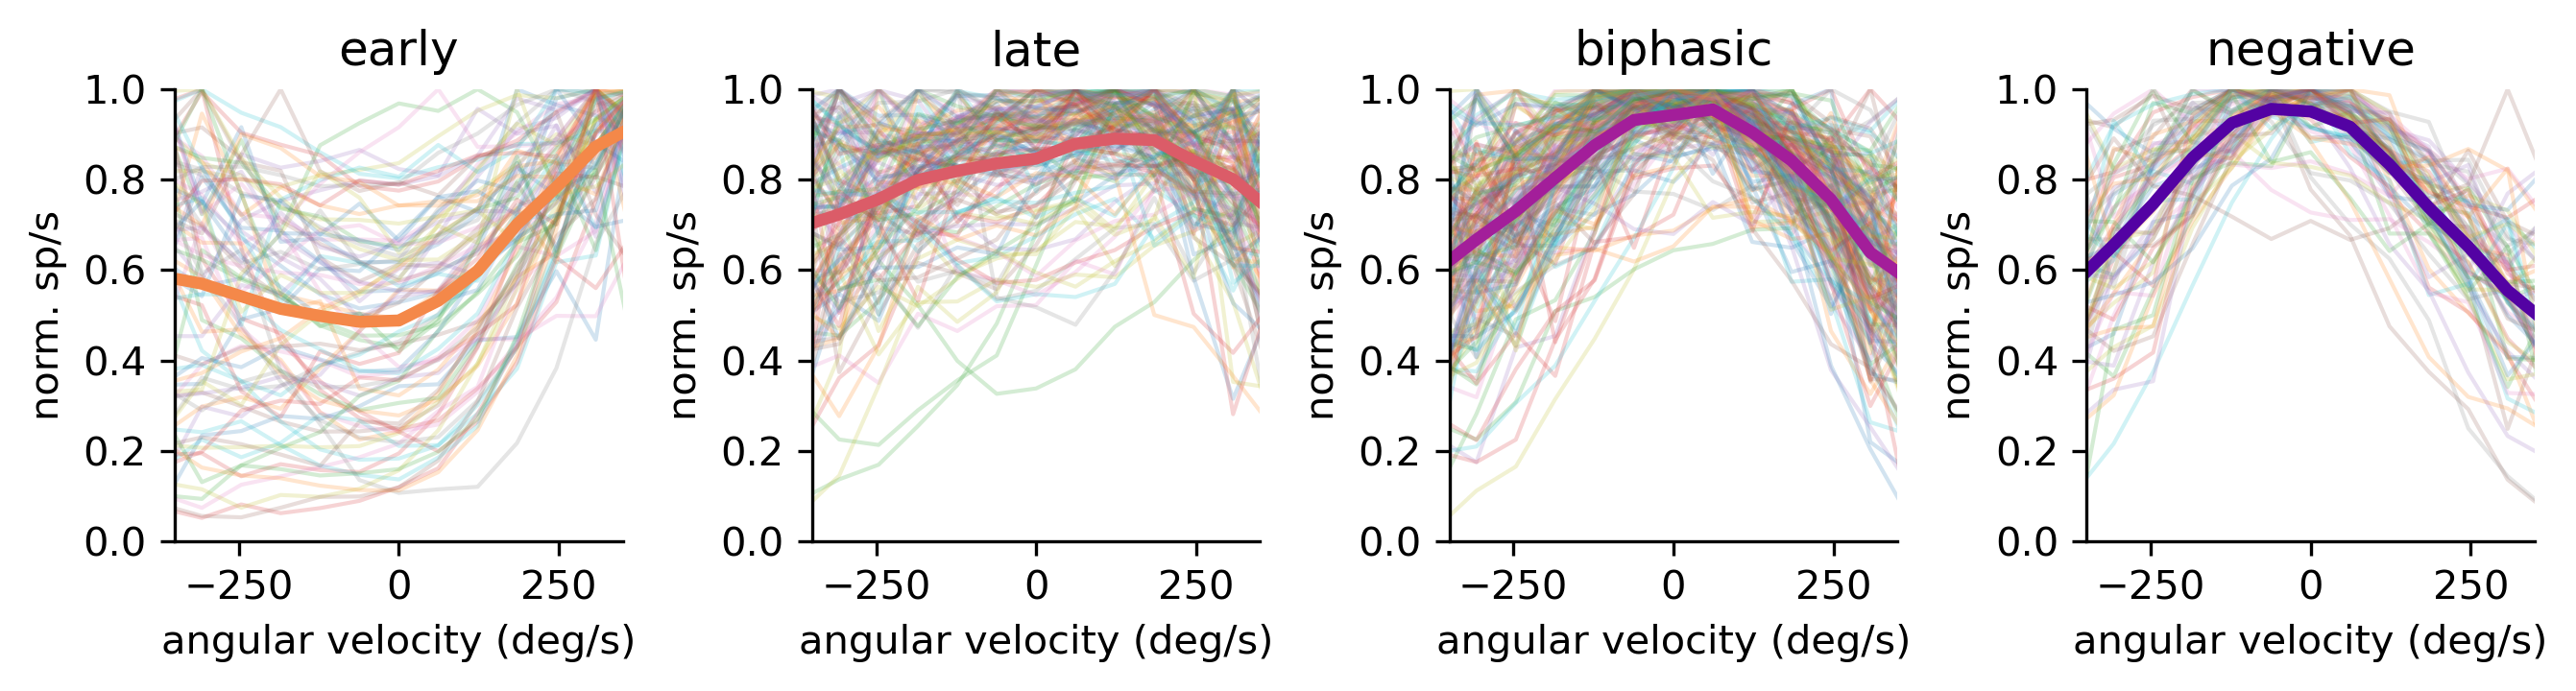

In [547]:
fig, axs = plt.subplots(1,4, figsize=(9,2.5), dpi=300)
axs = axs.flatten()

for k, kname in enumerate(['early','late','biphasic','negative']):
    
    ### LIGHT DATA
    cluster_inds = hffm['gazecluster'].to_list()
    use_inds = np.where(np.array(cluster_inds)==kname)[0]
    
    for i in use_inds:
        axs[k].plot(bins, norm_gyroZ_tunings[i,:], '-', alpha=0.2, linewidth=1)
    
    mresp = np.mean(norm_gyroZ_tunings[use_inds,:],0)
    axs[k].plot(bins, mresp, '-', color=cat_cmap[kname], linewidth=3)
    
    axs[k].set_title(kname)
    axs[k].set_xlim([-350,350])
    axs[k].set_xlabel('angular velocity (deg/s)')
    axs[k].set_ylabel('norm. sp/s')
    axs[k].set_ylim([0,1])
    
fig.tight_layout()
fig.savefig('/home/niell_lab/Desktop/gyroZ_tunings.pdf')

## dark

In [501]:
darkL_gyroZ_tunings = np.zeros([len(ltdk.index.values), 13]) # cell, tuning/err, bins
darkD_gyroZ_tunings = np.zeros([len(ltdk.index.values), 13]) # cell, tuning/err, bins

gz_bins = np.linspace(-400,400,14) # was 10 bins, now trying 25

for ind, row in tqdm(ltdk.iterrows()):
    
    ### LIGHT
    model_active = row['FmLt_model_active']
    imuT = row['FmLt_imuT'].values
    modelT = np.arange(0, len(row['FmLt_model_active'])*0.025, 0.025)
    
    gyroZ = interp1d(imuT, row['FmLt_gyro_z'], bounds_error=False)(modelT)
    
    use = np.where(model_active > 70)[0]
    
    rate = row['FmLt_rate']
    
    tuning, err, bins = calc_tuning(rate[use], gyroZ[use], modelT[use], gz_bins)
    
    darkL_gyroZ_tunings[ind,:] = tuning
    
    ### DARK
    model_active = row['FmDk_model_active']
    imuT = row['FmDk_imuT'].values
    modelT = np.arange(0, len(row['FmDk_model_active'])*0.025, 0.025)
    
    gyroZ = interp1d(imuT, row['FmDk_gyro_z'], bounds_error=False)(modelT)
    
    use = np.where(model_active > 70)[0]
    
    rate = row['FmDk_rate']
    
    tuning, err, bins = calc_tuning(rate[use], gyroZ[use], modelT[use], gz_bins)
    
    darkD_gyroZ_tunings[ind,:] = tuning
    
    # dark_gyroZ_tunings[ind,1,:] = err
    
    # hffm.at[ind,'FmLt_gyroZ_tuning'] = tuning
    # hffm.at[ind,'FmLt_gyroZ_err'] = err

0it [00:00, ?it/s]/tmp/ipykernel_32029/1830356369.py:15: RuntimeWarning: invalid value encountered in greater
  use = np.where(model_active > 70)[0]
21it [00:00, 67.67it/s]/tmp/ipykernel_32029/1830356369.py:30: RuntimeWarning: invalid value encountered in greater
  use = np.where(model_active > 70)[0]
269it [00:03, 69.24it/s]


In [498]:
# gyroZ_tunings = np.zeros([len(ltdk.index.values), 2, 13]) # cell, tuning/err, bins

# gz_bins = np.linspace(-400,400,14) # was 10 bins, now trying 25

# for ind, row in tqdm(ltdk.iterrows()):
    
#     model_active = row['FmLt_model_active']
#     imuT = row['FmLt_imuT'].values
#     modelT = np.arange(0, len(row['FmLt_model_active'])*0.025, 0.025)
    
#     gyroZ = interp1d(imuT, row['FmLt_gyro_z'], bounds_error=False)(modelT)
    
#     use = np.where(model_active > 70)[0]
    
#     rate = row['FmLt_rate']
    
#     tuning, err, bins = calc_tuning(rate[use], gyroZ[use], modelT[use], gz_bins)
    
#     gyroZ_tunings[ind,0,:] = tuning
#     gyroZ_tunings[ind,1,:] = err
    
    # hffm.at[ind,'FmLt_gyroZ_tuning'] = tuning
    # hffm.at[ind,'FmLt_gyroZ_err'] = err

0it [00:00, ?it/s]/tmp/ipykernel_32029/2120767365.py:13: RuntimeWarning: invalid value encountered in greater
  use = np.where(model_active > 70)[0]
269it [00:01, 138.74it/s]


In [502]:
cluster_inds = ltdk['gazecluster'].to_list()

In [504]:
norm_darkD_gyroZ_tunings = np.zeros([np.size(darkD_gyroZ_tunings,0), np.size(darkD_gyroZ_tunings,1)])
norm_darkL_gyroZ_tunings = np.zeros([np.size(darkD_gyroZ_tunings,0), np.size(darkD_gyroZ_tunings,1)])

for i in range(np.size(darkD_gyroZ_tunings,0)):
    # dark
    norm_tuning = darkD_gyroZ_tunings[i,:].copy()
    norm_tuning = norm_tuning / np.nanmax(norm_tuning)
    norm_darkD_gyroZ_tunings[i,:] = norm_tuning
    # light
    norm_tuning = darkL_gyroZ_tunings[i,:].copy()
    norm_tuning = norm_tuning / np.nanmax(norm_tuning)
    norm_darkL_gyroZ_tunings[i,:] = norm_tuning

In [505]:
flip_direction = np.zeros(len(ltdk.index.values))
for i, ind in enumerate(ltdk.index.values):
    if ltdk.loc[ind,'pref_gazeshift_direction']=='left':
        flip_direction[i] = 1
        
for i in range(np.size(norm_darkD_gyroZ_tunings,0)):
    if flip_direction[i] == 1:
        norm_darkL_gyroZ_tunings[i,:] = norm_darkL_gyroZ_tunings[i,::-1]
        norm_darkD_gyroZ_tunings[i,:] = norm_darkD_gyroZ_tunings[i,::-1]

In [494]:
norm_gyroZ_tunings = np.zeros([np.size(dark_gyroZ_tunings,0), np.size(dark_gyroZ_tunings,2)])

for i in range(np.size(dark_gyroZ_tunings,0)):
    norm_tuning = dark_gyroZ_tunings[i,0,:].copy()
    norm_tuning = norm_tuning / np.nanmax(norm_tuning)
    norm_gyroZ_tunings[i,:] = norm_tuning

flip_direction = np.zeros(len(ltdk.index.values))
for i, ind in enumerate(ltdk.index.values):
    if ltdk.loc[ind,'pref_gazeshift_direction']=='left':
        flip_direction[i] = 1
        
norm_gyroZ_tunings_hflip = norm_gyroZ_tunings.copy()
for i in range(np.size(norm_gyroZ_tunings_hflip,0)):
    if flip_direction[i] == 1:
        norm_gyroZ_tunings_hflip[i,:] = norm_gyroZ_tunings_hflip[i,::-1]

IndexError: index 269 is out of bounds for axis 0 with size 269

In [493]:
norm_gyroZ_tunings_hflip.shape

(716, 13)

In [475]:
dark_flip_direction = np.zeros(len(ltdk.index.values))
for i, ind in enumerate(ltdk.index.values):
    if ltdk.loc[ind,'pref_gazeshift_direction']=='left':
        dark_flip_direction[i] = 1
        
norm_gyroZ_tunings_hflip_dark = norm_dark_gyroZ_tunings.copy()
for i in range(np.size(norm_gyroZ_tunings_hflip_dark,0)):
    if dark_flip_direction[i] == 1:
        norm_gyroZ_tunings_hflip_dark[i,:] = norm_gyroZ_tunings_hflip_dark[i,::-1]

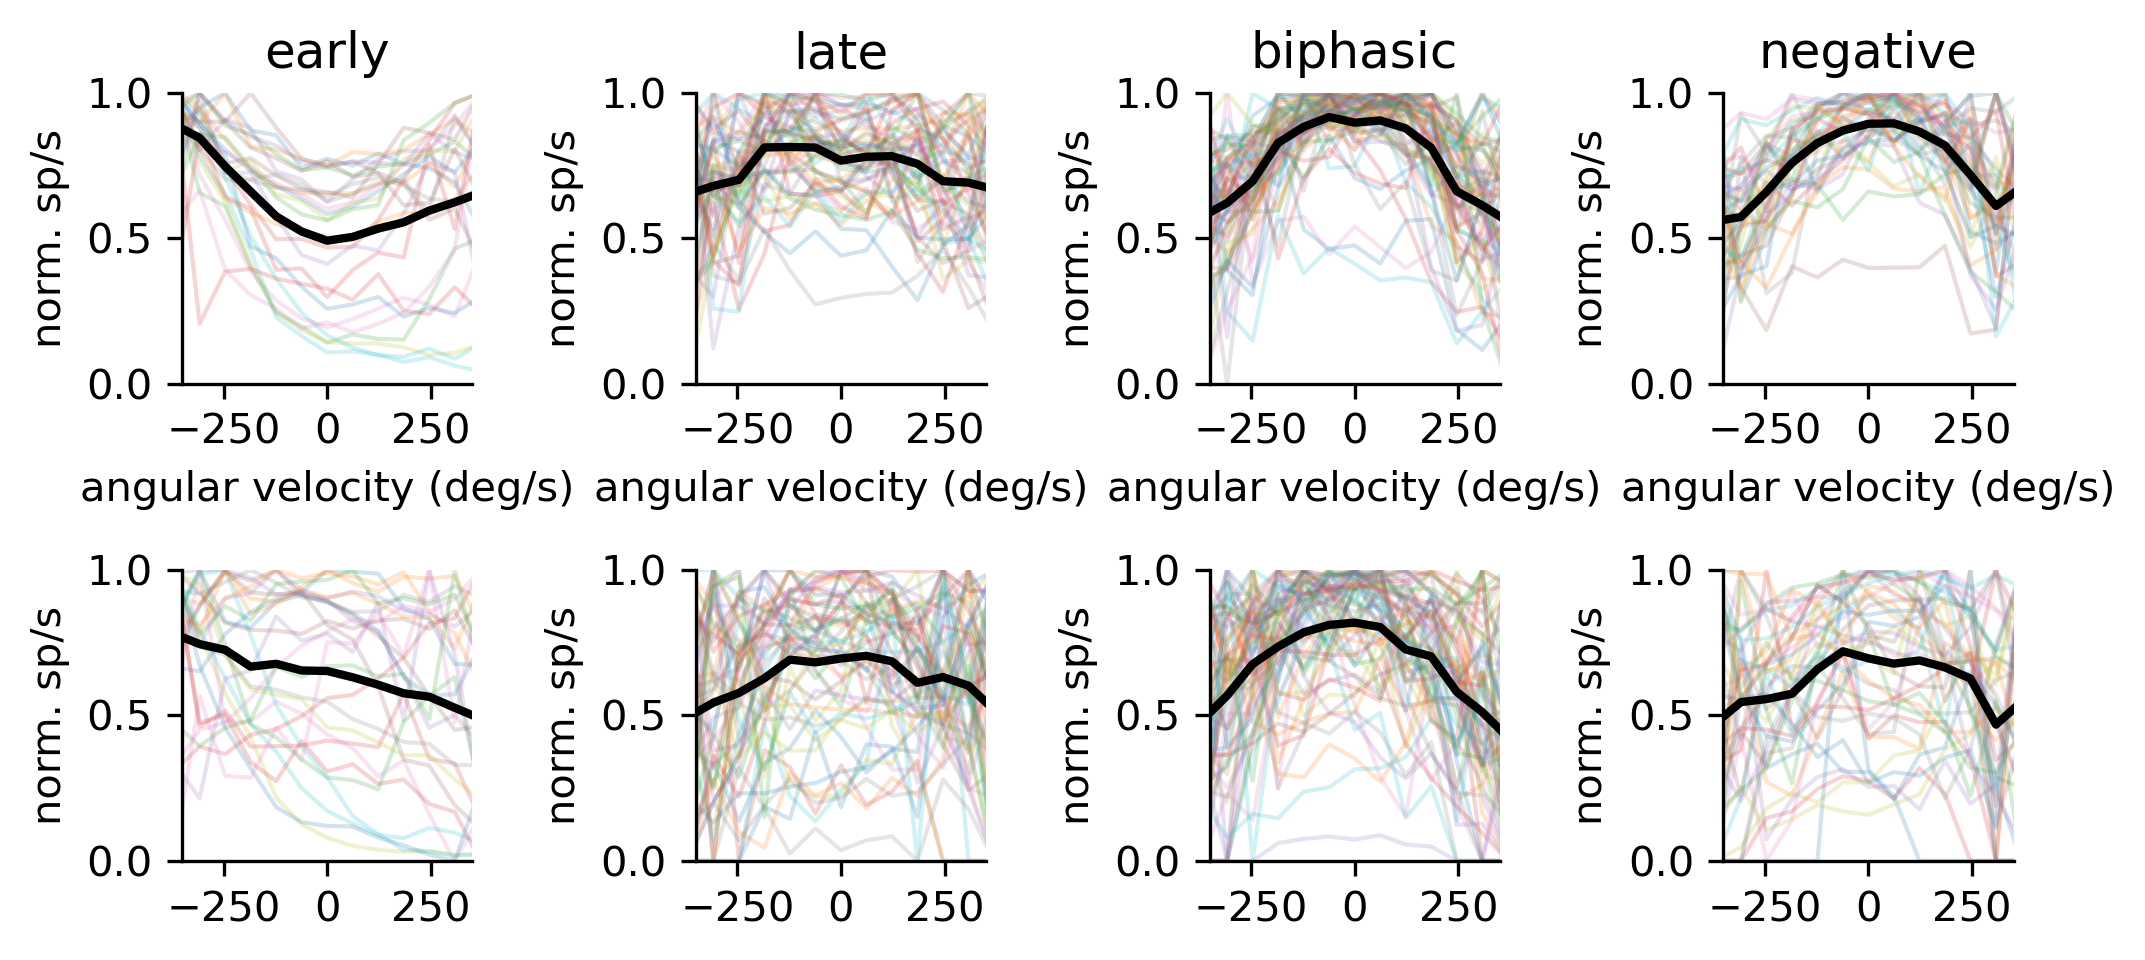

In [506]:
fig, axs = plt.subplots(2,4, figsize=(7,3.3), dpi=300)
axs = axs.flatten()

for k, kname in enumerate(['early','late','biphasic','negative']):
    
    ### LIGHT DATA
    cluster_inds = ltdk['gazecluster'].to_list()
    use_inds = np.where(np.array(cluster_inds)==kname)[0]
    
    for i in use_inds:
        axs[k].plot(bins, norm_darkL_gyroZ_tunings[i,:], '-', alpha=0.2, linewidth=1)
    
    mresp = np.mean(norm_darkL_gyroZ_tunings[use_inds,:],0)
    axs[k].plot(bins, mresp, 'k-', linewidth=2)
    
    axs[k].set_title(kname)
    axs[k].set_xlim([-350,350])
    axs[k].set_xlabel('angular velocity (deg/s)')
    axs[k].set_ylabel('norm. sp/s')
    axs[k].set_ylim([0,1])
    
    ### DARK DATA
    cluster_inds = ltdk['gazecluster'].to_list()
    use_inds = np.where(np.array(cluster_inds)==kname)[0]
    
    for i in use_inds:
        axs[k+4].plot(bins, norm_darkD_gyroZ_tunings[i,:], '-', alpha=0.2, linewidth=1)
    
    mresp = np.mean(norm_darkD_gyroZ_tunings[use_inds,:],0)
    # err = standard_error(norm_gyroZ_tunings_hflip_dark[use_inds,:])
    axs[k+4].plot(bins, mresp, 'k-', linewidth=2)
    
    # axs[k].set_title(kname)
    axs[k+4].set_xlim([-350,350])
    axs[k].set_xlabel('angular velocity (deg/s)')
    axs[k+4].set_ylabel('norm. sp/s')
    axs[k+4].set_ylim([0,1])
    
fig.tight_layout()
fig.savefig('/home/niell_lab/Desktop/gyro_z_tuning_LTDK_hflip.pdf')

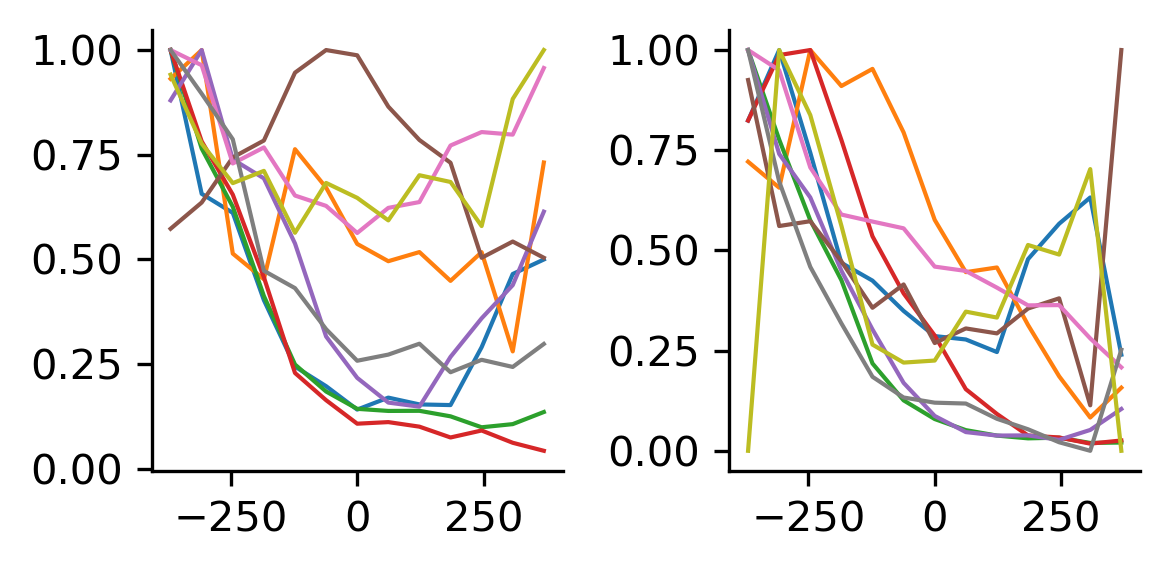

In [516]:
fig, [ax0, ax1] = plt.subplots(1,2,figsize=(4,2),dpi=300)
for i in ltdk[ltdk['dark_responsive']==True].index.values:
    ax0.plot(bins, norm_darkL_gyroZ_tunings[i,:], '-', linewidth=1)
    ax1.plot(bins, norm_darkD_gyroZ_tunings[i,:], '-', linewidth=1)
fig.tight_layout()

In [384]:
cluster_inds = hffm['gazecluster'].to_list()
use_inds = np.where(np.array(cluster_inds)=='early')[0]

mresp = gyroZ_tunings[use_inds,0,:]
mresp = np.median(mresp, 0)
mresp = mresp / np.nanmax(mresp)

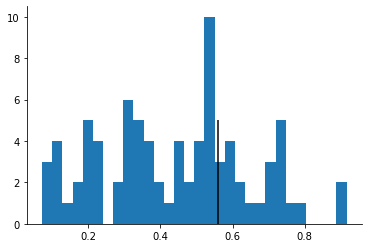

In [394]:
centvals = []
for i in use_inds:
    x = gyroZ_tunings[i,0,:]
    # x = np.nanmedian(x,0)
    x = x / np.nanmax(x)
    centvals.append(x[6])
plt.hist(centvals, bins=30)
plt.vlines(mresp[6], 0, 5, 'k')

In [340]:
np.where(np.array(cluster_inds)=='late')[0]

array([  0,   1,   3,   4,   7,  10,  11,  13,  16,  19,  21,  22,  37,
        44,  49,  51,  53,  56,  65,  67,  74,  77,  95, 101, 102, 109,
       113, 115, 133, 139, 144, 146, 148, 150, 160, 161, 165, 166, 169,
       177, 196, 205, 208, 209, 210, 213, 214, 221, 232, 233, 238, 239,
       246, 250, 255, 260, 261, 262, 272, 282, 284, 288, 302, 309, 329,
       341, 343, 345, 372, 380, 383, 385, 386, 391, 401, 403, 425, 429,
       432, 445, 446, 447, 451, 458, 460, 463, 466, 473, 475, 490, 492,
       493, 496, 498, 502, 504, 517, 527, 536, 537, 538, 541, 544, 548,
       553, 562, 578, 583, 597, 602, 605, 609, 619, 630, 638, 641, 645,
       647, 652, 659, 660, 669, 670, 673, 679, 680, 681, 682, 684, 685,
       686, 687, 688, 711, 714])

In [326]:
gyroZ_tunings[use_inds,0,:]

array([], shape=(0, 13), dtype=float64)

In [269]:
hffm[hffm['FmLt_gyroz_modind']>0.66].index.values

array([ 12,  18,  37,  46,  57,  78,  91,  93,  96, 100, 114, 129, 135,
       141, 142, 148, 149, 151, 158, 162, 163, 167, 171, 185, 193, 207,
       226, 256, 294, 370, 377, 393, 394, 413, 429, 438, 441, 487, 513,
       519, 540, 542, 554, 567, 585, 614, 627, 661, 662, 666, 668, 672,
       674, 694])

[0.10126582 0.         0.1440144  0.19271949 0.23745278 0.20121243
 0.12631881 0.1413806  0.14899211 0.18599408 0.10452962 0.26755853
 0.16129032 0.11713031 0.09111617]


(0.0, 0.29431438127090304)

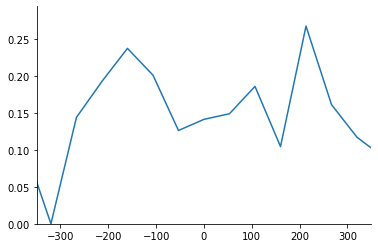

In [319]:
gz_bins = np.linspace(-400,400,14)

ind = 550
row = hffm.loc[ind]

model_active = row['FmLt_model_active']
imuT = row['FmLt_imuT'].values
modelT = np.arange(0, len(row['FmLt_model_active'])*0.025, 0.025)

gyroZ = interp1d(imuT, row['FmLt_gyro_z'], bounds_error=False)(modelT)

use = np.where(model_active > 40)[0]

rate = row['FmLt_rate']

tuning, err, bins = calc_tuning(rate[use], gyroZ[use], modelT[use], gz_bins)

# tuning[int(16/2)-1] = np.nan

print(tuning)
plt.plot(bins, tuning)
# plt.vlines(0, 0, np.max(tuning), 'k')
plt.xlim([-350,350])
plt.ylim([0, np.max(tuning)*1.1])

# u, sp_rate = calc_tuning(rate, gyroZ, modelT, gz_bins)

(0.0, 0.2277056746719575)

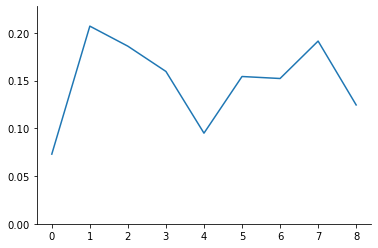

In [317]:
tuning = hffm.loc[550,'FmLt_gyroz_tuning']
plt.plot(tuning)
plt.ylim([0, np.max(tuning)*1.1])

In [205]:
val = gyroZ
gap = 0
vrange = gz_bins
x = 3

In [215]:
val

array([-159.48647051, -220.93944811, -280.85611721, ...,   -4.33948579,
         -8.19659464,           nan])

In [208]:
vrange[x]

-300.0

In [207]:
(val[:-gap] >= vrange[x])# & (val[:-gap] < vrange[x+1])

array([], dtype=bool)

In [ ]:
# old data that was read in from pickle file

fig, axs = plt.subplots(2,2, figsize=(4,4), dpi=300)
axs = axs.flatten()

for k, name in enumerate(['early','late','biphasic','negative']):
    
    for ind, row in ltdk[ltdk['gazecluster']==name].iterrows():
        norm_tuning = row['FmLt_gyroz_tuning'].copy()
        norm_tuning = norm_tuning / np.nanmax(norm_tuning)
        axs[k].plot(row['FmLt_gyroz_tuning_bins'], norm_tuning, '-', alpha=0.2, linewidth=1)
    mresp = flatten_series(hffm['FmLt_gyroz_tuning'][hffm['gazecluster']==name])
    mresp = np.median(mresp, 0)
    mresp = mresp / np.nanmax(mresp)
    axs[k].plot(row['FmLt_gyroz_tuning_bins'], mresp, 'k-', linewidth=2)
    
    axs[k].set_title(name)
    axs[k].set_xlim([-300,300])
    axs[k].set_xlabel('angular velocity (deg/s)')
    axs[k].set_ylabel('norm. sp/s')
    axs[k].set_ylim([0,1])
    
fig.tight_layout()

In [36]:
saccrast_df = hffm[hffm['session']=='070921_J553RT_control_Rig2'][hffm['gazecluster']!='unresponsive'].copy()
saccrast_df = saccrast_df.sort_values(by='FmLt_gazeshift_peakT',axis=0,ascending=True).reset_index(drop=True)

saccT = np.array(sorted(list(saccrast_df.loc[0,'FmLt_gazeshift_left_saccTimes_dHead'])
         + list(saccrast_df.loc[0,'FmLt_gazeshift_right_saccTimes_dHead'])))

/tmp/ipykernel_30399/1674885572.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  saccrast_df = hffm[hffm['session']=='070921_J553RT_control_Rig2'][hffm['gazecluster']!='unresponsive'].copy()


In [37]:
spikeT = saccrast_df['FmLt_spikeT'].copy().to_dict()

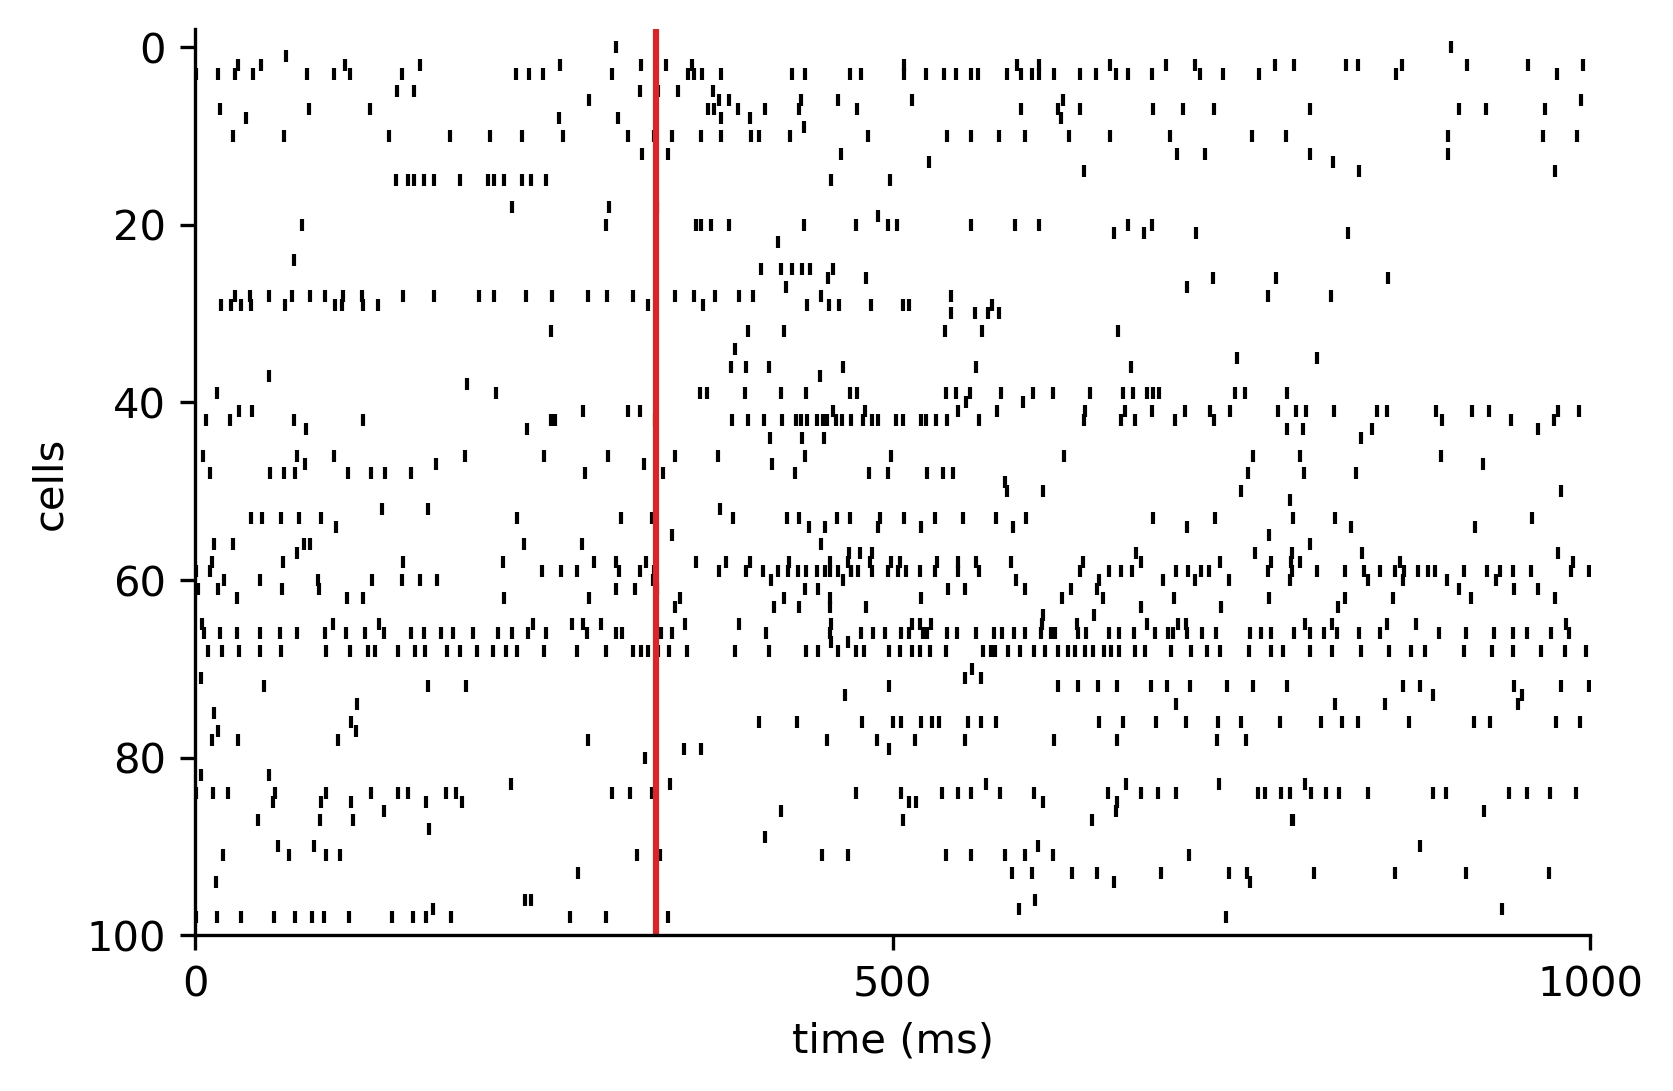

In [57]:
fig, ax_raster = plt.subplots(1,1, dpi=300)#, figsize=(3,5))
plot_t0 = 20.2
plot_tlen = 1
for i, sps in spikeT.items():
    sps = sps[(sps>plot_t0) * (sps<(plot_t0+plot_tlen))]
    ax_raster.plot(sps, np.ones(len(sps))*i, '|', color='k', markersize=3)
ax_raster.set_ylim([len(spikeT.keys())+1,-2])
ax_raster.set_xlim([plot_t0, plot_t0+plot_tlen])
ax_raster.set_xticks(np.arange(plot_t0, plot_t0+plot_tlen+0.5, 0.5))
ax_raster.set_xticklabels((np.arange(0, plot_tlen+0.5, 0.5)*1000).astype(int))
ax_raster.set_ylabel('cells')
ax_raster.set_xlabel('time (ms)')
ax_raster.spines['right'].set_visible(False)
ax_raster.spines['top'].set_visible(False)

show_saccT = saccT[(saccT>plot_t0) * (saccT<(plot_t0+plot_tlen))]
ax_raster.vlines(show_saccT, -2, len(spikeT.keys())+2, color='tab:red')

# % responsive

In [ ]:
for ind, row in hffm.iterrows():
    

In [10]:
len(hffm[hffm['raw_mod_at_pref_peak']>1][hffm['norm_mod_at_pref_peak']>.1].index.values) / 716

/tmp/ipykernel_32029/136187210.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(hffm[hffm['raw_mod_at_pref_peak']>1][hffm['norm_mod_at_pref_peak']>.1].index.values) / 716


0.7416201117318436

In [9]:
len(hffm.index.values)

716

In [15]:
def psth_modind(psth):
    # modulation in terms of spike rate
    psth = psth.astype(float)
    use = psth - np.mean(psth[0:800].copy())
    mod = np.max(np.abs(use[1000:1250]))
    return mod

for ind, row in hffm.iterrows():
    
    norm_psth = row['pref_comp_psth']
    raw_psth = row['pref_comp_psth_raw']
    
    hffm.at[ind, 'raw_comp_modind'] = psth_modind(raw_psth)
    hffm.at[ind, 'norm_comp_modind'] = psth_modind(norm_psth)

In [17]:
len(hffm[hffm['raw_comp_modind']>1][hffm['norm_comp_modind']>.1].index.values) / 716

/tmp/ipykernel_32029/2314746212.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(hffm[hffm['raw_comp_modind']>1][hffm['norm_comp_modind']>.1].index.values) / 716


0.0670391061452514

In [9]:
len(hffm.index.values)

716

In [ ]:
hffm['']

# Unit counts

In [32]:
len(hffm[hffm['gazecluster']!='unresponsive'].index.values)

453

In [29]:
hffm['gazeshift_responsive'].value_counts()

True     531
False    185
Name: gazeshift_responsive, dtype: int64

In [48]:
len(hffm[hffm['gazecluster']=='unresponsive'].index.values)

263

In [52]:
len(hffm[hffm['gazecluster']=='unresponsive'][hffm['gazeshift_responsive']==False].index.values)

/tmp/ipykernel_32029/2778848408.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(hffm[hffm['gazecluster']=='unresponsive'][hffm['gazeshift_responsive']==False].index.values)


185

In [51]:
185+78

263

# Reused values and functions

In [42]:
plasma_map = plt.cm.plasma(np.linspace(0,1,15))
cat_cmap = {
    'movement': plasma_map[12,:],
    'early': plasma_map[10,:],
    'late': plasma_map[8,:],
    'biphasic': plasma_map[5,:],
    'negative': plasma_map[2,:],
    'unresponsive': 'dimgrey'
}
colors = {
    'gaze': 'firebrick',
    'comp': 'mediumblue',
    'rc': 'indigo'
}
psth_bins = np.arange(-1,1.001,1/1000)

In [40]:
def drop_nan_along(x, axis=1):
    # axis=1 will drop along columns (i.e. any rows with NaNs will be dropped)
    x = x[~np.isnan(x).any(axis=axis)]
    return x

def jitter_ax(center, size):
    return np.ones(size)+np.random.uniform(center-0.2, center+0.2, size)

def plot_cprop_scatter(panel, data, prop_name, use_median=False):
    for c, cluster in enumerate(['early','late','biphasic','negative']):
        cluster_data = data[prop_name][data['gazecluster']==cluster]
        x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(cluster_data,0))
        panel.plot(x_jitter, cluster_data, '.', color=cat_cmap[cluster], markersize=2)
        if use_median:
            hline = np.nanmedian(cluster_data)
        elif not use_median:
            hline = np.nanmean(cluster_data)
        panel.hlines(hline, c-0.2, c+0.2, color='k', linewidth=2)
        err = np.std(cluster_data) / np.sqrt(np.size(cluster_data))
        panel.vlines(c, hline-err, hline+err, color='k', linewidth=2)
        panel.set_xticks(range(4), ['early','late','biphasic','negative'])
        
def plot_tempseq(panel, tseq, return_img=False, freev=None):
    panel.set_xlabel('time (msec)')
    panel.set_ylim([np.size(tseq,0),0])
    vmin = -0.75; vmax = 0.75
    if freev is not None:
        vmin = -freev
        vmax = freev
    img = panel.imshow(tseq, cmap='coolwarm', vmin=vmin, vmax=vmax)
    panel.set_xlim([800,1400])
    panel.set_xticks(np.linspace(800,1400,4), labels=np.linspace(-200,400,4).astype(int))
    panel.vlines(1000, 0, np.size(tseq,0), color='k', linestyle='dashed', linewidth=1)
    if return_img:
        return img
    
def calc_latency(psth):
    # use norm PSTH
    ind = np.argmax(psth[1025:1250])+1025 # was 1000:1170
    peakT = psth_bins[ind]
    val = psth[ind]
    return peakT, val

def psth_modind(psth, baseval='range'):
    # modulation in terms of spike rate
    psth = psth.astype(float)
    if baseval=='range':
        use = psth - np.mean(psth[0:800].copy())
    elif baseval=='zero':
        use = psth - psth[1000]
    mod = np.max(np.abs(use[1000:1250]))
    return mod

## fig1 demo data

In [ ]:
demo = hffm[hffm['session']=='102621_J558NC_control_Rig2'].iloc[0]

dHead_data = demo['FmLt_dHead']
dEye_data = demo['FmLt_dEye_dps']
dGaze_data = demo['FmLt_dGaze']
eyeT = demo['FmLt_eyeT']

left = demo['FmLt_gazeshift_left_saccTimes_dHead1']
right = demo['FmLt_gazeshift_right_saccTimes_dHead1']
comp = np.hstack([demo['FmLt_comp_left_saccTimes_dHead1'], demo['FmLt_comp_right_saccTimes_dHead1']])

plotinds = np.sort(np.random.choice(np.arange(eyeT.size), size=int(np.ceil(eyeT.size/25)), replace=False))
gazemovs = np.hstack([left, right])

## Rc and SN

In [44]:
for ind, row in hffm.iterrows():
    sec = row['Rc_eyeT'][-1].astype(float) - row['Rc_eyeT'][0].astype(float)
    sp = len(row['Rc_spikeT'])
    hffm.at[ind, 'Rc_fr'] = sp/sec

    hffm.at[ind, 'raw_mod_for_Rc'] = psth_modind(row['Rc_psth'])

    hffm.at[ind, 'norm_mod_for_Rc'] = psth_modind(row['norm_Rc_psth'])
    
hffm['Rc_responsive'] = False
for ind, row in hffm.iterrows():
    if (row['raw_mod_for_Rc']>1) and (row['norm_mod_for_Rc']>0.1):
        hffm.at[ind, 'Rc_responsive'] = True
print(hffm['Rc_responsive'].sum())

for ind, row in hffm.iterrows():
    sec = row['Sn_eyeT'][-1].astype(float) - row['Sn_eyeT'][0].astype(float)
    sp = len(row['Sn_spikeT'])
    hffm.at[ind, 'Sn_fr'] = sp/sec
    
    hffm.at[ind, 'raw_mod_for_Sn'] = psth_modind(row['Sn_on_background_psth'], baseval='zero')

    hffm.at[ind, 'norm_mod_for_Sn'] = psth_modind(row['norm_Sn_psth'], baseval='zero')
    
hffm['Sn_responsive'] = False
for ind, row in hffm.iterrows():
    if (row['raw_mod_for_Sn']>1) and (row['norm_mod_for_Sn']>0.1):
        hffm.at[ind, 'Sn_responsive'] = True
print(hffm['Sn_responsive'].sum())

for ind in hffm.index.values:
    Rc_peakT, Rc_peakVal = calc_latency(hffm.loc[ind,'norm_Rc_psth'])
    Sn_peakT, Sn_peakVal = calc_latency(hffm.loc[ind,'norm_Sn_psth'])
    Gaze_peakT, Gaze_peakVal = calc_latency(hffm.loc[ind,'pref_gazeshift_psth'])
    
    hffm.at[ind, 'rc_peakT'] = Rc_peakT
    hffm.at[ind, 'sn_peakT'] = Sn_peakT
    hffm.at[ind, 'FmLt_gazeshift_peakT'] = Gaze_peakT
    
use_cols = ['FmLt_gazeshift_peakT','gazecluster','pref_gazeshift_psth','nonpref_gazeshift_psth','Rc_responsive','Sn_responsive',
            'pref_comp_psth','Gt_responsive','nonpref_comp_psth','norm_Rc_psth','norm_Sn_psth','tf_pref_cps','sf_pref_cpd','gazeshift_responsive']
    
sorted_df = hffm[use_cols].copy()
tseq_unresp = sorted_df.copy()
tseq_unresp = sorted_df[(sorted_df['gazecluster']=='unresponsive') * (sorted_df['gazeshift_responsive']==False)].sample(frac=1).reset_index(drop=True)
tseq_unresp_pref = flatten_series(tseq_unresp['pref_gazeshift_psth'])
tseq_unresp_nonpref = flatten_series(tseq_unresp['nonpref_gazeshift_psth'])
tseq_unresp_comp = flatten_series(tseq_unresp['pref_comp_psth'])
tseq_unresp_rc = flatten_series(tseq_unresp['norm_Rc_psth'][sorted_df['Rc_responsive']])
tseq_unresp_sn = flatten_series(tseq_unresp['norm_Sn_psth'][sorted_df['Sn_responsive']])

sorted_df.sort_values(by='FmLt_gazeshift_peakT', inplace=True)
sorted_df = sorted_df[sorted_df['gazecluster']!='unresponsive'][sorted_df['gazeshift_responsive']==True].reset_index()
tseq_pref = flatten_series(sorted_df['pref_gazeshift_psth'].copy())
tseq_nonpref = flatten_series(sorted_df['nonpref_gazeshift_psth'].copy())
tseq_comp = flatten_series(sorted_df['pref_comp_psth'].copy())
tseq_rc = flatten_series(sorted_df['norm_Rc_psth'][sorted_df['Rc_responsive']].copy())
tseq_sn = flatten_series(sorted_df['norm_Sn_psth'][sorted_df['Sn_responsive']].copy())
tseq_grat_tf = sorted_df['tf_pref_cps'][sorted_df['Gt_responsive']].copy().to_numpy()
tseq_grat_sf = sorted_df['sf_pref_cpd'][sorted_df['Gt_responsive']].copy().to_numpy()

tseq_pref1 = np.vstack([tseq_pref, tseq_unresp_pref])
tseq_nonpref1 = np.vstack([tseq_nonpref, tseq_unresp_nonpref])
tseq_comp1 = np.vstack([tseq_comp, tseq_unresp_comp])
tseq_rc1 = np.vstack([tseq_rc, tseq_unresp_rc])
tseq_sn1 = np.vstack([tseq_sn, tseq_unresp_sn])

tseq_legend_col = sorted_df['gazecluster'].copy()
tseq_legend = np.zeros([len(tseq_legend_col.index.values), 1, 4])
for i, n in enumerate(tseq_legend_col):
    tseq_legend[i,:,:] = cat_cmap[n]
ucmap = mpl.colors.to_rgba(cat_cmap['unresponsive'])
u = np.zeros([np.size(tseq_unresp_pref,0), 1, 4])
for x in range(4):
    u[:,:,x] = ucmap[x]
tseq_legend1 = np.vstack([tseq_legend, u])

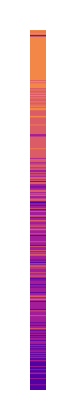

In [58]:
fig, ax = plt.subplots(1,1,figsize=(0.5,1.5), dpi=300)
ax.imshow(tseq_legend, aspect=.05)
ax.set_yticks([]); ax.set_xticks([])
ax.axes.spines.bottom.set_visible(False)
ax.axes.spines.right.set_visible(False)
ax.axes.spines.left.set_visible(False)
ax.axes.spines.top.set_visible(False)
plt.tight_layout()
fig.savefig(os.path.join(figpath, '2_hffm_tseq_legend.pdf'))

# Figure 1

## gaze-shifting vs. comp

In [ ]:
vals = hffm['pref_gazeshift_psth_raw'][hffm['gazecluster']=='early'][hffm['Fm_fr']<15].copy()
for i, x in enumerate(vals):
    plt.figure()
    plt.title(vals.index.values[i])
    plt.plot(psth_bins, x)
    plt.vlines(0, 0, 5)

In [ ]:
fig1 = plt.figure(constrained_layout=True, figsize=(9,8), dpi=300)
fig1spec = gridspec.GridSpec(nrows=5, ncols=3, figure=fig1, wspace=1.5, hspace=1.5)

fig1Cspec = gridspec.GridSpecFromSubplotSpec(3,1,subplot_spec=fig1spec[0:2,1], wspace=0, hspace=0.01)
ax_theta = fig1.add_subplot(fig1Cspec[0,0])
ax_yaw = fig1.add_subplot(fig1Cspec[1,0])
ax_gaze = fig1.add_subplot(fig1Cspec[2,0])

fig1Dspec = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=fig1spec[0:2,2], wspace=0, hspace=0)
ax_dEyeHead = fig1.add_subplot(fig1Dspec[0,0])

fig1E2Fspec = gridspec.GridSpecFromSubplotSpec(3,3,subplot_spec=fig1spec[2:,0:2], wspace=0.15, hspace=-.05)

ax_pos_rasterG = fig1.add_subplot(fig1E2Fspec[0,0])
ax_biph_rasterG = fig1.add_subplot(fig1E2Fspec[0,1])
ax_neg_rasterG = fig1.add_subplot(fig1E2Fspec[0,2])

ax_pos_rasterC = fig1.add_subplot(fig1E2Fspec[1,0])
ax_biph_rasterC = fig1.add_subplot(fig1E2Fspec[1,1])
ax_neg_rasterC = fig1.add_subplot(fig1E2Fspec[1,2])

ax_pos_psth = fig1.add_subplot(fig1E2Fspec[2,0])
ax_biph_psth = fig1.add_subplot(fig1E2Fspec[2,1])
ax_neg_psth = fig1.add_subplot(fig1E2Fspec[2,2])

fig1Gspec = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=fig1spec[2:,2:], wspace=0.2, hspace=0.1)
ax_ex_gaze = fig1.add_subplot(fig1Gspec[0,0])
ax_ex_comp = fig1.add_subplot(fig1Gspec[1,0])

start = 2090 #2100
win = 60 # frames, not sec
ex_units = [215, 579, 277] # [39,112,126]

ylim_val = 36
theta_data = demo['FmLt_theta'][start:start+win]
theta_data = theta_data - np.nanmean(theta_data)
ax_theta.plot(theta_data, 'k-', linewidth=2, scaley=10)
ax_theta.set_xlim([0,60]); ax_theta.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_theta.set_ylabel('theta (deg)')
ax_theta.set_ylim([-ylim_val,ylim_val])
ax_theta.axes.get_xaxis().set_visible(False)
ax_theta.axes.spines.bottom.set_visible(False)

pYaw = np.nancumsum(demo['FmLt_dHead'][start:start+win]*0.016)
pYaw = pYaw - np.nanmean(pYaw)
ax_yaw.plot(pYaw, 'k-', linewidth=2)
ax_yaw.set_xlim([0,60])
ax_yaw.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_yaw.set_ylabel('yaw (deg)')
ax_yaw.axes.get_xaxis().set_visible(False)
ax_yaw.axes.spines.bottom.set_visible(False)
ax_yaw.set_ylim([-ylim_val,ylim_val])

ax_gaze.plot(pYaw + theta_data, 'k-', linewidth=2)
ax_gaze.set_xlim([0,60])
ax_gaze.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1000,5).astype(int))
ax_gaze.set_ylabel('gaze (deg)')
ax_gaze.set_ylim([-ylim_val,ylim_val])
ax_gaze.set_xlabel('time (msec)')

for i in plotinds:
    dGaze_i = np.abs(dHead_data[i]+dEye_data[i])
    if (eyeT[i] in gazemovs) or (dGaze_i>240):
        c = colors['gaze']
    elif (eyeT[i] in comp) or (dGaze_i<120):
        c = colors['comp']
    elif (dGaze_i<240) and (dGaze_i>120): 
        c = 'dimgray'
    else:
        continue
    ax_dEyeHead.plot(dHead_data[i], dEye_data[i], '.', color=c, markersize=2)

ax_dEyeHead.set_aspect('equal','box')
ax_dEyeHead.set_xlim([-600,600])
ax_dEyeHead.set_ylim([-600,600])
ax_dEyeHead.set_xlabel('head velocity (deg/sec)')
ax_dEyeHead.set_ylabel('eye velocity (deg/sec)')
ax_dEyeHead.plot([-500,500],[500,-500], linestyle='dashed', color='k', linewidth=1)
# ax_dEyeHead.annotate('left', xy=[350,500], color='k')
# ax_dEyeHead.annotate('right', xy=[-550,-500], color='k')
# ax_dEyeHead.annotate('gaze shift', xy=[-620,470], color=colors['gaze'])
# ax_dEyeHead.annotate('compensated', xy=[-620,550], color=colors['comp'])
ax_dEyeHead.set_xticks(np.linspace(-600,600,5))
ax_dEyeHead.set_yticks(np.linspace(-600,600,5))

num_movements = 500
raster_panelsG = [ax_pos_rasterG, ax_biph_rasterG, ax_neg_rasterG]
raster_panelsC = [ax_pos_rasterC, ax_biph_rasterC, ax_neg_rasterC]
sdf_panels = [ax_pos_psth, ax_biph_psth, ax_neg_psth]
for i, u in enumerate(ex_units):
    row = hffm.iloc[u]
    rasterG = raster_panelsG[i]
    rasterC = raster_panelsC[i]
    sdf_panel = sdf_panels[i]
    LR = hffm.loc[u, 'pref_gazeshift_direction']
    
    rasterG.set_title(['positive','biphasic','negative'][i])

    gazeshifts = row['FmLt_gazeshift_{}_saccTimes_dHead1'.format(LR)].copy()
    compmovs = np.hstack([row['FmLt_comp_left_saccTimes_dHead1'], row['FmLt_comp_right_saccTimes_dHead1']])
    
    plot_gs = np.random.choice(gazeshifts, size=num_movements, replace=False)
    plot_cp = np.random.choice(compmovs, size=num_movements, replace=False)

    for n, s in enumerate(plot_gs):
        sp = row['FmLt_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        rasterG.plot(sp, np.ones(sp.size)*n, '|', color=colors['gaze'], markersize=0.3)

    for n, s in enumerate(plot_cp):
        sp = row['FmLt_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        rasterC.plot(sp, np.ones(sp.size)*n, '|', color=colors['comp'], markersize=0.3) # was 0.25
    
    rasterG.set_ylim([num_movements, 0]); rasterC.set_ylim([num_movements,0])
    rasterG.vlines(0, 0, num_movements, color='k', linewidth=1, linestyle='dashed')
    rasterC.vlines(0, 0, num_movements, color='k', linewidth=1, linestyle='dashed')
    if i == 0:
        rasterG.set_ylabel('gaze shifts'); rasterC.set_ylabel('compensatory')
        rasterG.set_yticks(np.linspace(0, num_movements, 3))
        rasterC.set_yticks(np.linspace(0, num_movements, 3))
    else:
        rasterG.set_yticks(np.linspace(0, num_movements, 3),labels=[])
        rasterC.set_yticks(np.linspace(0, num_movements, 3),labels=[])
    rasterG.set_xticks([]); rasterC.set_xticks([])
    rasterG.set_xlim([-.5,.5]); rasterC.set_xlim([-.5,.5])
    rasterG.axes.spines.bottom.set_visible(False); rasterC.axes.spines.bottom.set_visible(False)
    
    sdf_panel.plot(psth_bins, row['FmLt_comp_{}_saccPSTH_dHead1'.format(LR)], color=colors['comp'])
    sdf_panel.plot(psth_bins, row['FmLt_gazeshift_{}_saccPSTH_dHead1'.format(LR)], color=colors['gaze'])
    max_fr = np.nanmax(row['FmLt_gazeshift_{}_saccPSTH_dHead1'.format(LR)])*1.1
    sdf_panel.set_ylim([0,max_fr])
    sdf_panel.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
    sdf_panel.set_xlim([-.5,.5])
    if i == 0:
        sdf_panel.set_ylabel('spike rate (sp/sec)')
    sdf_panel.set_xlabel('time (msec)')
    sdf_panel.vlines(0, 0, max_fr, color='k', linewidth=1, linestyle='dashed')

possible_inds = hffm['pref_comp_psth'][hffm['Fm_fr']>2].index.values
np.random.seed(2)
example_inds = np.sort(np.random.choice(possible_inds, size=100, replace=False))

for ind in example_inds:
    ax_ex_gaze.plot(psth_bins, hffm.loc[ind,'pref_gazeshift_psth'].astype(float), linewidth=1, alpha=0.3)
    ax_ex_comp.plot(psth_bins, hffm.loc[ind,'pref_comp_psth'].astype(float), linewidth=1, alpha=0.3)
ax_ex_gaze.set_xlim([-.5,.5])
ax_ex_gaze.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
ax_ex_comp.set_xlim([-.5,.5])
ax_ex_comp.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
ax_ex_gaze.set_ylim([-0.75,1])
ax_ex_comp.set_ylim([-0.75,1])
ax_ex_gaze.set_ylabel('norm. spike rate')
ax_ex_comp.set_ylabel('norm. spike rate')
ax_ex_comp.set_xlabel('time (msec)')
ax_ex_gaze.set_xlabel('time (msec)')

all_comp = flatten_series(hffm['pref_comp_psth'][hffm['gazecluster']!='unresponsive'][hffm['gazeshift_responsive']])
all_gaze = flatten_series(hffm['pref_gazeshift_psth'][hffm['gazecluster']!='unresponsive'][hffm['gazeshift_responsive']])

comp_mean = np.nanmean(all_comp,0)
comp_std = np.std(all_comp,0) / np.sqrt(np.size(all_comp))

gaze_mean = np.nanmean(all_gaze,0)
gaze_std = np.std(all_gaze,0) / np.sqrt(np.size(all_gaze))
ax_ex_comp.set_title('compensatory')
ax_ex_gaze.set_title('gaze-shifting')
ax_ex_comp.plot(psth_bins, comp_mean, color=colors['comp'], linewidth=3)
ax_ex_gaze.plot(psth_bins, gaze_mean, color=colors['gaze'], linewidth=3)

ax_ex_gaze.vlines(0, -0.75, 1, 'k', linewidth=1, linestyle='dashed')
ax_ex_comp.vlines(0, -0.75, 1, 'k', linewidth=1, linestyle='dashed')

fig1.savefig(os.path.join(figpath, '1_gazeshift_v_comp.pdf'))

In [ ]:
hffm['gazecluster'][hffm['Sn_responsive']==True].value_counts()

In [ ]:
[215, 579, 277]

In [ ]:
hffm[hffm['gazecluster']=='negative'][hffm['raw_mod_at_pref_peak']>3][hffm['norm_mod_at_pref_peak']>.6].index.values

In [ ]:
plt.plot(psth_bins, hffm.loc[277, 'pref_gazeshift_psth_raw'].copy())
plt.xlim([-.5,.5])
plt.vlines(0, 0, 1, 'k', linewidth=1, linestyle='dashed')

In [ ]:
gaze = row['FmLt_gazeshift_{}_saccTimes_dHead1'.format(row['pref_gazeshift_direction'])].copy()
comp = row['FmLt_comp_{}_saccTimes_dHead1'.format(row['pref_gazeshift_direction'])].copy()


In [ ]:
row['pref_gazeshift_direction']

In [ ]:
gaze_rand = np.random.choice(gaze, size=500, replace=False)
comp_rand = np.random.choice(comp, size=500, replace=False)

In [ ]:
n_inds = np.arange(1000)
gaze_inds = np.array(sorted(np.random.choice(n_inds, size=500, replace=False)))
comp_inds = np.array(sorted(np.delete(n_inds.copy(), gaze_inds.copy())))

In [ ]:
fig, [ax0, ax1] = plt.subplots(1,2, figsize=(6,3.5), dpi=300)
row = hffm.loc[215].copy()

for i in range(gaze_inds.size):
    
    sacc_time = gaze_rand[i]
    raster_row = gaze_inds[i]
    
    sp = row['FmLt_spikeT'] - sacc_time
    sp = sp[np.abs(sp) <= 0.5]
    ax0.plot(sp, np.ones(sp.size)*raster_row, '|', color='k', markersize=0.5)
    ax1.plot(sp, np.ones(sp.size)*raster_row, '|', color=colors['gaze'], markersize=0.5)
    
for i in range(comp_inds.size):
    
    sacc_time = comp_rand[i]
    raster_row = comp_inds[i]
    
    sp = row['FmLt_spikeT'] - sacc_time
    sp = sp[np.abs(sp) <= 0.5]
    ax0.plot(sp, np.ones(sp.size)*raster_row, '|', color='k', markersize=0.5)
    ax1.plot(sp, np.ones(sp.size)*raster_row, '|', color=colors['comp'], markersize=0.5)

ax0.set_ylim([1000, 0]); ax0.set_xlim([-0.5, 0.5])
ax1.set_ylim([1000, 0]); ax1.set_xlim([-0.5, 0.5])
ax0.vlines(0, 0, 1000, 'k', linewidth=0.75)
ax1.vlines(0, 0, 1000, 'k', linewidth=0.75)
ax0.set_ylabel('eye movement'); ax1.set_ylabel('eye movement')
ax0.set_xlabel('time (ms)'); ax1.set_xlabel('time (ms)')
ax0.set_xticks(np.linspace(-.5, .5, 5), labels=np.linspace(-500, 500, 5).astype(int))
ax1.set_xticks(np.linspace(-.5, .5, 5), labels=np.linspace(-500, 500, 5).astype(int))

fig.tight_layout()

fig.savefig(os.path.join(figpath, '0_gaze_comp_rasters_1.pdf'))

In [ ]:
fig, [ax0, ax1] = plt.subplots(1,2, figsize=(6,2), dpi=300)
row = hffm.loc[215].copy()

for n, i in enumerate(range(gaze_inds.size)):
    
    sacc_time = gaze_rand[i]
    # raster_row = gaze_inds[i]
    
    sp = row['FmLt_spikeT'] - sacc_time
    sp = sp[np.abs(sp) <= 0.5]
    # ax0.plot(sp, np.ones(sp.size)*raster_row, '|', color='k', markersize=0.3)
    ax0.plot(sp, np.ones(sp.size)*n, '|', color=colors['gaze'], markersize=0.3)
    
for n, i in enumerate(range(comp_inds.size)):
    
    sacc_time = comp_rand[i]
    # raster_row = comp_inds[i]
    
    sp = row['FmLt_spikeT'] - sacc_time
    sp = sp[np.abs(sp) <= 0.5]
    # ax0.plot(sp, np.ones(sp.size)*raster_row, '|', color='k', markersize=0.3)
    ax1.plot(sp, np.ones(sp.size)*n, '|', color=colors['comp'], markersize=0.3)

ax0.set_ylim([500, 0]); ax0.set_xlim([-0.5, 0.5])
ax1.set_ylim([500, 0]); ax1.set_xlim([-0.5, 0.5])
ax0.vlines(0, 0, 500, 'k', linewidth=0.75)
ax1.vlines(0, 0, 500, 'k', linewidth=0.75)
ax0.set_title('gaze-shifting'); ax1.set_title('compensatory')
ax0.set_ylabel('eye movement'); ax1.set_ylabel('eye movement')
ax0.set_xlabel('time (ms)'); ax1.set_xlabel('time (ms)')
ax0.set_yticks(np.linspace(0, 500, 3)); ax1.set_yticks(np.linspace(0, 500, 3))
ax0.set_xticks(np.linspace(-.5, .5, 5), labels=np.linspace(-500, 500, 5).astype(int))
ax1.set_xticks(np.linspace(-.5, .5, 5), labels=np.linspace(-500, 500, 5).astype(int))

fig.tight_layout()
fig.savefig(os.path.join(figpath, '0_gaze_comp_rasters_2.pdf'))

In [ ]:
row['gazeshift_DSI']

In [ ]:
fig, [ax0, ax1] = plt.subplots(1,2, figsize=(6,2), dpi=300)
row = hffm.loc[215].copy()

ax0.plot(psth_bins, row['FmLt_gazeshift_right_saccPSTH_dHead1'], color=colors['gaze'])
ax0.plot(psth_bins, row['FmLt_comp_right_saccPSTH_dHead1'], color=colors['comp'])

ax0.set_xlim([-0.5, 0.5])
ax0.vlines(0, 0, 21, 'k', linewidth=0.75)
ax0.set_ylabel('sp/sec')
ax0.set_xlabel('time (ms)')
ax0.set_xticks(np.linspace(-.5, .5, 5), labels=np.linspace(-500, 500, 5).astype(int))

fig.tight_layout()
# fig.savefig(os.path.join(figpath, '0_gaze_comp_rasters_3.pdf'))

# position during eye movement

In [113]:
def stderr(a, axis=0):
    return np.nanstd(a,axis=axis) / np.sqrt(np.size(a,axis=axis))

In [114]:
from tqdm import tqdm

In [115]:
session_names = sorted(hffm['session'].unique())
row = hffm[hffm['session']==session_names[1]].iloc[0].copy()

gazeL = row['FmLt_gazeshift_left_saccTimes_dHead1'].copy()
gazeR = row['FmLt_gazeshift_right_saccTimes_dHead1'].copy()
compL = row['FmLt_comp_left_saccTimes_dHead1'].copy()
compR = row['FmLt_comp_right_saccTimes_dHead1'].copy()

In [170]:
session_names = sorted(hffm['session'].unique())

theta_mean = np.zeros([len(session_names), 4, 50])
head_mean = np.zeros([len(session_names), 4, 50])
gaze_mean = np.zeros([len(session_names), 4, 50])

for si, sess in tqdm(enumerate(session_names)):
    
    row = hffm[hffm['session']==sess].iloc[0].copy()
    
    print(sess, row.name)
    
    eyeT = row['FmLt_eyeT'].copy()
    
    head = interp1d(row['FmLt_imuT'].values, row['FmLt_gyro_z'], bounds_error=False)(eyeT)

    theta = row['FmLt_theta'].copy()
    
    # gaze = head.copy() + theta.copy()
    
    gazeL = row['FmLt_gazeshift_left_saccTimes_dHead1'].copy()
    gazeR = row['FmLt_gazeshift_right_saccTimes_dHead1'].copy()
    compL = row['FmLt_comp_left_saccTimes_dHead1'].copy()
    compR = row['FmLt_comp_right_saccTimes_dHead1'].copy()
    
    movs = [gazeL, gazeR, compL, compR]
    
    setmin = np.nanmin(eyeT)+2
    setmax = np.nanmax(eyeT)-2
    
    for x in range(4):

        eventT = movs[x].copy()
        eventT = eventT[eventT>setmin]
        eventT = eventT[eventT<setmax]

        theta_arr = np.zeros([len(eventT), 50])
        head_arr = np.zeros([len(eventT), 50])
        # gaze_arr = np.zeros([len(eventT), 100])

        for i, t in enumerate(eventT):
            tind = np.nanargmin(np.abs(eyeT-t))

            tind_use = tind + np.arange(-25,25)

            theta_arr[i,:] = theta[tind_use].copy()
            head_arr[i,:] = np.cumsum(head[tind_use].copy())*.016
            # gaze_arr[i,:] = gaze[tind_use].copy()

        theta_mean[si,x,:] = np.nanmean(theta_arr, axis=0)
        head_mean[si,x,:] = np.nanmean(head_arr, axis=0)
        # gaze_mean[si,x,:] = np.nanmean(gaze_arr, axis=0)


0it [00:00, ?it/s]

020222_J577TT_control_Rig2 536


1it [00:07,  7.92s/it]

020422_J577RT_control_Rig2 586


2it [00:15,  7.87s/it]

062921_G6HCK1ALTRN_control_Rig2 0


3it [00:20,  6.62s/it]

070921_J553RT_control_Rig2 73


4it [00:27,  6.61s/it]

101521_J559NC_control_Rig2 201


5it [00:43, 10.07s/it]

102621_J558NC_control_Rig2 268


6it [00:58, 11.65s/it]

110321_J558LT_control_Rig2 370


7it [01:09, 11.55s/it]

110421_J569LT_control_Rig2 405


8it [01:16,  9.92s/it]

122021_J581RT_control_Rig2 476


9it [01:21,  9.09s/it]


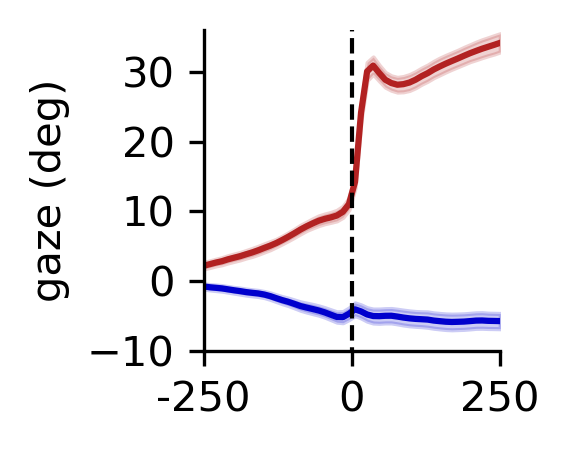

In [200]:
# pos_bins = np.arange(-0.016*50, 0.016*50, 0.016)
pos_bins = np.linspace(-250,250,50)

fig, ax0 = plt.subplots(1,1, dpi=300, figsize=(2,1.6))

# l_gaze, l_gaze_err = pos_to_gaze(theta_mean, head_mean, 0)
# r_gaze, r_gaze_err = pos_to_gaze(theta_mean, head_mean, 1)
# l_comp, l_comp_err = pos_to_gaze(theta_mean, head_mean, 2)
# r_comp, r_comp_err = pos_to_gaze(theta_mean, head_mean, 3)

# l_gaze = np.nanmean(head_mean[:,0,:], 0)
# l_gaze_err = stderr(head_mean[:,0,:], 0)

# r_gaze = np.nanmean(np.cumsum(head_mean[:,1,:], 1), 0)
# r_gaze_err = stderr(np.cumsum(head_mean[:,1,:], 1), 0)

# l_comp = np.nanmean(head_mean[:,2,:], 0)
# l_comp_err = stderr(head_mean[:,2,:], 0)



l_gaze_pos = np.sum([theta_mean[:,0,:], head_mean[:,0,:]], axis=0)
l_gaze = np.nanmean(l_gaze_pos, axis=0)
l_gaze_err = stderr(l_gaze_pos, axis=0)

l_comp_pos = np.sum([theta_mean[:,2,:], head_mean[:,2,:]], axis=0)
l_comp = np.nanmean(l_comp_pos, axis=0)
l_comp_err = stderr(l_comp_pos, axis=0)

# r_comp = np.nanmean(np.cumsum(head_mean[:,3,:], 1), 0)
# r_comp_err = stderr(np.cumsum(head_mean[:,3,:], 1), 0)


### THIS TIME: only plot the leftward/nasal saccades


ax0.plot(pos_bins, l_gaze, color=colors['gaze'])
ax0.fill_between(pos_bins, l_gaze-l_gaze_err, l_gaze+l_gaze_err, color=colors['gaze'], alpha=0.2)

ax0.plot(pos_bins, l_comp, color=colors['comp'])
ax0.fill_between(pos_bins, l_comp-l_comp_err, l_comp+l_comp_err, color=colors['comp'], alpha=0.2)

# ax1.plot(pos_bins, r_gaze, color=colors['gaze'])
# ax1.fill_between(pos_bins, r_gaze-r_gaze_err, r_gaze+r_gaze_err, color=colors['gaze'], alpha=0.2)

# ax1.plot(pos_bins, r_comp, color=colors['comp'])
# ax1.fill_between(pos_bins, r_comp-r_comp_err, r_comp+r_comp_err, color=colors['comp'], alpha=0.2)

ax0.set_xlim([-250,250])

# ax0.set_xticks(np.linspace(-250,250,3), labels=[])
# ax1.set_xlim([-250,250])
ax0.set_yticks(np.arange(-10,50,10))

ax0.set_xticks(np.linspace(-250,250,3), labels=np.linspace(-250,250,3).astype(int))
# ax1.set_xlabel('time (ms)')

ax0.set_ylim([-10, 36]); ax0.set_ylabel('gaze (deg)')
# ax1.set_ylim([-40, 15]); ax1.set_ylabel('gaze (deg)')

# ax0.set_title('left')
# ax1.set_title('right')

ax0.vlines(0, -30, 50, color='k', linestyle='dashed', linewidth=1)
# ax1.vlines(0, 30, -50, color='k', linestyle='dashed', linewidth=1)

fig.tight_layout()
fig.savefig(os.path.join(figpath, '1_gaze_position_around_saccades.pdf'))

In [168]:
def pos_to_gaze(eye, head_spd, d):
    """
    eye and head should have shape
    [exp, movtype, time]
    d is 0,1,2,3 for the gaze/comp left/right dim
    """
    head_pos = np.zeros([np.size(head_spd,0), int(np.size(head_spd,2)/2) ])
    for r in range(np.size(head_spd,0)):
        head_pos[r,:] = np.cumsum(head_spd[r,d,26:75], 0)*.016
    all_gaze = np.sum([eye[:,d,26:75], head_pos[:,:]], axis=0)
    gaze_mean = np.nanmean(all_gaze, axis=0)
    gaze_err = stderr(all_gaze, axis=0)
        
    return gaze_mean, gaze_err
    

In [ ]:
from src.utils.filter import convfilt

In [ ]:
head_spd = head_mean.copy()
eye = theta_mean.copy()
d = 0
head_pos = np.zeros([np.size(head_spd,0), np.size(head_spd,2)])
for r in range(np.size(head_spd,0)):
    head_pos[r,:] = np.cumsum(head_spd[r,d,:])
all_gaze = np.sum([eye[:,d,:], head_pos[:,:]], axis=0)
gaze_mean = np.nanmean(all_gaze, axis=0)
gaze_err = stderr(all_gaze, axis=0)

In [ ]:
plt.plot(gaze_mean)

In [ ]:
for i in range(2):
    plt.plot(pos_mean[i,0,:,1])
plt.plot(np.nanmean(pos_mean[:,0,:,1],0), 'k')
# plt.ylim([-30,30])

NameError: name 'mean_for_sessions' is not defined

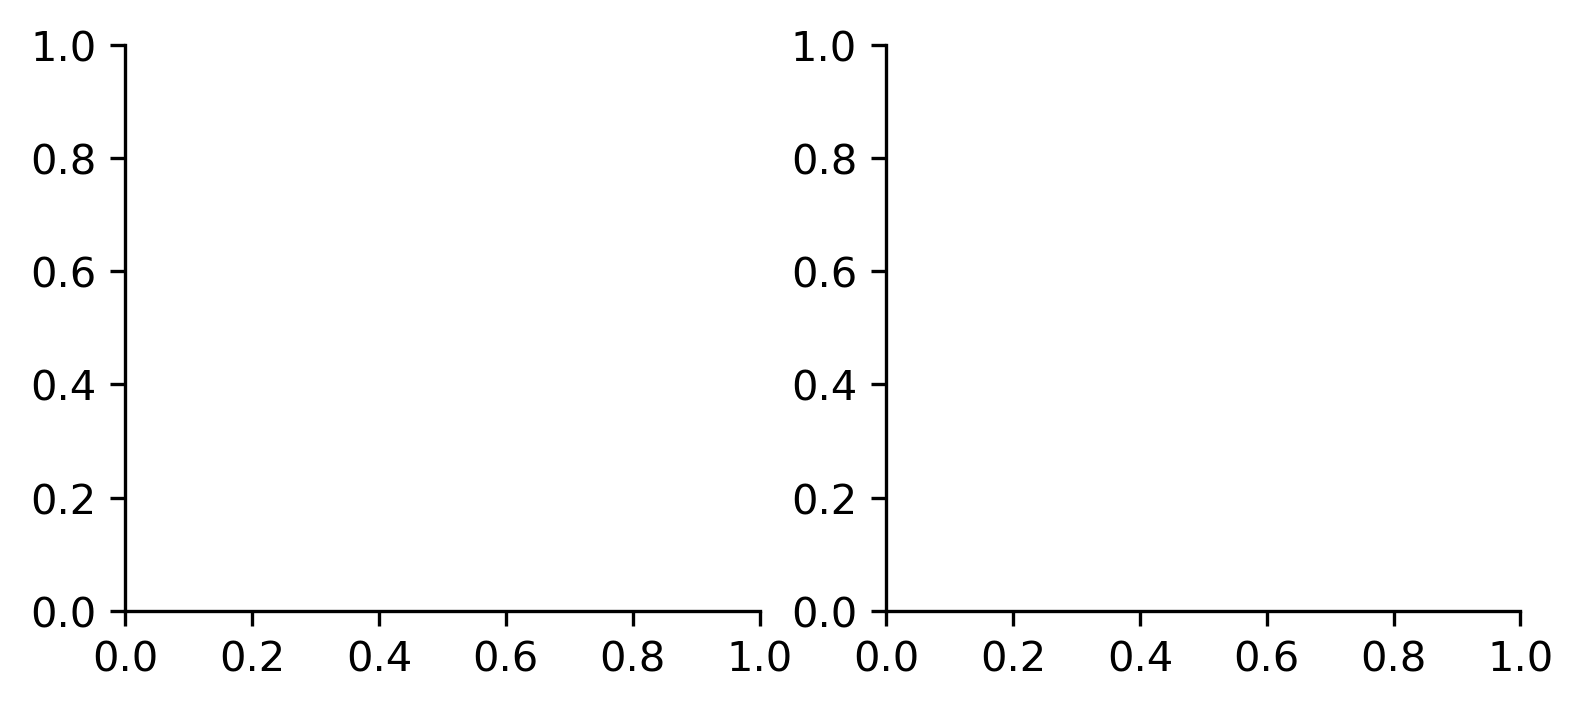

In [119]:
pos_bins = np.arange(-0.016*50, 0.016*50, 0.016)

for f in range(3):

    fig, [ax0, ax1] = plt.subplots(1,2, figsize=(6,2.5), dpi=300)

    pos_bins = np.arange(-0.016*50, 0.016*50, 0.016)

    mean0 = mean_for_sessions[0,:,f].copy(); err0 = err_for_sessions[0,:,f].copy()
    mean1 = mean_for_sessions[1,:,f].copy(); err1 = err_for_sessions[1,:,f].copy()

    ax0.plot(pos_bins, mean0, color='#d8b365', label='left')
    ax0.fill_between(pos_bins, mean0-err0, mean0+err0, alpha=0.5, color='#d8b365')

    ax0.plot(pos_bins, mean1, color='#5ab4ac', label='right')
    ax0.fill_between(pos_bins, mean1-err1, mean1+err1, alpha=0.5, color='#5ab4ac')

    ax0.set_xlim([-0.5,0.5])
    ax0.set_title('gaze-shifting')

    mean0 = mean_for_sessions[2,:,f].copy(); err0 = err_for_sessions[2,:,f].copy()
    mean1 = mean_for_sessions[3,:,f].copy(); err1 = err_for_sessions[3,:,f].copy()

    ax1.plot(pos_bins, mean0, color='#d8b365', label='left')
    ax1.fill_between(pos_bins, mean0-err0, mean0+err0, alpha=0.5, color='#d8b365')

    ax1.plot(pos_bins, mean1, color='#5ab4ac', label='right')
    ax1.fill_between(pos_bins, mean1-err1, mean1+err1, alpha=0.5, color='#5ab4ac')

    ax1.set_xlim([-0.5,0.5])
    ax1.set_title('compensatory')

    ax0.set_xticks(np.linspace(-.5, .5, 5), labels=np.linspace(-500, 500, 5).astype(int))
    ax1.set_xticks(np.linspace(-.5, .5, 5), labels=np.linspace(-500, 500, 5).astype(int))

#     maxlim = [15, 30, 30][f] # 15 or 30

#     ax1.set_ylim([-maxlim,maxlim])
#     ax0.set_ylim([-maxlim,maxlim])

    ax0.set_xlabel('time (ms)')
    ax1.set_xlabel('time (ms)')

    ytext = ['theta', 'head', 'gaze'][f]
    ax0.set_ylabel('{} (deg)'.format(ytext))
    ax1.set_ylabel('{} (deg)'.format(ytext))

    # ax0.axis('off')
    # ax1.axis('off')

    fig.tight_layout()

    fig.savefig(os.path.join(figpath, '0_Sacc_position_{}_LR.pdf'.format(ytext)))

In [ ]:
fig, [ax0, ax1, ax1, ax2] = plt.subplots(2,2, figsize=(6,6), dpi=300)

# left gaze
plt.plot()

# left comp

# right gaze

# right comp

gaze = row['FmLt_gazeshift_{}_saccTimes_dHead1'.format().copy()
comp = row['FmLt_comp_{}_saccTimes_dHead1'.format(row['pref_gazeshift_direction'])].copy()

In [ ]:
len(ltdk.index.values)

In [ ]:
len(ltdk['session'].unique())

In [ ]:
ltdk['gazecluster'].value_counts()/265

# Depth

## fix depth

In [ ]:
# {session name : position of layer 5 (i.e. sites from top of shank)}
# new_depths = {
#     '032022_J599LT_control_Rig2': 22
# }
# for newsession, newdepth in new_depths.items():
#     if len(hffm[hffm['ch']>=64][hffm['session']==newsession].index.values)>0:
#         num_sh = 4
#     else:
#         num_sh = 2
#     for ind, row in hffm[hffm['session']==newsession].iterrows():
#         hffm.at[ind, 'Wn_layer5cent_from_lfp'] = list(np.ones([num_sh]).astype(int)*int(newdepth))
#     for ind, row in hffm[hffm['session']==newsession].iterrows():
#         ch_spacing = 25/2; num_sites = 32
#         ch = row['ch']; ch_shank = int(np.floor(ch/32))
#         layer5cent = row['Wn_layer5cent_from_lfp'][ch_shank]
#         ch_depth = ch_spacing*(ch%32)-(layer5cent*ch_spacing)
#         # print('ind={}, ch={}, sh={}, cent={}, depth={}'.format(ind, ch, ch_shank, layer5cent, ch_depth))
#         hffm.at[ind, 'Wn_depth_from_layer5'] = ch_depth

In [ ]:
fig2 = plt.figure(constrained_layout=True, figsize=(8,3), dpi=300)
fig2spec = gridspec.GridSpec(nrows=1, ncols=6, figure=fig2, wspace=.1, hspace=0)

ax_ex_depth = fig2.add_subplot(fig2spec[0,0])
ax_early_depth = fig2.add_subplot(fig2spec[0,1])
ax_late_depth = fig2.add_subplot(fig2spec[0,2])
ax_biphasic_depth = fig2.add_subplot(fig2spec[0,3])
ax_negative_depth = fig2.add_subplot(fig2spec[0,4])
ax_unresp_depth = fig2.add_subplot(fig2spec[0,5])

mua_power = hffm['Wn_lfp_power'][hffm['session']=='101521_J559NC_control_Rig2'].iloc[0]
layer5 = hffm['Wn_layer5cent_from_lfp'][hffm['session']=='101521_J559NC_control_Rig2'].iloc[0]
ch_spacing = 25
for sh in range(4):
    ax_ex_depth.plot(mua_power[sh], np.arange(0,32)-layer5[sh], 'tab:red')
# ax_ex_depth.set_title('example recording depth')
ax_ex_depth.hlines(0,np.min(mua_power),np.max(mua_power), 'k', linestyle='dashed')
ax_ex_depth.set_ylim([18,-19])
ax_ex_depth.set_yticks(ticks=np.arange(18,-19,-6), labels=(ch_spacing*np.arange(18,-19,-6)))
ax_ex_depth.set_ylabel('depth (um)'); ax_ex_depth.set_xlabel('LFP MUA power')
ax_ex_depth.annotate('layer 5', xy=[0.75, -.5], color='k', fontsize=12)

panels = [ax_early_depth, ax_late_depth, ax_biphasic_depth, ax_negative_depth, ax_unresp_depth]
names = ['early','late','biphasic','negative','unresponsive']

popdata = hffm['Wn_depth_from_layer5'].to_numpy()
pop_weights = np.ones_like(popdata) / float(len(popdata))

for i, panel in enumerate(panels):
    name = names[i]
    panel.hist(popdata, color='k', bins=np.arange(-600,800,100),
               orientation='horizontal',
               histtype='step', linewidth=2, weights=pop_weights)
    
    if i != 4:
        paneldata = hffm['Wn_depth_from_layer5'][hffm['gazecluster']==name][hffm['gazeshift_responsive']].to_numpy()
    else:
        paneldata = hffm['Wn_depth_from_layer5'][hffm['gazecluster']==name].to_numpy()
    panel_weights = np.ones_like(paneldata) / float(len(paneldata))
    
    
    panel.hlines(0, 0, .2, 'k', linestyle='dashed')
    # panel.set_xlim([0,0.3])
    panel.hist(paneldata, color=cat_cmap[name], bins=np.arange(-600,800,100),
               weights=panel_weights, orientation='horizontal', histtype='stepfilled')
    if i==0:
        panel.set_ylabel('depth (um)')
        panel.set_xlabel('fraction of neurons')
    else:
        panel.set_yticklabels([])
        
    panel.set_title(name.capitalize())
    panel.invert_yaxis()
#     panel.set_xlim(0,0.4)

#     panel.set_xticks(np.arange(0.,0.4,.15))
    
fig2.savefig(os.path.join(figpath, 'S1_depth.pdf'))


# Fig 2

## clustering

In [ ]:
hffm['gazecluster'].value_counts()

In [ ]:
fig3A = plt.figure(constrained_layout=True, figsize=(7,3.5), dpi=300)
fig3Aspec = gridspec.GridSpec(nrows=2, ncols=4, figure=fig3A, wspace=0.07, hspace=0.12)

ax_early_l = fig3A.add_subplot(fig3Aspec[0,0])
ax_late_l = fig3A.add_subplot(fig3Aspec[0,1])
ax_biphasic_l = fig3A.add_subplot(fig3Aspec[0,2])
ax_negative_l = fig3A.add_subplot(fig3Aspec[0,3])

ax_early_d = fig3A.add_subplot(fig3Aspec[1,0])
ax_late_d = fig3A.add_subplot(fig3Aspec[1,1])
ax_biphasic_d = fig3A.add_subplot(fig3Aspec[1,2])
ax_negative_d = fig3A.add_subplot(fig3Aspec[1,3])

names = ['early','late','biphasic','negative']
light_panels = [ax_early_l, ax_late_l, ax_biphasic_l, ax_negative_l]
dark_panels = [ax_early_d, ax_late_d, ax_biphasic_d, ax_negative_d]

for count, name in enumerate(names):
    lpanel = light_panels[count]; dpanel = dark_panels[count]
    dpanel.axis('off')
    
    for x in hffm['pref_gazeshift_psth'][hffm['gazecluster']==name]:
        lpanel.plot(psth_bins, x, '-', linewidth=1, alpha=.3)
    lpanel.plot(psth_bins, np.nanmean(flatten_series(hffm['pref_gazeshift_psth'][hffm['gazecluster']==name]),0), '-', linewidth=3, color=cat_cmap[name])
    lpanel.set_xlim([-0.2,0.4]); lpanel.set_ylim([-1,1])
#     lpanel.set_title(name.capitalize())
    lpanel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
    lpanel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
    
    # for x in ltdk['pref_dark_gazeshift_psth'][ltdk['gazecluster']==name]:
    #     dpanel.plot(psth_bins, x, '-', linewidth=1, alpha=.3)
    # dpanel.plot(psth_bins, np.nanmean(flatten_series(ltdk['pref_dark_gazeshift_psth'][ltdk['gazecluster']==name][ltdk['gazeshift_responsive']==True][ltdk['movement']==False]),0), '-', linewidth=3, color=cat_cmap[name])
    # dpanel.set_xlim([-0.2,0.4]); dpanel.set_ylim([-1,1])
    # dpanel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
    # dpanel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
    
    if name=='early':
        lpanel.set_ylabel('norm sp/s')
        # dpanel.set_ylabel('norm. spike rate')
    if name!='early':
        lpanel.set_yticklabels([])
        # dpanel.set_yticklabels([])
    # lpanel.set_xticklabels([])
    lpanel.set_xlabel('time (msec)')
    lpanel.set_title(name)
        
fig3A.savefig(os.path.join(figpath, '2_clustering.pdf'))

In [ ]:
fig2 = plt.figure(constrained_layout=False, figsize=(9,7), dpi=300)
fig2spec = gridspec.GridSpec(nrows=5, ncols=5, figure=fig2, wspace=1, hspace=1.2)

fig2Aspec = gridspec.GridSpecFromSubplotSpec(4,2, subplot_spec=fig2spec[:,0:2], wspace=0.8, hspace=1)
ax_early = fig2.add_subplot(fig2Aspec[0,0])
ax_late = fig2.add_subplot(fig2Aspec[0,1])
ax_biphasic = fig2.add_subplot(fig2Aspec[1,0])
ax_negative = fig2.add_subplot(fig2Aspec[1,1])
ax_clusters = fig2.add_subplot(fig2Aspec[2:,:])

panels = [ax_early, ax_late, ax_biphasic, ax_negative]
movtypes = ['early','late','biphasic','negative']
for count, panel in enumerate(panels):
    movtype = movtypes[count]
    thisclust = hffm['pref_gazeshift_psth'][hffm['gazecluster']==movtype][hffm['gazeshift_responsive']]
    for i, psth in enumerate(thisclust):
        panel.plot(psth_bins, psth, '-', linewidth=1, alpha=0.25)
    clustmean = np.nanmean(flatten_series(thisclust),0)
    panel.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[movtype])
    panel.set_xlim([-0.2,0.4])
    panel.set_title(movtype.capitalize())
    panel.set_ylim([-1,1])
    if count == 0 or count == 2:
        panel.set_ylabel('norm. spike rate')
#     else:
#         panel.set_yticklabels([])
    if count == 3 or count == 2:
        panel.set_xlabel('time (msec)')
    panel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
#     else:
#         panel.set_xticks([])
    panel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
ax_early.set_ylim([-0.3,1])
ax_late.set_ylim([-0.3,1])
ax_biphasic.set_ylim([-0.6,0.9])
ax_negative.set_ylim([-.9,0.7])

ax_late.set_yticks(np.linspace(0,1,3))
ax_early.set_yticks(np.linspace(0,1,3))
    

step = 0.13
names = ['early','late','biphasic','negative'] # 'unresponsive',
for count, name in enumerate(names):
    cluster_psths = flatten_series(hffm['pref_gazeshift_psth'][hffm['gazecluster']==name])
    clustmean = np.nanmean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.3)
ax_clusters.set_xlim([-0.2,0.4]); ax_clusters.set_ylim([-.6,.6])
# ax_clusters.annotate('early', xy=[0.19,-0.22], color=cat_cmap['early'], fontsize=11)
# ax_clusters.annotate('late', xy=[0.19,-0.22-(step*1)], color=cat_cmap['late'], fontsize=11)
# ax_clusters.annotate('biphasic', xy=[0.19,-0.22-(step*2)], color=cat_cmap['biphasic'], fontsize=11)
# ax_clusters.annotate('negative', xy=[0.19,-0.22-(step*3)], color=cat_cmap['negative'], fontsize=11)
ax_clusters.set_ylabel('norm. spike rate'); ax_clusters.set_xlabel('time (msec)')
ax_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
ax_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_clusters.set_yticks(np.linspace(-0.5,0.5,3))

# plot_cprop_scatter(ax_baseline_fr, 'psth_baseline', use_median=True)
# ax_baseline_fr.set_ylabel('baseline (sp/sec)')
# ax_baseline_fr.set_ylim([0,50])

fig2.savefig(os.path.join(figpath, '2_clustering.pdf'))

## Supp. firing rate and cluster sizes

In [ ]:
fig, [ax_cellcounts, ax_baseline_fr] = plt.subplots(1,2, figsize=(5.5,2.5), dpi=300)

vcounts = hffm['gazecluster'].value_counts()
names = ['early','late','biphasic','negative','unresponsive']
print_names = ['early','late','biph','neg','unresp']
for i, name in enumerate(names):
    ax_cellcounts.bar(i, vcounts[name]/np.sum(vcounts), color=cat_cmap[name])
ax_cellcounts.set_xticks(ticks=range(5), labels=print_names, rotation=90)
ax_cellcounts.set_ylabel('frac. cells')

for i, name in enumerate(names):
    baselines = hffm['FmLt_gazeshift_med_baseline'][hffm['gazecluster']==name].to_numpy()
    err = np.std(baselines) / np.sqrt(np.size(baselines))
    med = np.median(baselines)
    ax_baseline_fr.bar(i, med, color=cat_cmap[name])
    ax_baseline_fr.plot([i, i], [med-err, med+err], 'k-')
ax_baseline_fr.set_xticks(range(5), print_names, rotation=90)
ax_baseline_fr.set_ylabel('baseline (sp/s)')

fig.tight_layout()
fig.savefig(os.path.join(figpath, 'S1_frac_and_rate.pdf'))

## comp clusters

In [ ]:
fig, ax_clusters = plt.subplots(1,1,figsize=(3,3), dpi=300)

names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    cluster_psths = flatten_series(hffm['pref_comp_psth'][hffm['gazecluster']==name][hffm['gazeshift_responsive']])
    cluster_psths = drop_nan_along(cluster_psths)
    clustmean = np.nanmean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2)
ax_clusters.set_xlim([-0.2,0.4]); ax_clusters.set_ylim([-.6,.6])
ax_clusters.set_ylabel('norm. spike rate'); ax_clusters.set_xlabel('time (msec)')
ax_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
ax_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_clusters.set_yticks(np.linspace(-0.5,0.5,3))

fig.savefig(os.path.join(figpath, '2_comp.pdf'))

## Fig 2: temporal sequences

In [ ]:
num_responsive = len(hffm[hffm['gazecluster']!='unresponsive'][hffm['gazeshift_responsive']==True][hffm['movement']==False].to_numpy())
num_responsive

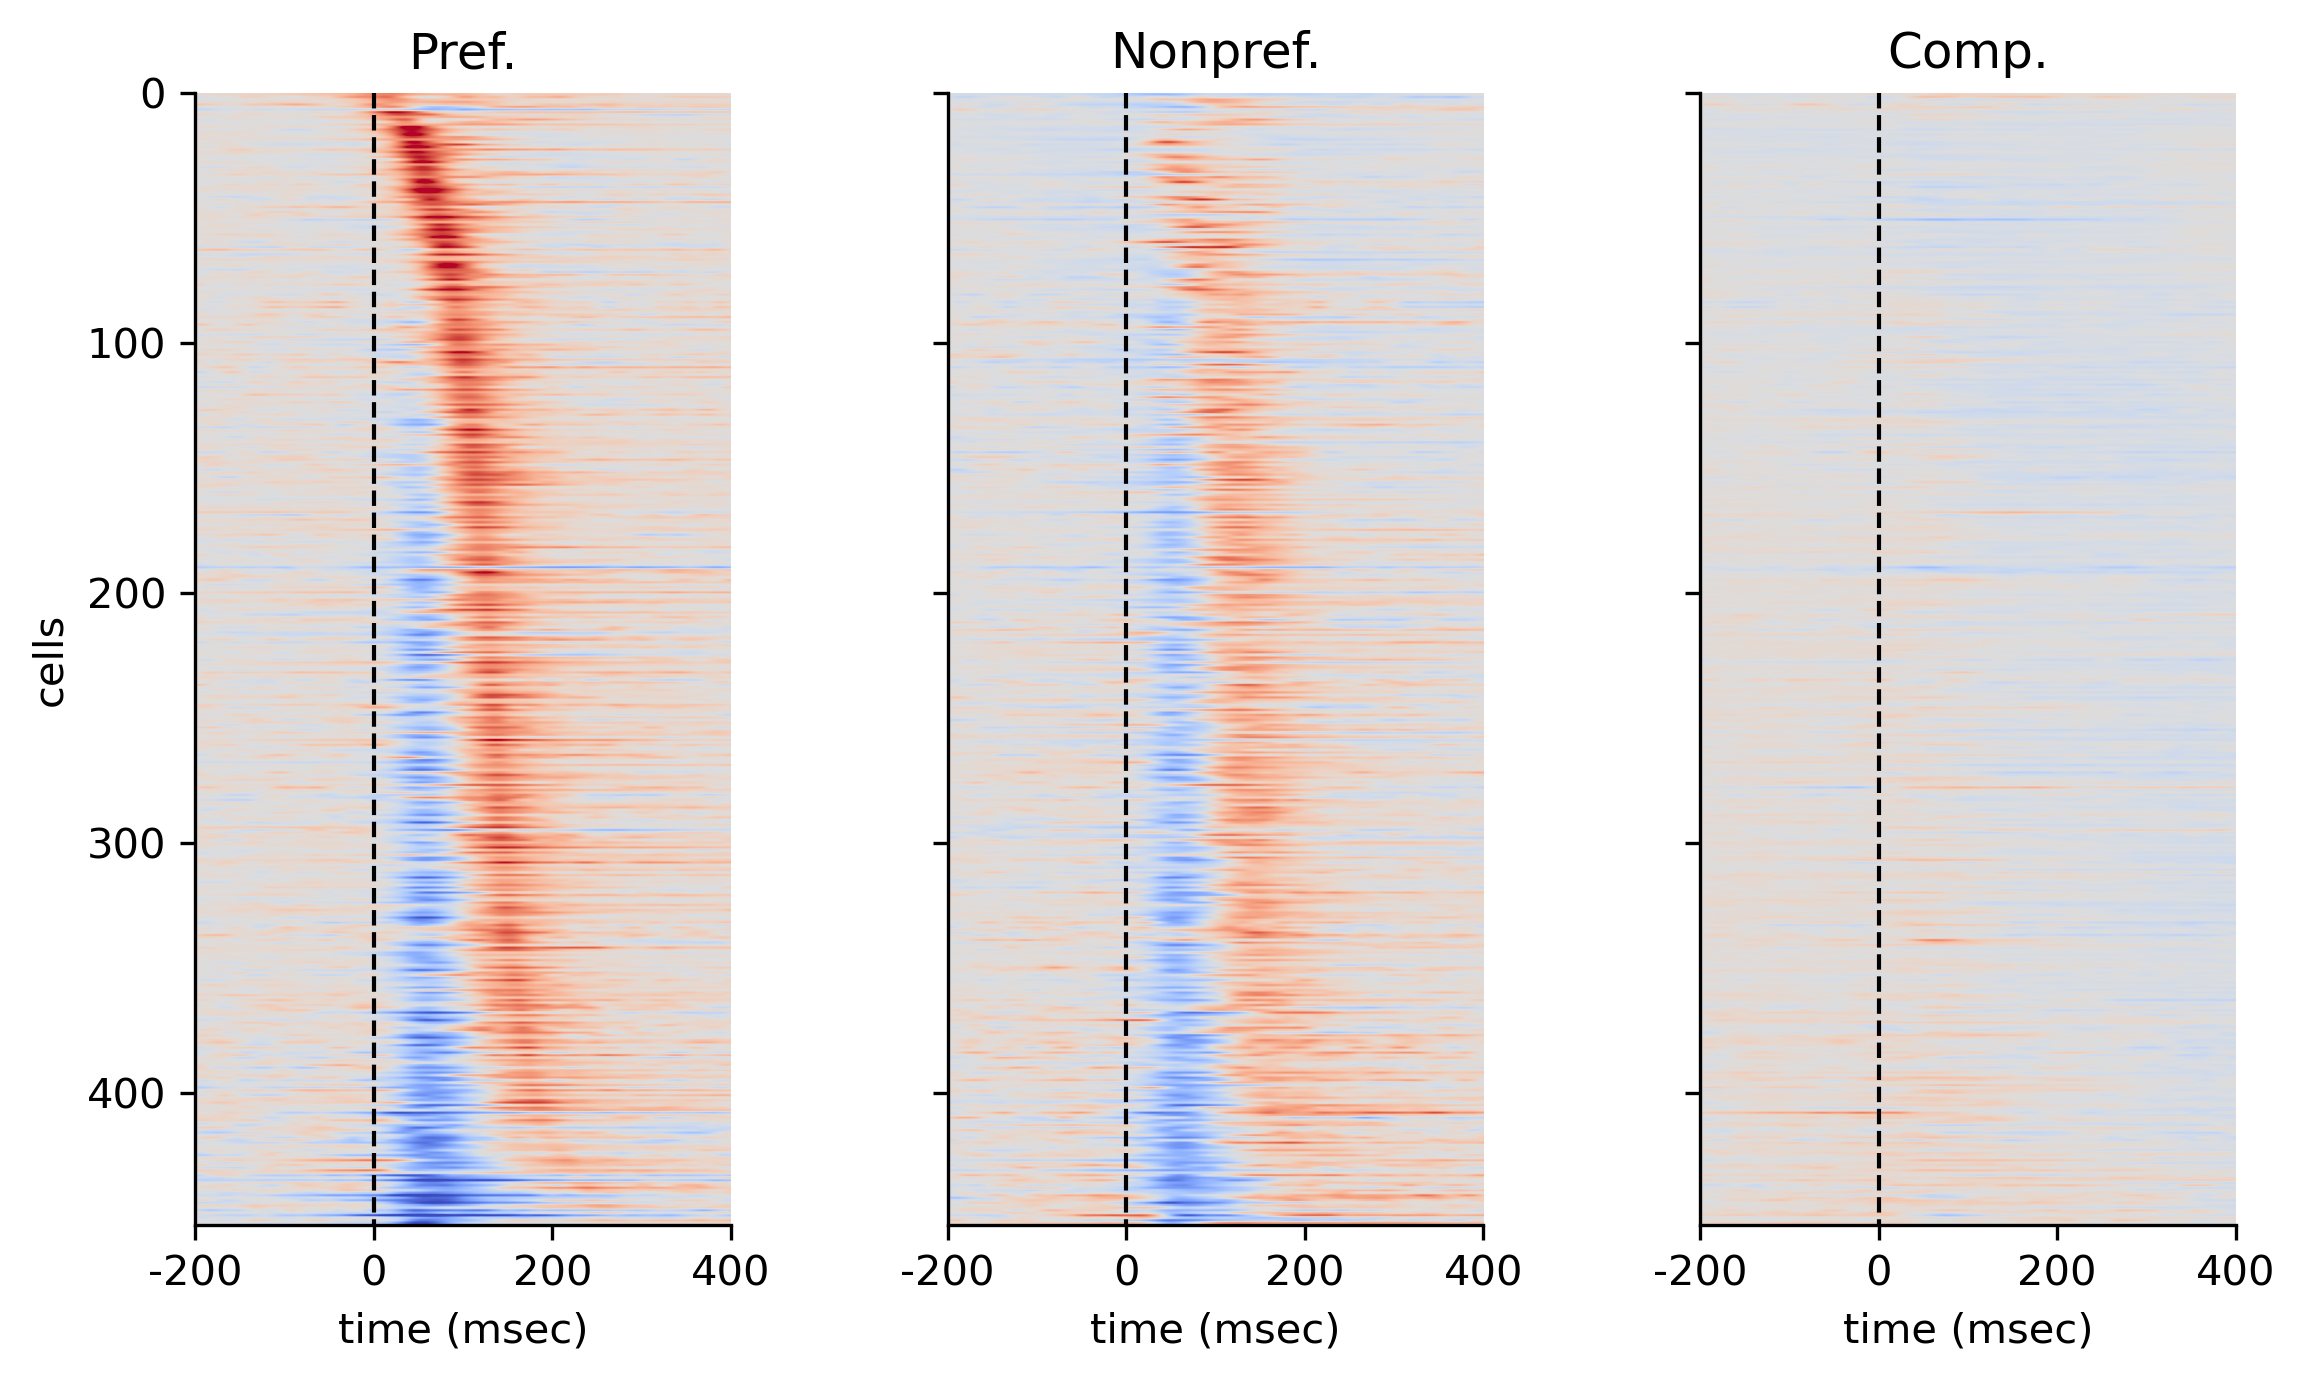

In [56]:
fig2p2 = plt.figure(constrained_layout=False, figsize=(9,5), dpi=300)

fig2p2A = gridspec.GridSpec(1,3, figure=fig2p2, wspace=.28, hspace=.1)
ax_tseq_pref = fig2p2.add_subplot(fig2p2A[:,0])
ax_tseq_nonpref = fig2p2.add_subplot(fig2p2A[:,1])
ax_tseq_comp = fig2p2.add_subplot(fig2p2A[:,2])

tseq_aspect = 2.8
img = plot_tempseq(ax_tseq_pref, tseq_pref, return_img=True)
ax_tseq_pref.set_aspect(tseq_aspect)
ax_tseq_pref.set_title('Pref.')
ax_tseq_pref.set_ylabel('cells')
# ax_tseq_pref.hlines(num_responsive, 800,1400,'k',linestyle='dashed', linewidth=1)

plot_tempseq(ax_tseq_nonpref, tseq_nonpref)
ax_tseq_nonpref.set_aspect(tseq_aspect)
ax_tseq_nonpref.set_title('Nonpref.')
ax_tseq_nonpref.set_yticklabels([])
# ax_tseq_nonpref.hlines(num_responsive, 800,1400,'k',linestyle='dashed', linewidth=1)

plot_tempseq(ax_tseq_comp, tseq_comp)
ax_tseq_comp.set_aspect(tseq_aspect)
ax_tseq_comp.set_title('Comp.')
ax_tseq_comp.set_yticklabels([])
# ax_tseq_comp.hlines(num_responsive, 800,1400,'k',linestyle='dashed', linewidth=1)

fig2p2.savefig(os.path.join(figpath, '2_temporal_seq.pdf'))

## Fig 2 temp seq scale bar

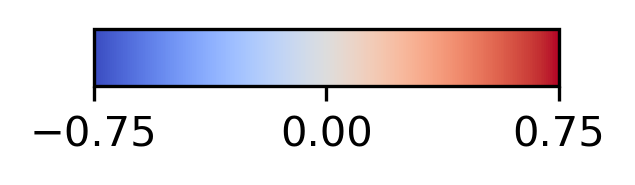

In [57]:
fig, ax = plt.subplots(figsize=(2,.25), dpi=300)
plt.colorbar(img, cax=ax, aspect=10, orientation='horizontal')
plt.xticks(np.linspace(-0.75,0.75,3))
# ax.xaxis.set_tick_params(width=2)
plt.savefig(os.path.join(figpath, '2_seq_legend.pdf'), bbox_inches='tight', pad_inches=.5)

# Fig 3

## ltdk temp seq

In [415]:
for ind in ltdk.index.values:
    Lt_peakT, Lt_peakVal = calc_latency(ltdk.loc[ind,'pref_gazeshift_psth'])
    
    ltdk.at[ind, 'FmLt_gazeshift_peakT'] = Lt_peakT

In [416]:
for ind in ltdk.index.values:
    sorted_df = ltdk[['FmLt_gazeshift_peakT','FmDk_gazeshift_peakT','FmLt_gazeshift_troughT','FmDk_gazeshift_troughT','gazecluster',
                      'pref_gazeshift_psth','pref_dark_gazeshift_psth','nonpref_dark_gazeshift_psth','gazeshift_responsive',
                      'pref_dark_comp_psth']].copy()

# shuffle unresponsive cells
tseq_unresp = sorted_df.copy()
tseq_unresp = tseq_unresp[tseq_unresp['gazecluster']=='unresponsive'].sample(frac=1).reset_index(drop=True)
tseq_l_unresp = flatten_series(tseq_unresp['pref_gazeshift_psth'].copy())
tseq_d_unresp = flatten_series(tseq_unresp['pref_dark_gazeshift_psth'].copy())
    
# sort dark by dark times
tseq_dark_sort = sorted_df.copy()
tseq_dark_sort = tseq_dark_sort[tseq_dark_sort['gazecluster']!='unresponsive']
tseq_dark_sort.sort_values(by='FmDk_gazeshift_peakT', inplace=True)

tseq_dark_by_dark = np.vstack([flatten_series(tseq_dark_sort['pref_dark_gazeshift_psth'].copy()), tseq_d_unresp])

# sort light/dark by light times
sort_by_light = sorted_df.copy()
sort_by_light = sort_by_light[sort_by_light['gazecluster']!='unresponsive']
sort_by_light.sort_values(by='FmLt_gazeshift_peakT', inplace=True)

tseq_light = flatten_series(sort_by_light['pref_gazeshift_psth'].copy())
tseq_dark_pref = flatten_series(sort_by_light['pref_dark_gazeshift_psth'].copy())
tseq_dark_nonpref = flatten_series(sort_by_light['nonpref_dark_gazeshift_psth'].copy())
tseq_dark_comp = flatten_series(sort_by_light['pref_dark_comp_psth'].copy())

tseq_light1 = np.vstack([flatten_series(sort_by_light['pref_gazeshift_psth'].copy()), tseq_l_unresp])
tseq_dark_pref1 = np.vstack([flatten_series(sort_by_light['pref_dark_gazeshift_psth'].copy()), tseq_d_unresp])
tseq_dark_nonpref1 = np.vstack([flatten_series(sort_by_light['nonpref_dark_gazeshift_psth'].copy()), tseq_d_unresp])
tseq_dark_comp1 = np.vstack([flatten_series(sort_by_light['pref_dark_comp_psth'].copy()), tseq_d_unresp])

In [ ]:
num_responsive = len(ltdk[ltdk['gazecluster']!='unresponsive'].to_numpy())
num_responsive

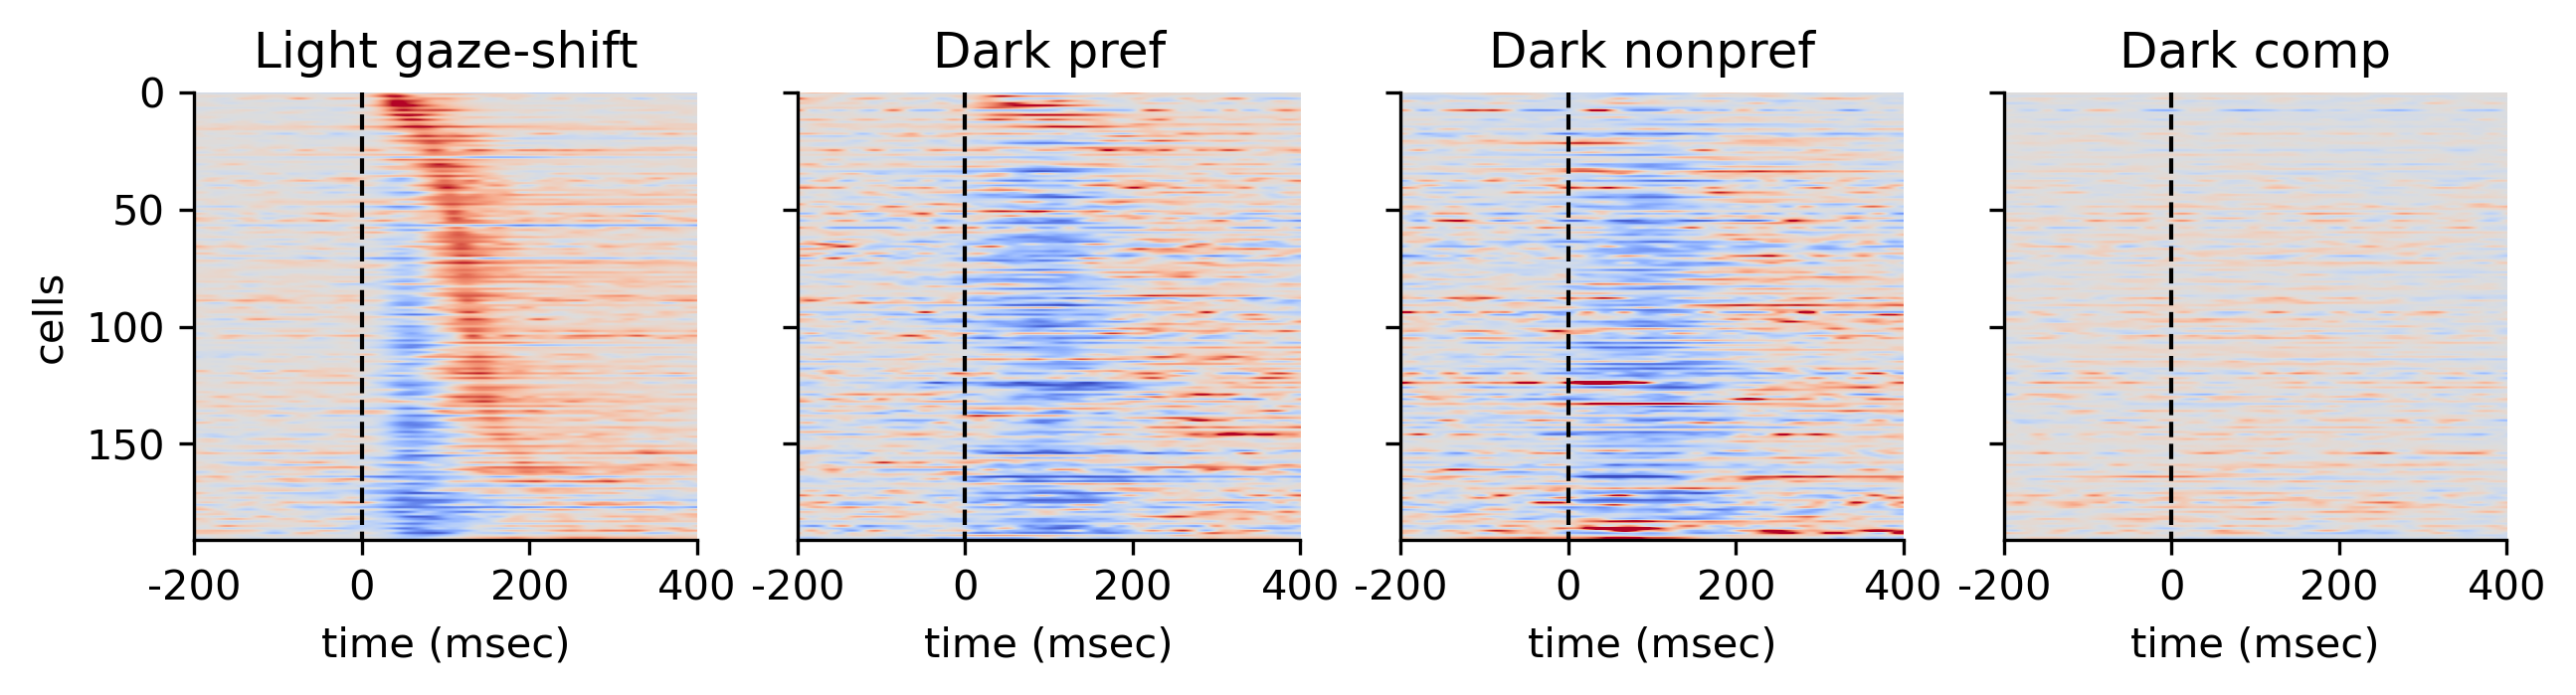

In [418]:
tseq_aspect = 2.8

fig, [ax0, ax1, ax2, ax3] = plt.subplots(1,4,figsize=(10,5), dpi=300)

plot_tempseq(ax0, tseq_light)
ax0.set_aspect(tseq_aspect)
ax0.set_title('Light gaze-shift')
ax0.set_ylabel('cells')
# ax0.hlines(num_responsive, 800,1400,'k',linestyle='dashed', linewidth=1)

plot_tempseq(ax1, tseq_dark_pref)
ax1.set_aspect(tseq_aspect)
ax1.set_title('Dark pref')
ax1.set_yticklabels([])
# ax1.hlines(num_responsive, 800,1400,'k',linestyle='dashed', linewidth=1)

plot_tempseq(ax2, tseq_dark_nonpref)
ax2.set_aspect(tseq_aspect)
ax2.set_title('Dark nonpref')
ax2.set_yticklabels([])
# ax2.hlines(num_responsive, 800,1400,'k',linestyle='dashed', linewidth=1)

plot_tempseq(ax3, tseq_dark_comp)
ax3.set_aspect(tseq_aspect)
ax3.set_title('Dark comp')
ax3.set_yticklabels([])
# ax3.hlines(num_responsive, 800,1400,'k',linestyle='dashed', linewidth=1)

fig.savefig(os.path.join(figpath, '3_temporal_seq.pdf'))

In [ ]:
# np.argmin(np.sum(tseq_dark_nonpref1,1))

## ltdk clustering

In [ ]:
fig3A = plt.figure(constrained_layout=True, figsize=(7,3.5), dpi=300)
fig3Aspec = gridspec.GridSpec(nrows=2, ncols=4, figure=fig3A, wspace=0.07, hspace=0.12)

ax_early_l = fig3A.add_subplot(fig3Aspec[0,0])
ax_late_l = fig3A.add_subplot(fig3Aspec[0,1])
ax_biphasic_l = fig3A.add_subplot(fig3Aspec[0,2])
ax_negative_l = fig3A.add_subplot(fig3Aspec[0,3])

ax_early_d = fig3A.add_subplot(fig3Aspec[1,0])
ax_late_d = fig3A.add_subplot(fig3Aspec[1,1])
ax_biphasic_d = fig3A.add_subplot(fig3Aspec[1,2])
ax_negative_d = fig3A.add_subplot(fig3Aspec[1,3])

names = ['early','late','biphasic','negative']
light_panels = [ax_early_l, ax_late_l, ax_biphasic_l, ax_negative_l]
dark_panels = [ax_early_d, ax_late_d, ax_biphasic_d, ax_negative_d]

for count, name in enumerate(names):
    lpanel = light_panels[count]; dpanel = dark_panels[count]
    
    for x in ltdk['pref_gazeshift_psth'][ltdk['gazecluster']==name]:
        lpanel.plot(psth_bins, x, '-', linewidth=1, alpha=.3)
    lpanel.plot(psth_bins, np.nanmean(flatten_series(ltdk['pref_gazeshift_psth'][ltdk['gazecluster']==name][ltdk['gazeshift_responsive']==True]),0), '-', linewidth=3, color=cat_cmap[name])
    lpanel.set_xlim([-0.2,0.4]); lpanel.set_ylim([-1,1])
#     lpanel.set_title(name.capitalize())
    lpanel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
    lpanel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
    
    for x in ltdk['pref_dark_gazeshift_psth'][ltdk['gazecluster']==name]:
        dpanel.plot(psth_bins, x, '-', linewidth=1, alpha=.3)
    dpanel.plot(psth_bins, np.nanmean(flatten_series(ltdk['pref_dark_gazeshift_psth'][ltdk['gazecluster']==name][ltdk['gazeshift_responsive']==True]),0), '-', linewidth=3, color=cat_cmap[name])
    dpanel.set_xlim([-0.2,0.4]); dpanel.set_ylim([-1,1])
    dpanel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
    dpanel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
    
    if name=='early':
        lpanel.set_ylabel('norm. spike rate')
        # dpanel.set_ylabel('norm. spike rate')
    if name!='early':
        lpanel.set_yticklabels([])
        dpanel.set_yticklabels([])
    lpanel.set_xticklabels([])
    dpanel.set_xlabel('time (msec)')
    lpanel.set_title(name)
        
fig3A.savefig(os.path.join(figpath, '3_clustering.pdf'))

## ltdk cluster summary

In [ ]:
fig3B = plt.figure(constrained_layout=True, figsize=(5.5,2.5), dpi=300)
fig3Bspec = gridspec.GridSpec(nrows=1, ncols=2, figure=fig3B, wspace=0.01, hspace=0)

ax_light_clusters = fig3B.add_subplot(fig3Bspec[:,0])
ax_dark_clusters = fig3B.add_subplot(fig3Bspec[:,1])

step = 0.14
names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    data = ltdk[ltdk['gazecluster']==name]
    cluster_psths = flatten_series(data['pref_gazeshift_psth'])
    clustmean = np.nanmean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_light_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_light_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2) 
ax_light_clusters.set_xlim([-0.2,0.4]); ax_light_clusters.set_ylim([-.6,.6])
# ax_dark_clusters.annotate('early', xy=[0.3,-0.22], color=cat_cmap['early'], fontsize=11)
# ax_dark_clusters.annotate('late', xy=[0.3,-0.22-(step*1)], color=cat_cmap['late'], fontsize=11)
# ax_dark_clusters.annotate('biphasic', xy=[0.3,-0.22-(step*2)], color=cat_cmap['biphasic'], fontsize=11)
# ax_dark_clusters.annotate('negative', xy=[0.3,-0.22-(step*3)], color=cat_cmap['negative'], fontsize=11)
ax_light_clusters.set_ylabel('norm. spike rate'); ax_light_clusters.set_xlabel('time (msec)')
ax_light_clusters.set_title('Light gaze shift')
ax_light_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_light_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_light_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

for count, name in enumerate(names):
    data = ltdk[ltdk['gazecluster']==name]
    cluster_psths = flatten_series(data['pref_dark_gazeshift_psth'])
    clustmean = np.nanmean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_dark_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_dark_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.3) 
ax_dark_clusters.set_xlim([-0.2,0.4]); ax_dark_clusters.set_ylim([-.6,.6]); ax_dark_clusters.set_xlabel('time (msec)')
ax_dark_clusters.set_title('Dark gaze shift')
ax_dark_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_dark_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_dark_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

fig3B.savefig(os.path.join(figpath, '3_cluster_summary_noUnresp.pdf'))

## ltdk comp summary

In [ ]:
fig3B = plt.figure(constrained_layout=True, figsize=(5.5,2.5), dpi=300)
fig3Bspec = gridspec.GridSpec(nrows=1, ncols=2, figure=fig3B, wspace=0.01, hspace=0)

ax_light_clusters = fig3B.add_subplot(fig3Bspec[:,0])
ax_dark_clusters = fig3B.add_subplot(fig3Bspec[:,1])

step = 0.14
names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    data = ltdk[ltdk['gazecluster']==name]
    cluster_psths = flatten_series(data['pref_comp_psth'][ltdk['movement']==False])
    clustmean = np.nanmean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_light_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_light_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2) 
ax_light_clusters.set_xlim([-0.2,0.4]); ax_light_clusters.set_ylim([-.6,.6])
# ax_dark_clusters.annotate('early', xy=[0.3,-0.22], color=cat_cmap['early'], fontsize=11)
# ax_dark_clusters.annotate('late', xy=[0.3,-0.22-(step*1)], color=cat_cmap['late'], fontsize=11)
# ax_dark_clusters.annotate('biphasic', xy=[0.3,-0.22-(step*2)], color=cat_cmap['biphasic'], fontsize=11)
# ax_dark_clusters.annotate('negative', xy=[0.3,-0.22-(step*3)], color=cat_cmap['negative'], fontsize=11)
ax_light_clusters.set_ylabel('norm. spike rate');# ax_light_clusters.set_xlabel('time (msec)')
ax_light_clusters.set_title('light compensatory')
# ax_light_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_light_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=[])
ax_light_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_light_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

for count, name in enumerate(names):
    data = ltdk[ltdk['gazecluster']==name]
    cluster_psths = flatten_series(data['pref_dark_comp_psth'][ltdk['movement']==False])
    clustmean = np.nanmean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_dark_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_dark_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.3) 
ax_dark_clusters.set_xlim([-0.2,0.4]); ax_dark_clusters.set_ylim([-.6,.6]); ax_dark_clusters.set_xlabel('time (msec)')
ax_dark_clusters.set_title('dark compensatory')
ax_dark_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_dark_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_dark_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

fig3B.savefig(os.path.join(figpath, '3_comp_summary.pdf'))

## temp seq legned

In [ ]:
tseq_legend_col = sort_by_light['gazecluster'].copy()
tseq_legend = np.zeros([len(tseq_legend_col.index.values), 1, 4])
for i, n in enumerate(tseq_legend_col):
    tseq_legend[i,:,:] = mpl.colors.to_rgba(cat_cmap[n])
ucmap = mpl.colors.to_rgba(cat_cmap['unresponsive'])
u = np.zeros([np.size(tseq_l_unresp,0), 1, 4])
for x in range(4):
    u[:,:,x] = ucmap[x]
tseq_legend1 = np.vstack([tseq_legend, u])

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(0.5,2), dpi=300)
ax.imshow(tseq_legend1, aspect=.05)
ax.set_yticks([]); ax.set_xticks([])
ax.axes.spines.bottom.set_visible(False)
ax.axes.spines.right.set_visible(False)
ax.axes.spines.left.set_visible(False)
ax.axes.spines.top.set_visible(False)
fig.savefig(os.path.join(figpath, '3_temp_seq_legend.pdf'))

## dark responsive

In [ ]:
# for ind, row in ltdk[['pref_dark_gazeshift_psth','pref_gazeshift_psth']].iterrows():
#     r = np.corrcoef(row['pref_gazeshift_psth'].astype(float)[1000:1250], row['pref_dark_gazeshift_psth'].astype(float)[1000:1250])
#     ltdk.at[ind, 'gaze_ltdk_maxcc'] = r[0,1]

In [4]:
def calc_psth_DSI(pref, nonpref):
    prefmod = psth_modind(pref)
    nonprefmod = psth_modind(nonpref)
    mod = (prefmod - nonprefmod) / (prefmod + nonprefmod)
    return mod

In [508]:
for ind, row in ltdk.iterrows():
    sec = row['FmDk_eyeT'][-1].astype(float) - row['FmDk_eyeT'][0].astype(float)
    sp = len(row['FmDk_spikeT'])
    fm_fr = sp/sec
    ltdk.at[ind, 'FmDk_fr'] = fm_fr
    
    ltdk.at[ind, 'norm_mod_at_pref_peak_dark'] = psth_modind(row['pref_dark_gazeshift_psth'])
    
    ltdk.at[ind, 'raw_mod_at_pref_peak_dark'] = psth_modind(row['pref_dark_gazeshift_psth_raw'])
    
    ltdk.at[ind, 'norm_mod_at_pref_peak'] = psth_modind(row['pref_gazeshift_psth'])
    
    ltdk.at[ind, 'raw_mod_at_pref_peak'] = psth_modind(row['pref_gazeshift_psth_raw'])
    
    
    peakT, peak_val = calc_latency(row['pref_dark_gazeshift_psth'])
    ltdk.at[ind, 'dark_peak_val'] = peak_val
    ltdk.at[ind, 'dark_peakT'] = peakT
    

In [ ]:
[ltdk['dark_peak_val']>0.5]

9


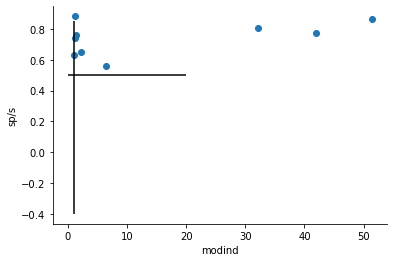

In [82]:
use_show = (ltdk['norm_mod_at_pref_peak_dark']>0.1) * (ltdk['dark_peakT']<.1) * (ltdk['raw_mod_at_pref_peak_dark']>1) * (ltdk['dark_peak_val']>0.5)

plt.scatter(ltdk['raw_mod_at_pref_peak_dark'][use_show], ltdk['dark_peak_val'][use_show])
plt.vlines(1, -0.4,0.85, 'k')
plt.hlines(0.5, -0,20, 'k')
plt.xlabel('modind')
plt.ylabel('sp/s')

print(np.sum(use_show))

(-0.2, 0.4)

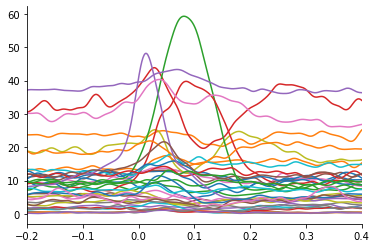

In [81]:
for ind in use_show[use_show==True].index.values:
    plt.plot(psth_bins, ltdk.loc[ind, 'pref_dark_gazeshift_psth_raw'])
plt.xlim([-.2,.4])
# plt.ylim([0,8])

In [46]:
ltdk['dark_peak_val'][ltdk['norm_mod_at_pref_peak_dark']>0.1][ltdk['dark_peakT']<.1][ltdk['raw_mod_at_pref_peak_dark']>1]

11     0.079531
15     0.040961
16     0.208543
22     0.262740
23     0.021717
24     0.220228
25     0.336784
34     0.738400
40     0.271924
49     0.648994
52     0.043011
53     0.227005
61     0.867017
73     0.806971
74     0.156776
80    -0.096149
83     0.333018
84     0.111499
102    0.367756
116    0.257410
125    0.281119
128    0.219679
146    0.117411
147    0.189515
156    0.770637
162    0.453498
164    0.291836
174    0.632321
175    0.093445
179    0.143941
183    0.562590
188    0.760559
200    0.291535
211   -0.224518
216    0.882077
241    0.037469
248   -0.032048
262   -0.009447
Name: dark_peak_val, dtype: float64

(-0.3, 0.5)

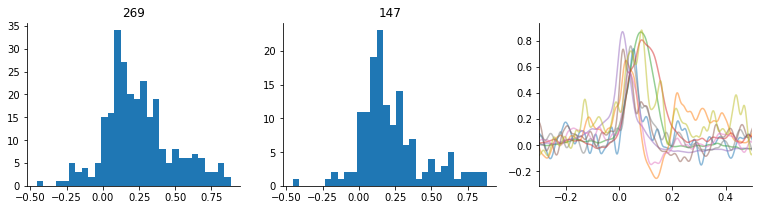

In [7]:
plt.subplots(1,3, figsize=(13,3))
plt.subplot(1,3,1)
vals = ltdk['dark_peak_val']
plt.hist(vals, bins=30)
plt.title(len(vals))

plt.subplot(1,3,2)
vals = ltdk['dark_peak_val'][ltdk['norm_mod_at_pref_peak_dark']>0.1][ltdk['raw_mod_at_pref_peak_dark']>1]
plt.hist(vals, bins=30)
plt.title(len(vals))

plt.subplot(1,3,3)
vals = ltdk[ltdk['norm_mod_at_pref_peak_dark']>0.1][ltdk['raw_mod_at_pref_peak_dark']>1][ltdk['dark_peak_val']>0.5][ltdk['dark_peakT']<.1]
for ind in vals.index.values:
    plt.plot(psth_bins, ltdk.loc[ind, 'pref_dark_gazeshift_psth'], alpha=0.5)
plt.xlim([-.3,.5])

In [509]:
vals = ltdk[ltdk['norm_mod_at_pref_peak_dark']>0.1][ltdk['raw_mod_at_pref_peak_dark']>1][ltdk['dark_peak_val']>0.5][ltdk['dark_peakT']<.1]

/tmp/ipykernel_32029/3824967791.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vals = ltdk[ltdk['norm_mod_at_pref_peak_dark']>0.1][ltdk['raw_mod_at_pref_peak_dark']>1][ltdk['dark_peak_val']>0.5][ltdk['dark_peakT']<.1]


In [510]:
ltdk['dark_responsive'] = False
for ind in vals.index.values:
    ltdk.at[ind, 'dark_responsive'] = True

In [511]:
len(ltdk[ltdk['dark_responsive']==True].index.values)

9

In [ ]:
ltdk['gazecluster'][ltdk['dark_responsive']]

In [ ]:
plt.plot(ltdk.loc[174, 'pref_dark_gazeshift_psth'])

In [ ]:
9/269

In [ ]:
for x in vals['pref_gazeshift_psth']:
    plt.plot(psth_bins, x)
plt.xlim([-.2,.2])

In [ ]:
for x in vals['nonpref_gazeshift_psth']:
    plt.plot(psth_bins, x)
plt.xlim([-.2,.2])

In [ ]:
vals['FmLt_gaze_DSI']

## ltdk firing rates

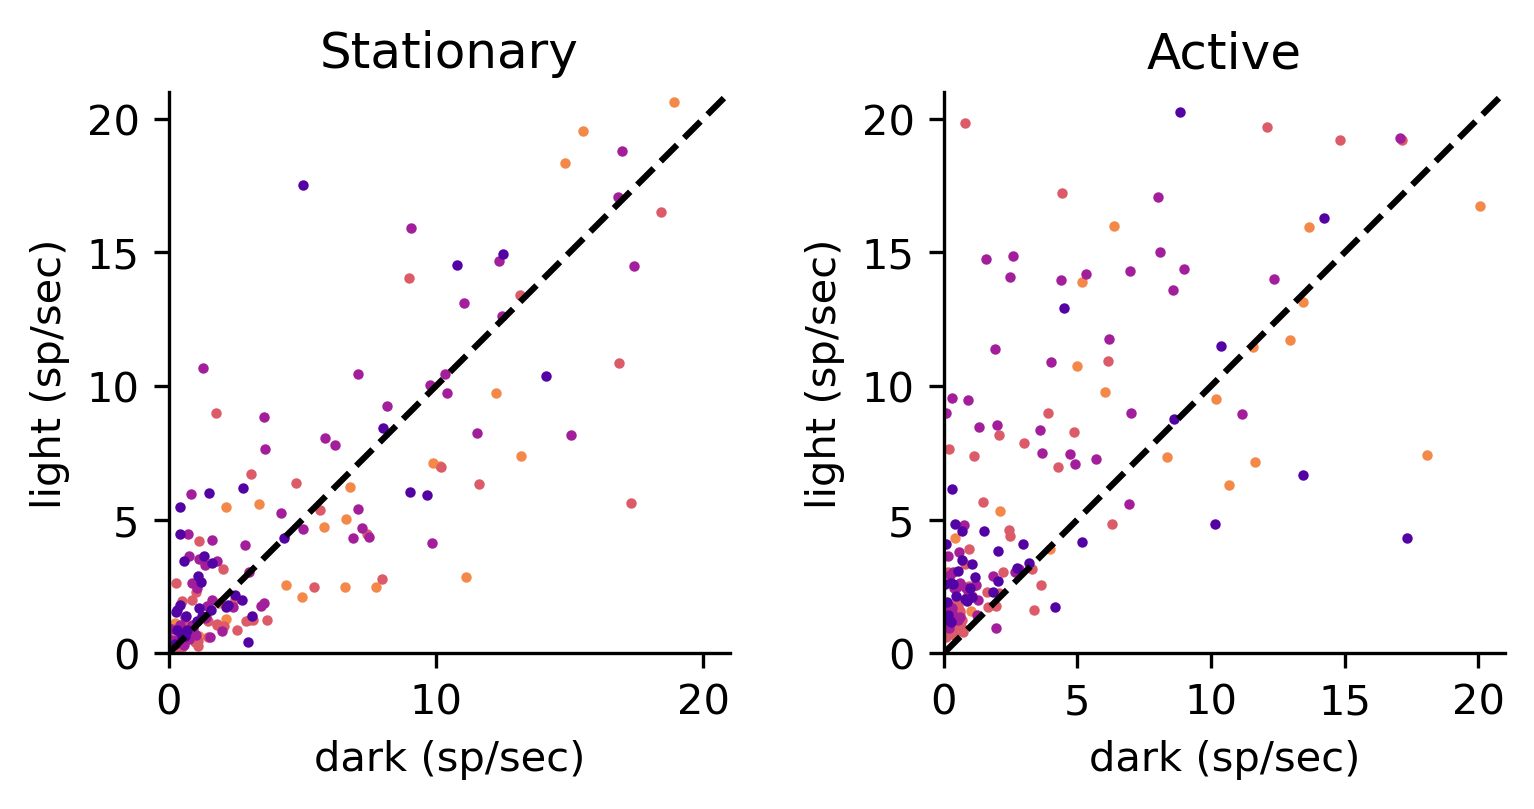

In [9]:
names = ['early','late','biphasic','negative']

fig3E = plt.figure(constrained_layout=True, figsize=(5,6), dpi=300)
fig3Espec = gridspec.GridSpec(nrows=4, ncols=6, figure=fig3E, wspace=.3, hspace=0.5)

ax_stationary_fr = fig3E.add_subplot(fig3Espec[1:3,0:3])
ax_active_fr = fig3E.add_subplot(fig3Espec[1:3,3:6])

for name in names:
    light_iafr = ltdk['FmLt_inactive_fr'][ltdk['gazecluster']==name].to_numpy()
    dark_iafr = ltdk['FmDk_inactive_fr'][ltdk['gazecluster']==name].to_numpy()
    
    light_afr = ltdk['FmLt_active_fr'][ltdk['gazecluster']==name].to_numpy()
    dark_afr = ltdk['FmDk_active_fr'][ltdk['gazecluster']==name].to_numpy()
    
    for i in range(np.size(light_iafr,0)):
        ax_active_fr.plot(dark_afr[i], light_afr[i], '.', color=cat_cmap[name], markersize=3)
        ax_stationary_fr.plot(dark_iafr[i], light_iafr[i], '.', color=cat_cmap[name], markersize=3)
    
fr_axis_max = 21
ax_active_fr.axis('square')
ax_stationary_fr.axis('square')
ax_stationary_fr.set_ylim([0,fr_axis_max]); ax_active_fr.set_ylim([0,fr_axis_max])
ax_stationary_fr.set_xlim([0,fr_axis_max]); ax_active_fr.set_xlim([0,fr_axis_max])
ax_stationary_fr.plot([0,fr_axis_max], [0,fr_axis_max], color='k',linestyle='dashed')
ax_active_fr.plot([0,fr_axis_max], [0,fr_axis_max], color='k',linestyle='dashed')
ax_stationary_fr.set_xlabel('dark (sp/sec)'); ax_stationary_fr.set_ylabel('light (sp/sec)')
ax_active_fr.set_title('Active')
ax_active_fr.set_xlabel('dark (sp/sec)'); ax_active_fr.set_ylabel('light (sp/sec)')
ax_stationary_fr.set_title('Stationary')
ax_active_fr.set_xticks(np.arange(0,fr_axis_max,5))
ax_stationary_fr.set_yticks(np.arange(0,fr_axis_max,5))
ax_active_fr.set_xticks(np.arange(0,fr_axis_max,5))
ax_stationary_fr.set_yticks(np.arange(0,fr_axis_max,5))


# fig3E.savefig(os.path.join(figpath, '3_ltdk_firing_rates.pdf'))

## does running effect exist in the dark?

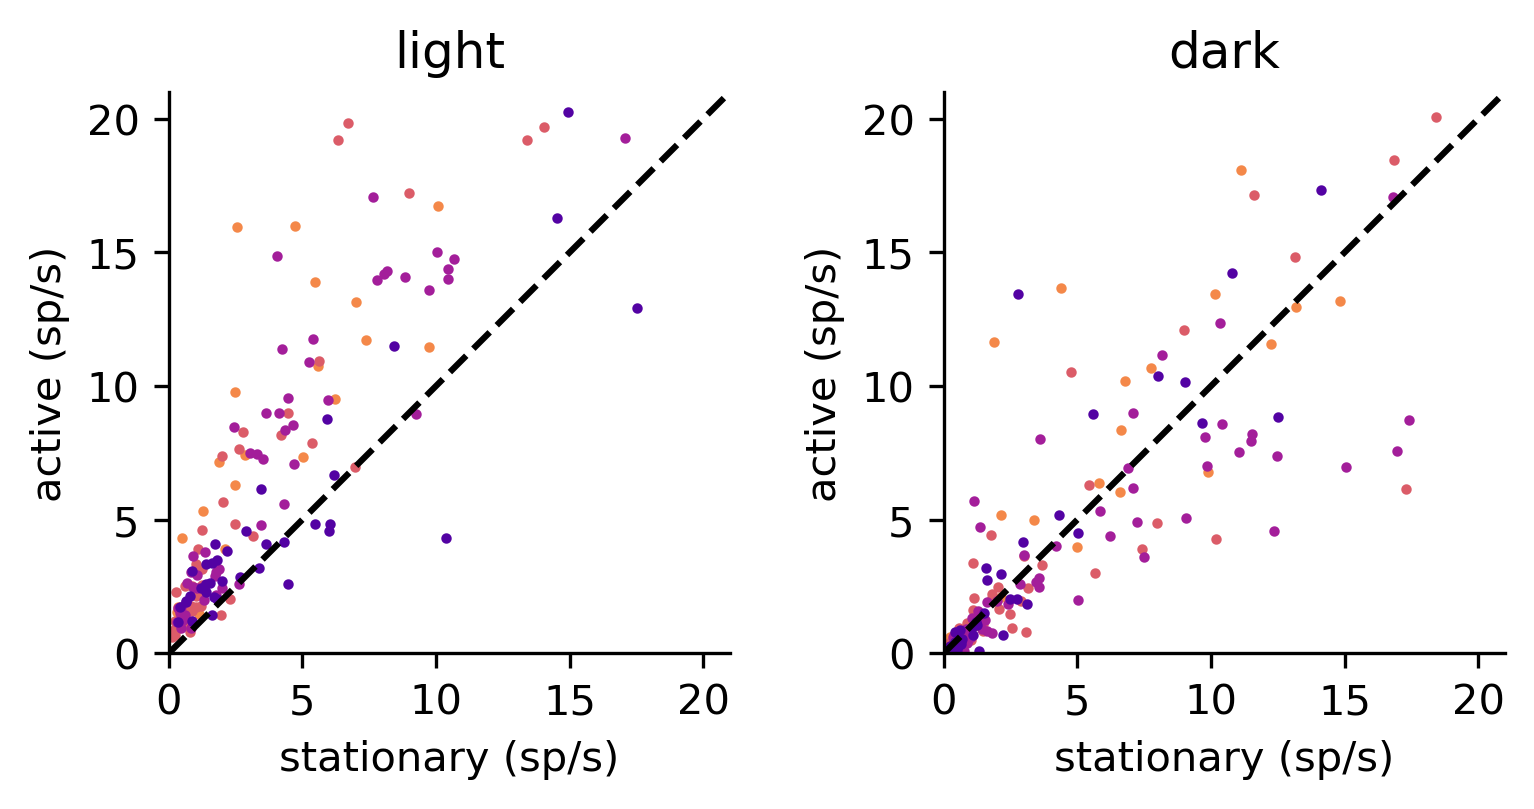

In [12]:
names = ['early','late','biphasic','negative']

fig3E = plt.figure(constrained_layout=True, figsize=(5,6), dpi=300)
fig3Espec = gridspec.GridSpec(nrows=4, ncols=6, figure=fig3E, wspace=.3, hspace=0.5)

ax_lt = fig3E.add_subplot(fig3Espec[1:3,0:3])
ax_dk = fig3E.add_subplot(fig3Espec[1:3,3:6])

for name in names:
    light_iafr = ltdk['FmLt_inactive_fr'][ltdk['gazecluster']==name].to_numpy()
    dark_iafr = ltdk['FmDk_inactive_fr'][ltdk['gazecluster']==name].to_numpy()
    
    light_afr = ltdk['FmLt_active_fr'][ltdk['gazecluster']==name].to_numpy()
    dark_afr = ltdk['FmDk_active_fr'][ltdk['gazecluster']==name].to_numpy()
    
    for i in range(np.size(light_iafr,0)):
        ax_lt.plot(light_iafr[i], light_afr[i], '.', color=cat_cmap[name], markersize=3)
        ax_dk.plot(dark_iafr[i], dark_afr[i], '.', color=cat_cmap[name], markersize=3)
    
fr_axis_max = 21

for ax in [ax_lt, ax_dk]:
    ax.axis('square')
    ax.set_ylim([0,fr_axis_max])
    ax.set_xlim([0,fr_axis_max])
    ax.plot([0,fr_axis_max], [0,fr_axis_max], color='k', linestyle='dashed')
    ax.set_xlabel('stationary (sp/s)')
    ax.set_ylabel('active (sp/s)')
    ax.set_xticks(np.arange(0, fr_axis_max, 5))
    ax.set_yticks(np.arange(0, fr_axis_max, 5))

ax_lt.set_title('light')    
ax_dk.set_title('dark')


fig3E.savefig(os.path.join(figpath, 'S3_running_effect_dark.pdf'))

## dark responsive PSTHs

In [ ]:
fig3A = plt.figure(constrained_layout=True, figsize=(4,3), dpi=300)
fig3Aspec = gridspec.GridSpec(nrows=2, ncols=2, figure=fig3A, wspace=0.05, hspace=0.1)

ax_light_pref = fig3A.add_subplot(fig3Aspec[1,0])
ax_light_nonpref = fig3A.add_subplot(fig3Aspec[1,1])
ax_dark_pref = fig3A.add_subplot(fig3Aspec[0,0])
ax_dark_nonpref = fig3A.add_subplot(fig3Aspec[0,1])

names = ['pref_gazeshift_psth','nonpref_gazeshift_psth','pref_dark_gazeshift_psth','nonpref_dark_gazeshift_psth']
panels = [ax_light_pref, ax_light_nonpref, ax_dark_pref, ax_dark_nonpref]
use_cells = ltdk[ltdk['dark_responsive']].copy() # [ltdk['FmLt_gaze_responsive']]

ax_light_pref.set_title('Light pref.')
ax_light_nonpref.set_title('Light nonpref.')
ax_dark_pref.set_title('Dark pref.')
ax_dark_nonpref.set_title('Dark nonpref.')

for count, name in enumerate(names):
    panel = panels[count]
    
    for x, p in enumerate(use_cells[name]):
        panel.plot(psth_bins, p, '-', linewidth=1, alpha=.75, color=cat_cmap[use_cells['gazecluster'].iloc[x]])
    # panel.plot(psth_bins, np.nanmedian(flatten_series(use_cells['pref_gazeshift_psth']),0), '-', linewidth=2, color='k')
    panel.set_xlim([-0.2,0.4])
    panel.vlines(0,-1,1, color='k',linestyle='dashed',linewidth=1)
    panel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
    panel.set_ylim([-.6,1])
    if count==0 or count==1:
        panel.set_xticklabels([])
    else:
        panel.set_xlabel('time (msec)')
        
    if count==1 or count==3:
        panel.set_yticklabels([])
    else:
        panel.set_ylabel('norm. spike rate')
    # if name=='early':
    #     lpanel.set_ylabel('norm. spike rate')
    # if name!='early':
    #     lpanel.set_yticklabels([])
    #     dpanel.set_yticklabels([])
    # lpanel.set_xticklabels([])
    # dpanel.set_xlabel('time (msec)')
        
fig3A.savefig(os.path.join(figpath, 'S2_dark_responsive.pdf'))

In [ ]:
fig, ax = plt.subplots(1,1, dpi=300, figsize=(2.75,1.5))

vals = ltdk['gazeshift_DSI'][ltdk['dark_responsive']].copy()
weights = np.ones_like(vals) / float(len(vals))
ax.hist(vals, bins=np.linspace(0,1,13),weights=weights,
         color='k', histtype='stepfilled', alpha=0.7)
ax.set_ylim([0,.5])
ax.set_xlabel('gaze-shifting DSI')
ax.set_ylabel('frac. cells')

fig3A.savefig(os.path.join(figpath, 'S2_dark_responsive_DSI_in_light.pdf'))

In [ ]:
for wv in hffm['waveform'][hffm['exc_or_inh']=='inh']:
    plt.plot(np.arange(len(wv))*1000/30000, wv, color='r', alpha=0.5, linewidth=1)
for wv in hffm['waveform'][hffm['exc_or_inh']=='exc']:
    plt.plot(np.arange(len(wv))*1000/30000, wv, color='k', alpha=0.5, linewidth=1)

In [ ]:
fig, ax = plt.subplots(1,1, dpi=300, figsize=(3,2))
for i, name in enumerate(['early','late','biphasic','negative','unresponsive']):
    vcounts = hffm['exc_or_inh'][hffm['gazecluster']==name].value_counts()
    ax.bar(i, vcounts['exc']/np.sum(vcounts), color='grey')
    ax.bar(i, vcounts['inh']/np.sum(vcounts), bottom=vcounts['exc']/np.sum(vcounts), color='k')
ax.set_xticks(ticks=range(5), labels=['early','late','biph','neg','unresp'])
ax.set_ylabel('frac. of cluster')
fig.savefig(os.path.join(figpath, 'S2_celltype.pdf'))

# direction selectivity hist

In [ ]:
for ind, row in hffm.iterrows():
    hffm.at[ind, 'gazeshift_DSI'] = calc_psth_DSI(row['pref_gazeshift_psth_raw'].astype(float), row['nonpref_gazeshift_psth_raw'].astype(float))

In [ ]:
fig, axs = plt.subplots(4,1,figsize=(2.8,4),dpi=300)

for p, name in enumerate(['early','late','biphasic','negative']):
    ax = axs[p]
    
    vals = hffm['gazeshift_DSI'][hffm['gazecluster']==name].copy()
    weights = np.ones_like(vals) / float(len(vals))
    ax.hist(vals, bins=np.linspace(0,1,13),weights=weights,
             color=cat_cmap[name], histtype='stepfilled', alpha=0.7)
    ax.set_ylim([0,.5])
    if p==3:
        # ax.set_title(name)
        ax.set_xlabel('gaze-shifting DSI')
    else:
        ax.set_xticklabels([])
    ax.set_ylabel('frac. cells')
    
plt.tight_layout()
fig.savefig(os.path.join(figpath, 'S1_gaze_DSI.pdf'))

# Umap for supp

In [ ]:
import umap
reducer = umap.UMAP()
gazeshift_arr = flatten_series(hffm['pref_gazeshift_psth'])
embedding = reducer.fit_transform(gazeshift_arr)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
for count, movtype in enumerate(['early','late','biphasic','negative','unresponsive']):
    inds = hffm[hffm['gazecluster']==movtype].index.values
    ax.plot(embedding[inds,0], embedding[inds,1], '.', color=cat_cmap[movtype], markersize=8)
    ax.set_title('UMAP Embedding')
zfig.savefig('/home/niell_lab/Desktop/umap.pdf')

# Plot PCA

In [26]:
proj = np.load('/home/niell_lab/Data/freely_moving_ephys/batch_files/062022/dEye_PSTH_pca1-new.npy')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

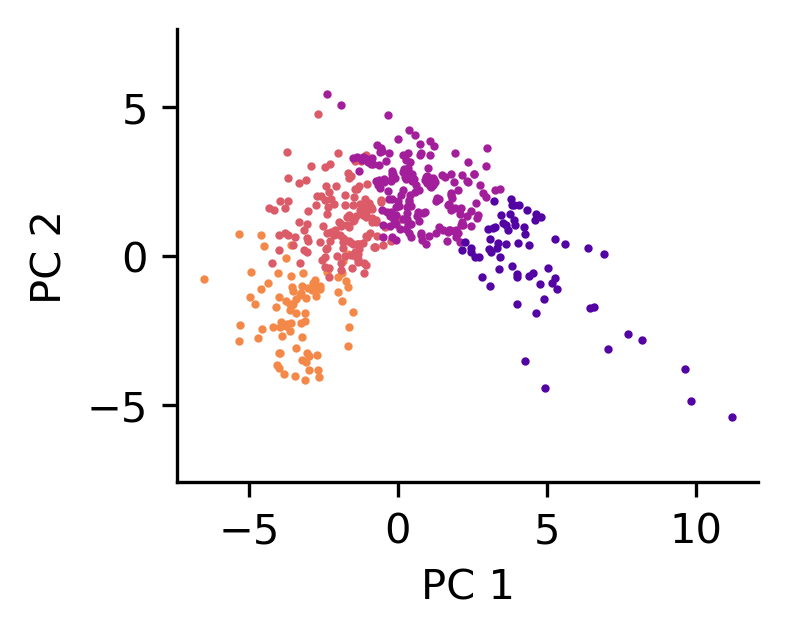

In [44]:
fig, ax = plt.subplots(1,1,figsize=(2.5,2), dpi=300)
for name in ['early','late','biphasic','negative']:
    use = np.array([hffm['gazecluster']==name].copy())[0]
    ax.scatter(proj[use,0], proj[use,1], s=1, c=cat_cmap[name])
ax.set_xlabel('PC 1'); ax.set_ylabel('PC 2')
ax.axis('equal')
fig.savefig(os.path.join(figpath, 'S1_pca.pdf'))

# Fig 4

## temporal sequence head-fixed

In [ ]:
sorted_df = hffm[['FmLt_gazeshift_peakT','gazecluster','pref_gazeshift_psth','nonpref_gazeshift_psth','pref_comp_psth',
                       'nonpref_comp_psth','norm_Rc_psth','norm_Sn_psth','tf_pref_cps','sf_pref_cpd','Sn_responsive','Rc_responsive']].copy()
# tseq_unresp = sorted_df.copy()
# tseq_unresp = sorted_df[sorted_df['gazecluster']=='unresponsive'].sample(frac=1).reset_index(drop=True)
# tseq_unresp_pref = flatten_series(tseq_unresp['pref_gazeshift_psth'])
# tseq_unresp_nonpref = flatten_series(tseq_unresp['nonpref_gazeshift_psth'])
# tseq_unresp_comp = flatten_series(tseq_unresp['pref_comp_psth'])

# tseq_unresp_rc = flatten_series(sorted_df['norm_Rc_psth'][sorted_df['gazecluster']!='unresponsive'][sorted_df['Rc_responsive']==False].sample(frac=1).reset_index(drop=True))
# tseq_unresp_sn = flatten_series(sorted_df['norm_Sn_psth'][sorted_df['gazecluster']!='unresponsive'][sorted_df['Sn_responsive']==False].sample(frac=1).reset_index(drop=True))

sorted_df = sorted_df[sorted_df['gazecluster']!='unresponsive']
sorted_df.sort_values(by='FmLt_gazeshift_peakT', inplace=True)
sorted_df = sorted_df.reset_index()
tseq_rc_gaze = flatten_series(sorted_df['pref_gazeshift_psth'][sorted_df['Rc_responsive']].copy())
tseq_sn_gaze = flatten_series(sorted_df['pref_gazeshift_psth'][sorted_df['Sn_responsive']].copy())

tseq_either_hf = flatten_series(sorted_df['pref_gazeshift_psth'][sorted_df['Sn_responsive'] | sorted_df['Rc_responsive']].copy())
# tseq_nonpref = flatten_series(sorted_df['nonpref_gazeshift_psth'].copy())
# tseq_comp = flatten_series(sorted_df['pref_comp_psth'].copy())
tseq_rc = flatten_series(sorted_df['norm_Rc_psth'][sorted_df['Rc_responsive']].copy())
tseq_sn = flatten_series(sorted_df['norm_Sn_psth'][sorted_df['Sn_responsive']].copy())

# tseq_grat_tf = sorted_df['tf_pref_cps'].copy().to_numpy()
# tseq_grat_sf = sorted_df['sf_pref_cpd'].copy().to_numpy()

# tseq_pref1 = np.vstack([tseq_pref, tseq_unresp_pref])
# tseq_nonpref1 = np.vstack([tseq_nonpref, tseq_unresp_nonpref])
# tseq_comp1 = np.vstack([tseq_comp, tseq_unresp_comp])
# tseq_rc1 = np.vstack([tseq_rc, tseq_unresp_rc])
# tseq_sn1 = np.vstack([tseq_sn, tseq_unresp_sn])

## setup for demo units

In [ ]:
ex_units = [413, 415, 456] #[215,81,191]
ex_units_direcprefs = ['left','left','left']
for ind in ex_units:
    print(hffm['session'].iloc[ind])

In [ ]:
hffm['original_session_path'].iloc[ind]

In [ ]:
ind = 413
path = hffm['original_session_path'].iloc[ind]
worldpath = find('*revchecker*world.nc', path)[0]
ephyspath = find('*revchecker*ephys_props.h5', path)[0]
origephys = pd.read_hdf(ephyspath)
ephysT0 = origephys['t0'].iloc[0]
worldxr = xr.open_dataset(worldpath)
vid = worldxr.WORLD_video.values.astype(np.uint8)
worldT = worldxr.timestamps.values
eyeT = hffm['Rc_eyeT'].iloc[ind].copy()

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
num_frames = np.size(vid, 0); vid_width = np.size(vid, 1); vid_height = np.size(vid, 2)
kmeans_input = vid.reshape(num_frames, vid_width*vid_height)
_, labels, _ = cv2.kmeans(kmeans_input.astype(np.float32), 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
label_diff = np.diff(np.ndarray.flatten(labels))
stim_state = interp1d(worldT[:-1]-ephysT0, label_diff, bounds_error=False)(eyeT)
eventT = eyeT[np.where((stim_state<-0.1)+(stim_state>0.1))]

In [ ]:
eventT.size

## head-fixed example units

In [ ]:
fig4A = plt.figure(constrained_layout=True, figsize=(5,4), dpi=300)
fig4Aspec = gridspec.GridSpec(nrows=3, ncols=3, figure=fig4A, wspace=0.07, hspace=0.15)

ax_pos_rasterG = fig4A.add_subplot(fig4Aspec[0,0])
ax_biph_rasterG = fig4A.add_subplot(fig4Aspec[0,1])
ax_neg_rasterG = fig4A.add_subplot(fig4Aspec[0,2])

ax_pos_rasterR = fig4A.add_subplot(fig4Aspec[1,0])
ax_biph_rasterR = fig4A.add_subplot(fig4Aspec[1,1])
ax_neg_rasterR = fig4A.add_subplot(fig4Aspec[1,2])

ax_pos_psth = fig4A.add_subplot(fig4Aspec[2,0])
ax_biph_psth = fig4A.add_subplot(fig4Aspec[2,1])
ax_neg_psth = fig4A.add_subplot(fig4Aspec[2,2])

num_movements = 247
raster_panelsG = [ax_pos_rasterG, ax_biph_rasterG, ax_neg_rasterG]
raster_panelsR = [ax_pos_rasterR, ax_biph_rasterR, ax_neg_rasterR]
sdf_panels = [ax_pos_psth, ax_biph_psth, ax_neg_psth]
for i, u in enumerate(ex_units):
    row = hffm.iloc[u]
    rasterG = raster_panelsG[i]
    rasterR = raster_panelsR[i]
    sdf_panel = sdf_panels[i]
    LR = ex_units_direcprefs[i]
    
    rasterG.set_title(['positive','biphasic','negative'][i])

    gazeshifts = row['FmLt_gazeshift_{}_saccTimes_dHead'.format(LR)].copy()
    
    plot_gs = np.random.choice(gazeshifts, size=num_movements, replace=False)
    plot_rc = np.random.choice(eventT.copy(), size=num_movements, replace=False)

    for n, s in enumerate(plot_gs):
        sp = row['FmLt_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        rasterG.plot(sp, np.ones(sp.size)*n, '|', color=colors['gaze'], markersize=.25)

    for n, s in enumerate(plot_rc):
        sp = row['Rc_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        rasterR.plot(sp, np.ones(sp.size)*(n), '|', color='k', markersize=.25)
    
    rasterG.set_ylim([num_movements, 0])
    rasterR.set_ylim([num_movements, 0])
    rasterG.vlines(0, 0, num_movements, color='k', linewidth=1, linestyle='dashed')
    rasterR.vlines(0, 0, num_movements, color='k', linewidth=1, linestyle='dashed')
    if i == 0:
        rasterG.set_ylabel('gaze shifts'); rasterR.set_ylabel('checkerboard')
        rasterG.set_yticks(np.linspace(0, 250, 3))
        rasterR.set_yticks(np.linspace(0, 250, 3))
    else:
        rasterG.set_yticks(np.linspace(0, 250, 3),labels=[])
        rasterR.set_yticks(np.linspace(0, 250, 3),labels=[])
    rasterG.set_xticks([]); rasterR.set_xticks([])
    rasterG.set_xlim([-.5,.5]); rasterR.set_xlim([-.5,.5])
    rasterG.axes.spines.bottom.set_visible(False); rasterR.axes.spines.bottom.set_visible(False)
    
    sdf_panel.plot(psth_bins, row['Rc_psth'], color='k')
    sdf_panel.plot(psth_bins, row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)], color=colors['gaze'])
    max_fr = np.nanmax(np.hstack([row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)], row['Rc_psth']]))*1.1
    sdf_panel.set_ylim([0,max_fr])
    sdf_panel.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
    sdf_panel.set_xlim([-.5,.5])
    if i == 0:
        sdf_panel.set_ylabel('sp/sec')
    sdf_panel.set_xlabel('msec')
    sdf_panel.vlines(0, 0, max_fr, color='k', linewidth=1, linestyle='dashed')
    
fig4A.savefig(os.path.join(figpath, '4_demo_units.pdf'))

## head-fixed clustering

In [ ]:
fig4B = plt.figure(constrained_layout=True, figsize=(9,2.5), dpi=300)
fig4Bspec = gridspec.GridSpec(nrows=1, ncols=3, figure=fig4B, wspace=0.01, hspace=0)

ax_light_clusters_gaze = fig4B.add_subplot(fig4Bspec[:,0])
ax_light_clusters = fig4B.add_subplot(fig4Bspec[:,1])
ax_dark_clusters = fig4B.add_subplot(fig4Bspec[:,2])

names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    data = hffm[hffm['gazecluster']==name]
    cluster_psths = flatten_series(data['pref_gazeshift_psth'])
    cluster_psths = cluster_psths[~np.isnan(cluster_psths).any(axis=1)]
    clustmean = np.nanmean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_light_clusters_gaze.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_light_clusters_gaze.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2) 
ax_light_clusters_gaze.set_xlim([-0.2,0.4]); ax_light_clusters_gaze.set_ylim([-.6,.6])
ax_light_clusters_gaze.set_ylabel('norm. spike rate'); ax_light_clusters.set_xlabel('msec')
ax_light_clusters_gaze.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_light_clusters_gaze.set_yticks(np.linspace(-0.5,0.5,3))
ax_light_clusters_gaze.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

step = 0.14
names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    data = hffm[hffm['gazecluster']==name][hffm['Rc_responsive']]
    cluster_psths = flatten_series(data['norm_Rc_psth'])
    cluster_psths = cluster_psths[~np.isnan(cluster_psths).any(axis=1)]
    clustmean = np.nanmean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_light_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_light_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2) 
ax_light_clusters.set_xlim([-0.2,0.4]); ax_light_clusters.set_ylim([-.6,.6])
# ax_dark_clusters.annotate('early', xy=[0.3,-0.22], color=cat_cmap['early'], fontsize=11)
# ax_dark_clusters.annotate('late', xy=[0.3,-0.22-(step*1)], color=cat_cmap['late'], fontsize=11)
# ax_dark_clusters.annotate('biphasic', xy=[0.3,-0.22-(step*2)], color=cat_cmap['biphasic'], fontsize=11)
# ax_dark_clusters.annotate('negative', xy=[0.3,-0.22-(step*3)], color=cat_cmap['negative'], fontsize=11)
ax_light_clusters.set_ylabel('norm. spike rate'); ax_light_clusters.set_xlabel('msec')
# ax_light_clusters.set_title('Light')
ax_light_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_light_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_light_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

for count, name in enumerate(names):
    data = hffm[hffm['gazecluster']==name][hffm['Sn_responsive']]
    cluster_psths = flatten_series(data['norm_Sn_psth'])
    cluster_psths = cluster_psths[~np.isnan(cluster_psths).any(axis=1)]
    clustmean = np.nanmean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_dark_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_dark_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.3) 
ax_dark_clusters.set_xlim([-0.2,0.4]); ax_dark_clusters.set_ylim([-.6,.6]); ax_dark_clusters.set_xlabel('msec')
# ax_dark_clusters.set_title('Dark')
ax_dark_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_dark_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_dark_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
ax_dark_clusters.vlines(.25,-1,1,color='k',linestyle='dashed',linewidth=1)

fig4B.savefig(os.path.join(figpath, '4_clustering_withUnresp.pdf'))

## head-fixed temporal sequence

In [ ]:
fig3C = plt.figure(constrained_layout=True, figsize=(9,4), dpi=300)
fig3Cspec = gridspec.GridSpec(nrows=1, ncols=4, figure=fig3C, wspace=0, hspace=0.5)

ax_tseq_gaze1 = fig3C.add_subplot(fig3Cspec[:,0])
ax_tseq_rc = fig3C.add_subplot(fig3Cspec[:,1])
ax_tseq_gaze2 = fig3C.add_subplot(fig3Cspec[:,2])
ax_tseq_sn = fig3C.add_subplot(fig3Cspec[:,3])

tseq_aspect = 2.8

sz = np.size(drop_nan_along(tseq_either_hf),0)
plot_tempseq(ax_tseq_gaze1, drop_nan_along(tseq_either_hf))
ax_tseq_gaze1.set_aspect(tseq_aspect)
ax_tseq_gaze1.set_ylabel('cell')
ax_tseq_gaze1.set_title('gaze-shifting')
ax_tseq_gaze1.set_yticks(np.arange(0,sz,100))

sz = np.size(drop_nan_along(tseq_rc),0)
plot_tempseq(ax_tseq_rc, drop_nan_along(tseq_rc))
ax_tseq_rc.set_aspect(tseq_aspect)
ax_tseq_rc.set_title('checkerboard')
ax_tseq_rc.set_yticks(np.arange(0,sz,100), labels=[])

sz = np.size(drop_nan_along(tseq_either_hf),0)
plot_tempseq(ax_tseq_gaze2, drop_nan_along(tseq_either_hf))
ax_tseq_gaze2.set_aspect(tseq_aspect)
ax_tseq_gaze2.set_title('gaze-shifting')
ax_tseq_gaze2.set_ylabel('cell')
ax_tseq_gaze2.set_yticks(np.arange(0,sz,100))

sz = np.size(drop_nan_along(tseq_sn),0)
plot_tempseq(ax_tseq_sn, drop_nan_along(tseq_sn))
ax_tseq_sn.set_aspect(tseq_aspect)
ax_tseq_sn.set_title('sparse noise')
ax_tseq_sn.set_yticks(np.arange(0,sz,100), labels=[])
ax_tseq_sn.vlines(1250, 0, sz, linestyle='dashed', linewidth=1, color='k')

fig3C.savefig(os.path.join(figpath, '4_temp_seq-either_for_gaze.pdf'))

In [ ]:
tseq_legend_col = sorted_df['gazecluster'][sorted_df['Sn_responsive'] | sorted_df['Rc_responsive']].copy()
tseq_legend = np.zeros([len(tseq_legend_col.index.values), 1, 4])
for i, n in enumerate(tseq_legend_col):
    tseq_legend[i,:,:] = mpl.colors.to_rgba(cat_cmap[n])
# ucmap = mpl.colors.to_rgba(cat_cmap['unresponsive'])
# for i, n in enumerate(tseq_legend_col):
#     tseq_legend[i,:,:] = ucmap
# u = np.zeros([np.size(tseq_unresp_sn,0), 1, 4])
# for x in range(4):
#     u[:,:,x] = ucmap[x]
# tseq_legend_sn = np.vstack([tseq_legend, u])

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(0.5,2), dpi=300)
ax.imshow(tseq_legend, aspect=.05)
ax.set_yticks([]); ax.set_xticks([])
ax.axes.spines.bottom.set_visible(False)
ax.axes.spines.right.set_visible(False)
ax.axes.spines.left.set_visible(False)
ax.axes.spines.top.set_visible(False)
fig.savefig(os.path.join(figpath, '4_temp_seq_legend_either_hf.pdf'))

In [ ]:
tseq_legend_col = sorted_df['gazecluster'][sorted_df['Rc_responsive']].copy()
tseq_legend = np.zeros([len(tseq_legend_col.index.values), 1, 4])
for i, n in enumerate(tseq_legend_col):
    tseq_legend[i,:,:] = mpl.colors.to_rgba(cat_cmap[n])
# ucmap = mpl.colors.to_rgba(cat_cmap['unresponsive'])
# # for i, n in enumerate(tseq_legend_col):
# #     tseq_legend[i,:,:] = ucmap
# u = np.zeros([np.size(tseq_unresp_rc,0), 1, 4])
# for x in range(4):
#     u[:,:,x] = ucmap[x]
# tseq_legend_rc = np.vstack([tseq_legend, u])

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(0.5,2), dpi=300)
ax.imshow(tseq_legend, aspect=.05)
ax.set_yticks([]); ax.set_xticks([])
ax.axes.spines.bottom.set_visible(False)
ax.axes.spines.right.set_visible(False)
ax.axes.spines.left.set_visible(False)
ax.axes.spines.top.set_visible(False)
fig.savefig(os.path.join(figpath, '4_temp_seq_legend_Rc.pdf'))

In [ ]:
from scipy import stats
def running_median(panel, x, y, n_bins=7):
    bins = np.linspace(np.min(x), np.max(x), n_bins)
    bin_means, bin_edges, bin_number = stats.binned_statistic(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)], statistic=np.median, bins=bins)
    bin_std, _, _ = stats.binned_statistic(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)], statistic=np.nanstd, bins=bins)
    hist, _ = np.histogram(x[~np.isnan(x) & ~np.isnan(y)], bins=bins)
    tuning_err = bin_std / np.sqrt(hist)
    panel.plot(bin_edges[:-1] + (np.median(np.diff(bins))/2), bin_means, '-', color='k')
    panel.fill_between(bin_edges[:-1] + (np.median(np.diff(bins))/2), bin_means-tuning_err, bin_means+tuning_err, color='k', alpha=0.2)

In [ ]:
hffm['gaze_rc_maxcc'] = np.nan
hffm['gaze_sn_maxcc'] = np.nan
for ind, row in hffm[['norm_Rc_psth','norm_Sn_psth','pref_gazeshift_psth','Rc_responsive','Sn_responsive']][hffm['gazecluster']!='unresponsive'].iterrows():
    if row['Rc_responsive']:
        r = np.corrcoef(row['pref_gazeshift_psth'].astype(float)[1000:1250], row['norm_Rc_psth'].astype(float)[1000:1250])
        hffm.at[ind, 'gaze_rc_maxcc'] = r[0,1]
    if row['Sn_responsive']:
        r = np.corrcoef(row['pref_gazeshift_psth'].astype(float)[1000:1250], row['norm_Sn_psth'].astype(float)[1000:1250])
        hffm.at[ind, 'gaze_sn_maxcc'] = r[0,1]

In [ ]:
rc_vals = hffm['gaze_rc_maxcc'][hffm['Rc_responsive']][hffm['gazecluster']!='unresponsive'].copy().dropna().reset_index(drop=True).to_numpy().astype(float)
sn_vals = hffm['gaze_sn_maxcc'][hffm['Sn_responsive']][hffm['gazecluster']!='unresponsive'].copy().dropna().reset_index(drop=True).to_numpy().astype(float)


In [ ]:
len(hffm[hffm['gazecluster']!='unresponsive'][hffm['Sn_responsive']])

In [ ]:
len(rc_vals)

In [ ]:
[x for x in hffm.columns if 'cpd' in x]

In [ ]:
['sf_pref_cpd']

In [ ]:
hffm['gazecluster'][hffm['Gt_responsive']==True].value_counts().sum()

In [ ]:
57+78+109+134+145

In [ ]:
np.sum(hffm['Gt_responsive']==False)

In [ ]:
len(sn_vals)

## Corcoef and latency times

In [37]:
from scipy.stats import linregress
from scipy.stats import spearmanr

In [ ]:
def plot_linregress(ax, x_in, y_in):
    x = x_in[(~np.isnan(x_in)) * (~np.isnan(y_in))]
    y = y_in[(~np.isnan(x_in)) * (~np.isnan(y_in))]
    res = linregress(x, y)
    minval = np.min(x); maxval = np.max(x)
    border = (maxval - minval) * 0.1
    plotx = np.linspace(minval+border, maxval-border, 2)
    ax.plot(plotx, (res.slope*plotx) + res.intercept, color='k', linewidth=2)
    
    return res

In [ ]:
np.mean(sn_vals)

In [ ]:
fig, [ax0,ax1] = plt.subplots(2,1,figsize=(2.5,3.2), dpi=300)

Rc_weights = np.ones_like(rc_vals) / float(len(rc_vals))
n,_,_ = ax0.hist(rc_vals, color='grey', bins=np.linspace(-1,1,21), alpha=0.8, weights=Rc_weights)
# ax0.set_xlabel('gaze shift cc');
ax0.set_ylabel('frac. cells')
ax0.set_xticks(np.arange(-1,1,3),labels=[])
ax0.plot([0,0], [0, .22], color='k', linewidth=1, linestyle='dashed')
ax0.set_ylim([0,.22])

Sn_weights = np.ones_like(sn_vals) / float(len(sn_vals))
n,_,_ = ax1.hist(sn_vals, color='grey', bins=np.linspace(-1,1,21), alpha=0.8, weights=Sn_weights)
ax1.set_xlabel('gaze shift cc'); ax1.set_ylabel('frac. cells')
ax1.plot([0,0], [0, .22], color='k', linewidth=1, linestyle='dashed')
ax1.set_ylim([0,.22])

ax0.set_title('checkerboard')
ax1.set_title('sparse noise')

fig.tight_layout()
# fig.savefig(os.path.join(figpath, '4_cc.pdf'))

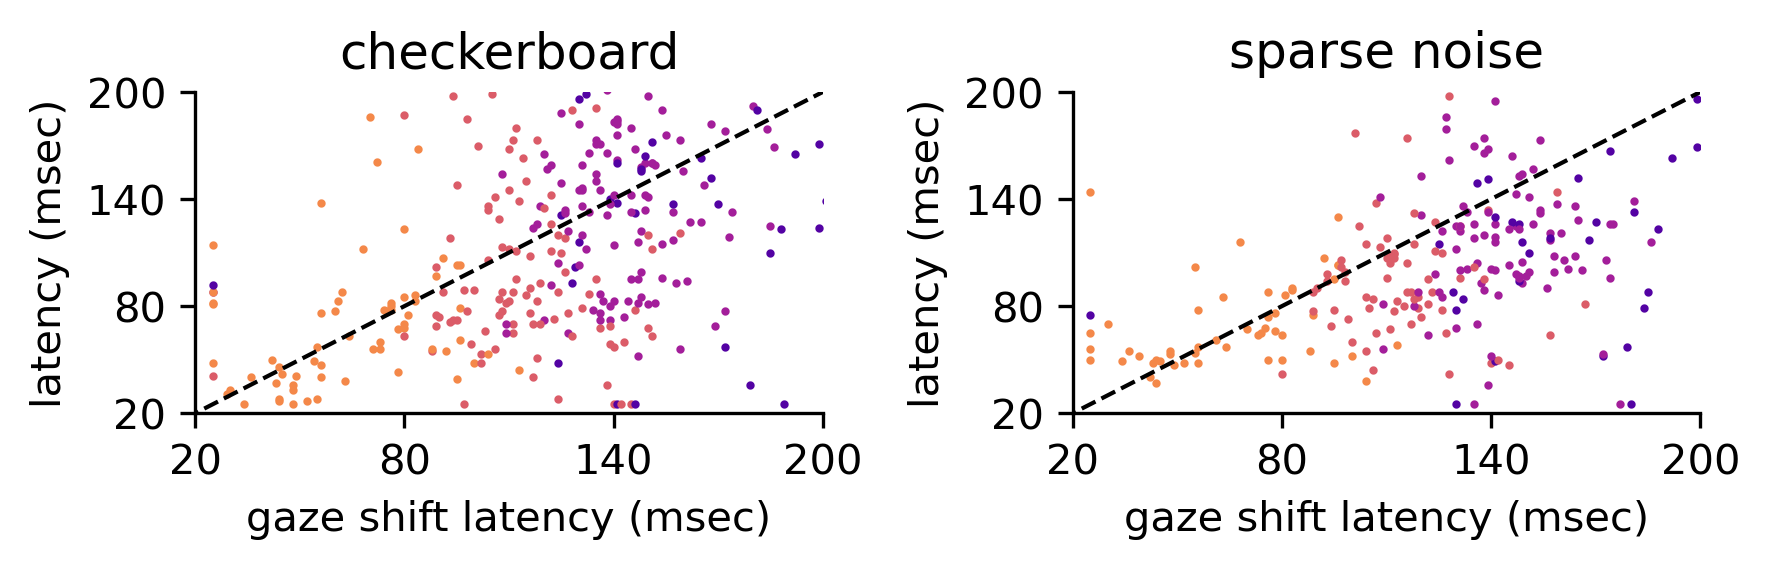

In [22]:
fig, [ax0,ax1] = plt.subplots(1,2,figsize=(6,2), dpi=300)
for ind, row in hffm[['gazecluster','FmLt_gazeshift_peakT','rc_peakT','sn_peakT','Rc_responsive','Sn_responsive']][hffm['gazecluster']!='unresponsive'].iterrows():
    if row['Rc_responsive']==True:
        ax0.plot(row['FmLt_gazeshift_peakT'], row['rc_peakT'], '.', color=cat_cmap[row['gazecluster']], markersize=2)
    if row['Sn_responsive']==True:
        ax1.plot(row['FmLt_gazeshift_peakT'], row['sn_peakT'], '.', color=cat_cmap[row['gazecluster']], markersize=2)

ax0.plot([0,.25], [0,.25], color='k', linewidth=1, linestyle='dashed')
ax1.plot([0,.25], [0,.25], color='k', linewidth=1, linestyle='dashed')
        
ax0.set_xlim([.02,.200]); ax0.set_ylim([.02,.200])
ax1.set_xlim([.02,.200]); ax1.set_ylim([.02,.200])
ax0.set_xticks(np.linspace(.02, 0.200, 4), labels=np.linspace(20, 200, 4).astype(int))
ax0.set_yticks(np.linspace(.02, 0.200, 4), labels=np.linspace(20, 200, 4).astype(int))
ax1.set_xticks(np.linspace(.02, 0.200, 4), labels=np.linspace(20, 200, 4).astype(int))
ax1.set_yticks(np.linspace(.02, 0.200, 4), labels=np.linspace(20, 200, 4).astype(int))
ax0.set_ylabel('latency (msec)'); ax0.set_xlabel('gaze shift latency (msec)')
ax1.set_ylabel('latency (msec)'); ax1.set_xlabel('gaze shift latency (msec)')
ax0.set_title('checkerboard')
ax1.set_title('sparse noise')

fig.tight_layout()

In [38]:
x_in = hffm['FmLt_gazeshift_peakT'][hffm['gazecluster']!='unresponsive'][hffm['Sn_responsive']==True].copy()
y_in = hffm['sn_peakT'][hffm['gazecluster']!='unresponsive'][hffm['Sn_responsive']==True].copy()

x = x_in[(~np.isnan(x_in)) * (~np.isnan(y_in))]
y = y_in[(~np.isnan(x_in)) * (~np.isnan(y_in))]

spearmanr(x, y)

SpearmanrResult(correlation=0.525859870730768, pvalue=4.193757850697018e-20)

In [39]:
x_in = hffm['FmLt_gazeshift_peakT'][hffm['gazecluster']!='unresponsive'][hffm['Rc_responsive']==True].copy()
y_in = hffm['rc_peakT'][hffm['gazecluster']!='unresponsive'][hffm['Rc_responsive']==True].copy()

x = x_in[(~np.isnan(x_in)) * (~np.isnan(y_in))]
y = y_in[(~np.isnan(x_in)) * (~np.isnan(y_in))]

spearmanr(x, y)

SpearmanrResult(correlation=0.48708997021994394, pvalue=5.892665340082758e-22)

In [ ]:
(res.rvalue)**2

In [ ]:
x = hffm['FmLt_gazeshift_peakT'][hffm['gazecluster']!='unresponsive'][hffm['Rc_responsive']==True].copy().to_numpy()
y = hffm['rc_peakT'][hffm['gazecluster']!='unresponsive'][hffm['Rc_responsive']==True].copy().to_numpy()

np.corrcoef(x, y)

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(5,4.5), dpi=300)
for ind, row in hffm[['gazecluster','FmLt_gazeshift_peakT','rc_peakT','sn_peakT','Rc_responsive','Sn_responsive']][hffm['gazecluster']!='unresponsive'].iterrows():
    if row['Rc_responsive']==True:
        axs[0,0].plot(row['FmLt_gazeshift_peakT'], row['rc_peakT'], '.', color=cat_cmap[row['gazecluster']], markersize=2)
    if row['Sn_responsive']==True:
        axs[0,1].plot(row['FmLt_gazeshift_peakT'], row['sn_peakT'], '.', color=cat_cmap[row['gazecluster']], markersize=2)

axs[0,0].plot([0,.25], [0,.25], color='k', linewidth=1, linestyle='dashed')
axs[0,1].plot([0,.25], [0,.25], color='k', linewidth=1, linestyle='dashed')
        
axs[0,0].set_xlim([.02,.200]); axs[0,0].set_ylim([.02,.200])
axs[0,1].set_xlim([.02,.200]); axs[0,1].set_ylim([.02,.200])
axs[0,0].set_xticks(np.linspace(.02, 0.200, 4), labels=np.linspace(20, 200, 4).astype(int))
axs[0,0].set_yticks(np.linspace(.02, 0.200, 4), labels=np.linspace(20, 200, 4).astype(int))
axs[0,1].set_xticks(np.linspace(.02, 0.200, 4), labels=np.linspace(20, 200, 4).astype(int))
axs[0,1].set_yticks(np.linspace(.02, 0.200, 4), labels=np.linspace(20, 200, 4).astype(int))
axs[0,0].set_ylabel('latency (msec)'); axs[0,0].set_xlabel('gaze shift latency (msec)')
axs[0,1].set_ylabel('latency (msec)'); axs[0,1].set_xlabel('gaze shift latency (msec)')
axs[0,0].set_title('checkerboard')
axs[0,1].set_title('sparse noise')

# use_Rc = hffm[hffm['FmLt_gazeshift_peakT']>.035][hffm['FmLt_gazeshift_peakT']<.2][hffm['rc_peakT']>.035][hffm['rc_peakT']<.2][hffm['gazecluster']!='unresponsive'][hffm['Rc_responsive']==True].copy()
# use_Sn = hffm[hffm['FmLt_gazeshift_peakT']>.035][hffm['FmLt_gazeshift_peakT']<.2][hffm['rc_peakT']>.035][hffm['rc_peakT']<.2][hffm['gazecluster']!='unresponsive'][hffm['Sn_responsive']==True].copy()

# rc_R = plot_linregress(axs[0,0], use_Rc['FmLt_gazeshift_peakT'], use_Rc['rc_peakT'])
# sn_R = plot_linregress(axs[0,1], use_Sn['FmLt_gazeshift_peakT'], use_Sn['sn_peakT'])

# print('Rc:{}; Sn:{}'.format(rc_R.rvalue, sn_R.rvalue))



#, 'k--', linewidth=1)#, linestyle='dashed')
# axs[0,1].plot([.03,.03], [.25,.25], 'k--', linewidth=1)#, linestyle='dashed')

Rc_weights = np.ones_like(rc_vals) / float(len(rc_vals))
n,_,_ = axs[1,0].hist(rc_vals, color='grey', bins=np.linspace(-1,1,21), alpha=0.8, weights=Rc_weights)
axs[1,0].set_xlabel('gaze shift cc'); axs[1,0].set_ylabel('frac. cells')
axs[1,0].plot([0,0], [0, .22], color='k', linewidth=1, linestyle='dashed')
axs[1,0].set_ylim([0,.22])

Sn_weights = np.ones_like(sn_vals) / float(len(sn_vals))
n,_,_ = axs[1,1].hist(sn_vals, color='grey', bins=np.linspace(-1,1,21), alpha=0.8, weights=Sn_weights)
axs[1,1].set_xlabel('gaze shift cc'); axs[1,1].set_ylabel('frac. cells')
axs[1,1].plot([0,0], [0, .22], color='k', linewidth=1, linestyle='dashed')
axs[1,1].set_ylim([0,.22])

axs[1,0].set_title('checkerboard')
axs[1,1].set_title('sparse noise')

plt.tight_layout()
fig.savefig(os.path.join(figpath, '4_props_cc.pdf'))

# Fig 5

## responsive to gratings

In [5]:
grat_bins = np.arange(-1500, 1501)

In [6]:
def gt_modind(psth):
    # modulation in terms of spike rate
    psth = psth.astype(float)
    
    use = psth - np.mean(psth[1100:1400].copy())
    
    mod = np.max(np.abs(use[1500:2500]))
    
    return mod

def normalize_gt_psth(psth):
    
    psth = psth.astype(float)
    
    bsln = np.mean(psth[1100:1400])

    norm_psth = (psth - bsln) / np.nanmax(psth)
    
    return norm_psth

In [7]:
hffm['raw_mod_for_Gt'] = np.nan
hffm['norm_mod_for_Gt'] = np.nan
hffm['Gt_kde_psth_norm'] = hffm['Gt_kde_psth'].copy()

for ind, row in hffm.iterrows():
    sec = row['Gt_eyeT'][-1].astype(float) - row['Gt_eyeT'][0].astype(float)
    sp = len(row['Gt_spikeT'])
    hffm.at[ind, 'Gt_fr'] = sp/sec
    
    norm_psth = normalize_gt_psth(row['Gt_kde_psth'])
    hffm.at[ind, 'Gt_kde_psth_norm'] = norm_psth.copy().astype(object)
    
    hffm.at[ind, 'raw_mod_for_Gt'] = gt_modind(row['Gt_kde_psth'])
    
    hffm.at[ind, 'norm_mod_for_Gt'] = gt_modind(norm_psth)
    
hffm['Gt_responsive'] = False
for ind, row in hffm.iterrows():
    if (row['raw_mod_for_Gt']>1) and (row['norm_mod_for_Gt']>0.1) and (np.max(row['Gt_kde_psth_norm'][1500:2500]) > 0.5):
        hffm.at[ind, 'Gt_responsive'] = True

print(hffm['Gt_responsive'].sum())
print(hffm['Gt_responsive'].sum()/len(hffm.index.values))

384
0.5363128491620112


/tmp/ipykernel_5095/703856481.py:17: RuntimeWarning: All-NaN slice encountered
  norm_psth = (psth - bsln) / np.nanmax(psth)


In [16]:
print('evoked {} to {}'.format(-1500+1500, -1500+2500))
print('baseline {} to {}'.format(-1500+1100, -1500+1400))

evoked 0 to 1000
baseline -400 to -100


In [ ]:
# def normalize_gt_psth(psth):
#     baseline_val = np.nanmedian(psth[:5])
#     norm_psth = (psth - baseline_val) / np.nanmax(psth[5:14].astype(float))
#     return norm_psth

# def gt_modind(psth):
#     psth = psth.astype(float)
#     use = psth - np.mean(psth[1:5].copy())
#     mod = np.max(use[5:8])
#     return mod

In [8]:
for sf in ['low','mid','high']:
    hffm['norm_ori_tuning_'+sf] = hffm['Gt_ori_tuning_tf'].copy().astype(object)
for ind, row in hffm.iterrows():
    orientations = np.nanmean(np.array(row['Gt_ori_tuning_tf'], dtype=np.float),2)
    for sfnum in range(3):
        sf = ['low','mid','high'][sfnum]
        hffm.at[ind,'norm_ori_tuning_'+sf] = orientations[:,sfnum] - row['Gt_drift_spont']
    mean_for_sf = np.array([np.mean(hffm.at[ind,'norm_ori_tuning_low']), np.mean(hffm.at[ind,'norm_ori_tuning_mid']), np.mean(hffm.at[ind,'norm_ori_tuning_high'])])
    mean_for_sf[mean_for_sf<0] = 0
    hffm.at[ind,'sf_pref'] = ((mean_for_sf[0]*1)+(mean_for_sf[1]*2)+(mean_for_sf[2]*3))/np.sum(mean_for_sf)

hffm['osi_for_sf_pref'] = np.nan
hffm['dsi_for_sf_pref'] = np.nan
for ind, row in hffm.iterrows():
    if ~np.isnan(row['sf_pref']):
        best_sf_pref = int(np.round(row['sf_pref']))
        hffm.at[ind, 'osi_for_sf_pref'] = row[(['Gt_osi_low','Gt_osi_mid','Gt_osi_high'][best_sf_pref-1])]
        hffm.at[ind, 'dsi_for_sf_pref'] = row[(['Gt_dsi_low','Gt_dsi_mid','Gt_dsi_high'][best_sf_pref-1])]

hffm['osi_for_sf_pref'][hffm['osi_for_sf_pref']<0] = 0
hffm['dsi_for_sf_pref'][hffm['dsi_for_sf_pref']<0] = 0
for ind, row in hffm.iterrows():
    try:
        mean_for_sf = np.array([np.mean(hffm.at[ind,'norm_ori_tuning_low']), np.mean(hffm.at[ind,'norm_ori_tuning_mid']), np.mean(hffm.at[ind,'norm_ori_tuning_high'])])
        mean_for_sf[mean_for_sf<0] = 0
        hffm.at[ind, 'Gt_evoked_rate'] = np.max(mean_for_sf) - row['Gt_drift_spont']
    except:
        pass

for ind, row in hffm.iterrows():
    if type(row['Gt_ori_tuning_tf']) != float:
        tuning = np.nanmean(row['Gt_ori_tuning_tf'],1)
        tuning = tuning - row['Gt_drift_spont']
        tuning[tuning < 0] = 0
        mean_for_tf = np.array([np.mean(tuning[:,0]), np.mean(tuning[:,1])])
        tf_pref = ((mean_for_tf[0]*1)+(mean_for_tf[1]*2))/np.sum(mean_for_tf)
        hffm.at[ind, 'tf_pref'] = tf_pref

for ind, row in hffm.iterrows():
    tf = 2 + (6 * (row['tf_pref']-1))
    sf = 0.02 * 4 ** (row['sf_pref']-1)
    hffm.at[ind,'tf_pref_cps'] = tf
    hffm.at[ind,'sf_pref_cpd'] = sf
    hffm.at[ind,'grat_speed_dps'] = tf / sf

/tmp/ipykernel_5095/3839690080.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  orientations = np.nanmean(np.array(row['Gt_ori_tuning_tf'], dtype=np.float),2)
/tmp/ipykernel_5095/3839690080.py:10: RuntimeWarning: invalid value encountered in double_scalars
  hffm.at[ind,'sf_pref'] = ((mean_for_sf[0]*1)+(mean_for_sf[1]*2)+(mean_for_sf[2]*3))/np.sum(mean_for_sf)
/tmp/ipykernel_5095/3839690080.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hffm['osi_for_sf_pref'][hffm['osi

In [ ]:
# for ind, row in hffm.iterrows():
#     sec = row['Gt_eyeT'][-1].astype(float) - row['Gt_eyeT'][0].astype(float)
#     sp = len(row['Gt_spikeT'])
#     hffm.at[ind, 'Gt_fr'] = sp/sec
    
#     hffm.at[ind, 'raw_mod_for_Gt'] = gt_modind(row['Gt_grating_psth'].astype(float))
    
#     hffm.at[ind, 'norm_mod_for_Gt'] = gt_modind(row['norm_gratings_psth'].astype(float))
    
#     # psth = row['Gt_grating_psth']
#     # baseline = np.median(psth[1:5].copy())
#     # peak = np.median(psth[5:14].copy())
#     # data.at[ind, 'raw_mod_for_Gt'] = peak - baseline
    
# hffm['Gt_responsive'] = False
# for ind, row in hffm.iterrows():
#     if (row['raw_mod_for_Gt']>1) and (row['norm_mod_for_Gt']>0.1):
#         hffm.at[ind, 'Gt_responsive'] = True

# print(hffm['Gt_responsive'].sum())
# print(hffm['Gt_responsive'].sum()/len(hffm.index.values))

## clusters

In [ ]:
fig, [[ax0, ax1],[ax2, ax3]] = plt.subplots(2,2, dpi=300, figsize=(7.5/2,3.5))

panels = [ax0, ax1, ax2, ax3]
movtypes = ['early','late','biphasic','negative']
for count, panel in enumerate(panels):
    movtype = movtypes[count]
    thisclust = hffm['Gt_kde_psth_norm'][hffm['gazecluster']==movtype][hffm['Gt_responsive']==True][hffm['strict_Gt_responsive']==True]
    for i, psth in enumerate(thisclust):
        panel.plot(grat_bins, psth, '-', linewidth=1, alpha=0.2)
    clustmean = np.nanmean(flatten_series(thisclust),0)
    panel.plot(grat_bins, clustmean, '-', linewidth=2, color=cat_cmap[movtype])
    
    panel.vlines(0,-1.5,1.5, color='k',linestyle='dashed',linewidth=1)
    panel.set_ylim([-0.5,1.2])
    panel.set_xlim([-400,1600])
    # panel.set_xticks(np.arange(-400, 1600, 400))
    panel.set_title(movtype)
    if movtype=='late' or movtype=='negative':
        panel.set_yticklabels([])
    else:
        panel.set_ylabel('norm sp/s')
    if movtype=='biphasic' or movtype=='negative':
        panel.set_xlabel('time (ms)')
    else:
        panel.set_xticklabels([])
plt.tight_layout()

fig.savefig(os.path.join(figpath, '5_clusters.pdf'))

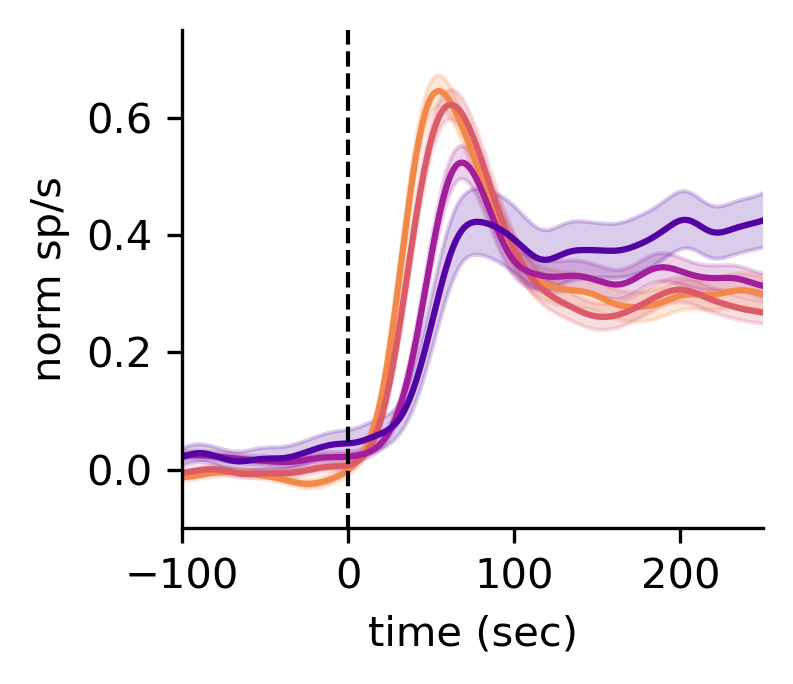

In [19]:
fig, ax = plt.subplots(1,1,figsize=(2.5,2.2), dpi=300)

names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    cluster_psths = flatten_series(hffm['Gt_kde_psth_norm'][hffm['gazecluster']==name][hffm['Gt_responsive']==True])
    cluster_psths = cluster_psths[~np.isnan(cluster_psths).any(axis=1)]
    clustmean = np.nanmean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax.plot(grat_bins, clustmean, '-', linewidth=1.5, color=cat_cmap[name])
    ax.fill_between(grat_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2)
ax.set_ylabel('norm sp/s'); ax.set_xlabel('time (sec)')
ax.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
ax.set_ylim([-.1,.75])
ax.set_xlim([-100,250])

fig.savefig(os.path.join(figpath, '5_grat_onset.pdf'))

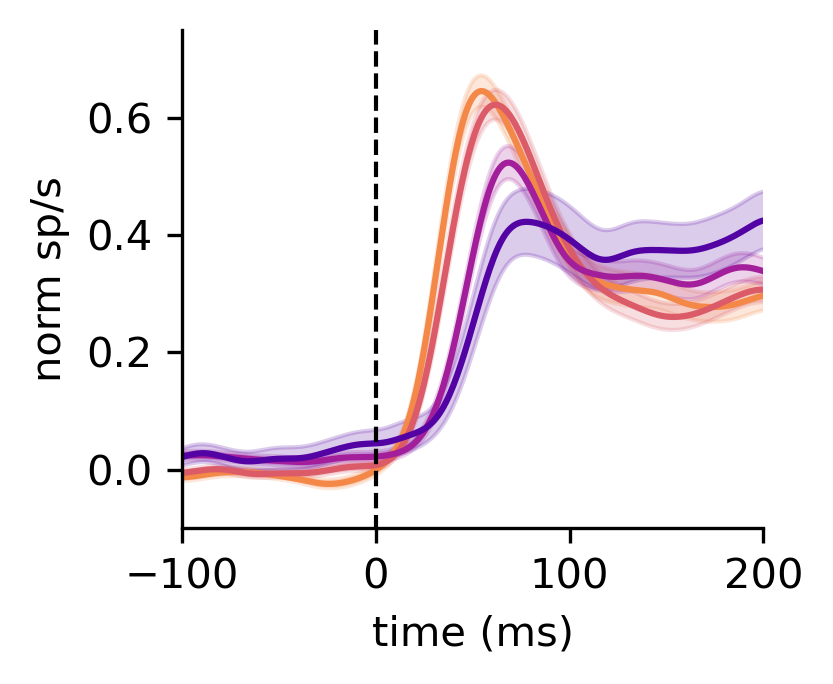

In [25]:
fig, ax = plt.subplots(1,1,figsize=(2.5,2.2), dpi=300)

names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    cluster_psths = flatten_series(hffm['Gt_kde_psth_norm'][hffm['gazecluster']==name][hffm['Gt_responsive']==True])
    cluster_psths = cluster_psths[~np.isnan(cluster_psths).any(axis=1)]
    clustmean = np.nanmean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax.plot(grat_bins, clustmean, '-', linewidth=1.5, color=cat_cmap[name])
    ax.fill_between(grat_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2)
ax.set_ylabel('norm sp/s'); ax.set_xlabel('time (ms)')
ax.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
ax.set_ylim([-.1,.75])
ax.set_xlim([-500,1500])
ax.set_xlim([-100,200])

fig.savefig(os.path.join(figpath, '5_grat_onsets.pdf'))

## sf/tf props

In [9]:
from scipy.stats import linregress

In [ ]:
fig5 = plt.figure(constrained_layout=False, figsize=(7,8), dpi=300)
fig5spec = gridspec.GridSpec(nrows=3, ncols=2, figure=fig5, wspace=.5, hspace=.5)

fig5Cspec = gridspec.GridSpecFromSubplotSpec(2,2,subplot_spec=fig5spec[1:3,0:2], wspace=.5, hspace=.5)
ax_tf_cat = fig5.add_subplot(fig5Cspec[0,0])
ax_tf_scatter = fig5.add_subplot(fig5Cspec[1,0])
ax_sf_cat = fig5.add_subplot(fig5Cspec[0,1])
ax_sf_scatter = fig5.add_subplot(fig5Cspec[1,1])

use_data = hffm[hffm['gazecluster']!='unresponsive'][hffm['Gt_responsive']==True].copy()
# [hffm['FmLt_gazeshift_peakT']>0.035][hffm['FmLt_gazeshift_peakT']<.2]

plot_cprop_scatter(ax_tf_cat, use_data, 'tf_pref_cps', use_median=True)
ax_tf_cat.set_ylabel('temporal freq (cps)')
ax_tf_cat.set_xticks(range(4), labels=['early','late','biph','neg'])
# ax_tf_cat.set_ylim([0, 8.05])

plot_cprop_scatter(ax_sf_cat, use_data, 'sf_pref_cpd', use_median=True)
ax_sf_cat.set_ylabel('spatial freq (cpd)')
ax_sf_cat.set_xticks(range(4), labels=['early','late','biph','neg'])
ax_sf_cat.set_ylim([0, 0.25])

###
names = ['early','late','biphasic','negative']
for i, name in enumerate(names):
    # cluster = hffm[hffm['movcluster']==name][hffm['responsive_to_gratings']==True][hffm['Fm_fr']>2][hffm['Gt_fr']>2]
    cluster = use_data[use_data['gazecluster']==name][hffm['FmLt_gazeshift_peakT']<.2].copy()
    ax_tf_scatter.plot(cluster['FmLt_gazeshift_peakT'], cluster['tf_pref_cps'], '.', color=cat_cmap[name], markersize=3)
    ax_sf_scatter.plot(cluster['FmLt_gazeshift_peakT'], cluster['sf_pref_cpd'], '.', color=cat_cmap[name], markersize=3)
    #[cluster['fr']>2]
# running_median(ax_tf_scatter, hffm['FmLt_gazeshift_peakT'][hffm['movcluster']!='unresponsive'][hffm['responsive_to_gratings']==True], hffm['tf_pref_cps'][hffm['movcluster']!='unresponsive'][hffm['responsive_to_gratings']==True])
# running_median(ax_sf_scatter, hffm['FmLt_gazeshift_peakT'][hffm['movcluster']!='unresponsive'][hffm['responsive_to_gratings']==True], hffm['sf_pref_cpd'][hffm['movcluster']!='unresponsive'][hffm['responsive_to_gratings']==True])

running_median(ax_tf_scatter, use_data['FmLt_gazeshift_peakT'][hffm['FmLt_gazeshift_peakT']<.2], use_data['tf_pref_cps'][hffm['FmLt_gazeshift_peakT']<.2], n_bins=7)
running_median(ax_sf_scatter, use_data['FmLt_gazeshift_peakT'][hffm['FmLt_gazeshift_peakT']<.2], use_data['sf_pref_cpd'][hffm['FmLt_gazeshift_peakT']<.2], n_bins=7)

# ax_tf_scatter.set_yscale('log')
# ax_sf_scatter.set_yscale('log')

# tf_R = plot_linregress(ax_tf_scatter, use_data['FmLt_gazeshift_peakT'], use_data['tf_pref_cps'])
# sf_R = plot_linregress(ax_sf_scatter, use_data['FmLt_gazeshift_peakT'], use_data['sf_pref_cpd'])

# ax_tf_scatter.set_ylim([0, 8.05])
ax_tf_scatter.set_xlim([.020,.205])
ax_sf_scatter.set_xlim([.020,.205])
ax_tf_scatter.set_xticks(np.linspace(.025, 0.200, 6), labels=np.linspace(25, 200, 6).astype(int))
ax_sf_scatter.set_xticks(np.linspace(.025, 0.200, 6), labels=np.linspace(25, 200, 6).astype(int))

# ax_tf_scatter.set_xticks(np.linspace(.035, 0.2, 4), labels=np.linspace(35, 200, 4).astype(int))
ax_tf_scatter.set_xlabel('gaze shift latency (msec)')
ax_tf_scatter.set_ylabel('temporal freq (cps)')

# ax_sf_scatter.set_xticks(np.linspace(.035, 0.2, 4), labels=np.linspace(35, 200, 4).astype(int))
ax_sf_scatter.set_xlabel('gaze shift latency (msec)')
ax_sf_scatter.set_ylabel('spatial freq (cpd)')
ax_sf_scatter.set_ylim([0,0.25])

# fig5.savefig(os.path.join(figpath, '5_props.pdf'))

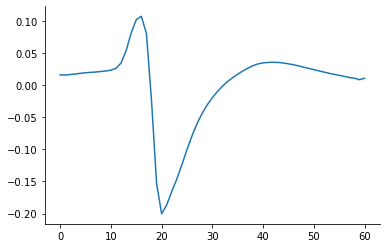

In [529]:
plt.plot(hffm['waveform'].iloc[0])

In [518]:
from scipy.stats import f_oneway
import itertools

In [522]:
combs = list(itertools.combinations(['early','late','biphasic','negative'], 2))
combs

[('early', 'late'),
 ('early', 'biphasic'),
 ('early', 'negative'),
 ('late', 'biphasic'),
 ('late', 'negative'),
 ('biphasic', 'negative')]

In [531]:
pairwise_anova = {}

vals = []
for i, pair in enumerate(combs):
    n1 = pair[0]
    n2 = pair[1]
    v1 = hffm['tf_pref_cps'][hffm['gazecluster']==n1][hffm['Gt_responsive']==True].copy().to_numpy()
    v2 = hffm['tf_pref_cps'][hffm['gazecluster']==n2][hffm['Gt_responsive']==True].copy().to_numpy()
    v1 = v1[~np.isnan(v1)]
    v2 = v2[~np.isnan(v2)]
    f, p = f_oneway(v1, v2)
    out = {'f':f, 'p':p}
    pairwise_anova['{}_{}'.format(n1,n2)] = out
pairwise_anova

{'early_late': {'f': 23.431484050146064, 'p': 3.1197687653743257e-06},
 'early_biphasic': {'f': 93.91500915963019, 'p': 5.8842971018752386e-18},
 'early_negative': {'f': 40.00296627521348, 'p': 5.868252179718336e-09},
 'late_biphasic': {'f': 28.032103701682633, 'p': 3.1848692386251544e-07},
 'late_negative': {'f': 8.992021957104937, 'p': 0.003233255839900168},
 'biphasic_negative': {'f': 0.7597993356312882, 'p': 0.38478435079712303}}

In [532]:
pairwise_anova = {}

vals = []
for i, pair in enumerate(combs):
    n1 = pair[0]
    n2 = pair[1]
    v1 = hffm['sf_pref_cpd'][hffm['gazecluster']==n1][hffm['Gt_responsive']==True].copy().to_numpy()
    v2 = hffm['sf_pref_cpd'][hffm['gazecluster']==n2][hffm['Gt_responsive']==True].copy().to_numpy()
    v1 = v1[~np.isnan(v1)]
    v2 = v2[~np.isnan(v2)]
    f, p = f_oneway(v1, v2)
    out = {'f':f, 'p':p}
    pairwise_anova['{}_{}'.format(n1,n2)] = out
pairwise_anova

{'early_late': {'f': 2.0869575354280436, 'p': 0.15066132228392895},
 'early_biphasic': {'f': 22.430383259532984, 'p': 4.751432202992052e-06},
 'early_negative': {'f': 24.346491586284625, 'p': 3.2546942051983387e-06},
 'late_biphasic': {'f': 16.181061173174545, 'p': 8.36394411501108e-05},
 'late_negative': {'f': 17.893193157924973, 'p': 4.500164930962363e-05},
 'biphasic_negative': {'f': 0.5363708485229016, 'p': 0.4652009550662728}}

In [530]:
ltdk['gazecluster'][ltdk['dark_responsive']==True].value_counts()

early           5
unresponsive    2
negative        1
late            1
Name: gazecluster, dtype: int64

In [432]:
vals = []
for i, name in enumerate(['early','late','biphasic','negative']):
    v = hffm['sf_pref_cpd'][hffm['gazecluster']==name][hffm['Gt_responsive']==True].copy().to_numpy()
    v = v[~np.isnan(v)]
    vals.append(v)
f_oneway(vals[0],vals[1],vals[2],vals[3])

F_onewayResult(statistic=13.510162876199503, pvalue=2.8804034981590198e-08)

In [ ]:
f_oneway

In [ ]:
len(hffm.index.values)

In [ ]:
716, 523, 384

In [ ]:
len(use_data)

In [ ]:
len(hffm[hffm['FmLt_gazeshift_peakT']>200][hffm['Gt_responsive']==True][hffm['gazecluster']!='unresponsive'].index.values)

In [ ]:
vc1 = hffm['gazecluster'][hffm['Gt_responsive']==True].value_counts()
vc2 = hffm['gazecluster'][hffm['Gt_responsive']==True][hffm['strict_Gt_responsive']==True].value_counts()

In [ ]:
vc1 - vc2

In [34]:
from scipy.stats import spearmanr

In [35]:
use_vals = hffm[hffm['gazecluster']!='unresponsive'][hffm['Gt_responsive']==True][hffm['FmLt_gazeshift_peakT']<.2]

x_in = use_vals['FmLt_gazeshift_peakT'].copy()
y_in = use_vals['tf_pref_cps'].copy()

x = x_in[(~np.isnan(x_in)) * (~np.isnan(y_in))]
y = y_in[(~np.isnan(x_in)) * (~np.isnan(y_in))]

spearmanr(x, y)

/tmp/ipykernel_5095/2343072606.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  use_vals = hffm[hffm['gazecluster']!='unresponsive'][hffm['Gt_responsive']==True][hffm['FmLt_gazeshift_peakT']<.2]


SpearmanrResult(correlation=-0.4683614610005714, pvalue=2.1221560745782839e-16)

In [36]:
use_vals = hffm[hffm['gazecluster']!='unresponsive'][hffm['Gt_responsive']==True][hffm['FmLt_gazeshift_peakT']<.2]

x_in = use_vals['FmLt_gazeshift_peakT'].copy()
y_in = use_vals['sf_pref_cpd'].copy()

x = x_in[(~np.isnan(x_in)) * (~np.isnan(y_in))]
y = y_in[(~np.isnan(x_in)) * (~np.isnan(y_in))]

spearmanr(x, y)

/tmp/ipykernel_5095/3891632364.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  use_vals = hffm[hffm['gazecluster']!='unresponsive'][hffm['Gt_responsive']==True][hffm['FmLt_gazeshift_peakT']<.2]


SpearmanrResult(correlation=0.28574889486260824, pvalue=1.7324645285147796e-06)

In [16]:
-.5**2

-0.25

In [ ]:
# TF
rval = res.rvalue
rval**2

In [ ]:
fig, [ax0, ax1] = plt.subplots(1,2, figsize=(6,2.5), dpi=300)
running_median(ax0, use_data['FmLt_gazeshift_peakT'], use_data['tf_pref_cps'], n_bins=7)
running_median(ax1, use_data['FmLt_gazeshift_peakT'], use_data['sf_pref_cpd'], n_bins=7)

In [ ]:
pd.isnull(use_data['FmLt_gazeshift_peakT']).sum()

In [ ]:
pd.isnull(use_data['tf_pref_cps']).sum()

In [ ]:
plt.scatter(hffm['FmLt_gazeshift_peakT'][hffm['Gt_responsive']][hffm['session']!='032022_J599LT_control_Rig2'],
            hffm['tf_pref_cps'][hffm['Gt_responsive']][hffm['session']!='032022_J599LT_control_Rig2'])

In [ ]:
plt.scatter(hffm['FmLt_gazeshift_peakT'][hffm['Gt_responsive']][hffm['gazeshift_responsive']],
            hffm['tf_pref_cps'][hffm['Gt_responsive']][hffm['gazeshift_responsive']])
plt.scatter(hffm['FmLt_gazeshift_peakT'][hffm['Gt_responsive']][hffm['session']=='032022_J599LT_control_Rig2'][hffm['gazeshift_responsive']],
            hffm['tf_pref_cps'][hffm['gazeshift_responsive']][hffm['Gt_responsive']][hffm['session']=='032022_J599LT_control_Rig2'], c='r')

In [ ]:
plt.scatter(hffm['FmLt_gazeshift_peakT'][hffm['Gt_responsive']][hffm['gazeshift_responsive']],
            hffm['sf_pref_cpd'][hffm['Gt_responsive']][hffm['gazeshift_responsive']])
plt.scatter(hffm['FmLt_gazeshift_peakT'][hffm['Gt_responsive']][hffm['session']=='032022_J599LT_control_Rig2'][hffm['gazeshift_responsive']],
            hffm['sf_pref_cpd'][hffm['Gt_responsive']][hffm['gazeshift_responsive']][hffm['session']=='032022_J599LT_control_Rig2'], c='r')

In [ ]:
plt.scatter(hffm['FmLt_gazeshift_peakT'][hffm['Gt_responsive']][hffm['session']!='032022_J599LT_control_Rig2'],
            hffm['sf_pref_cpd'][hffm['Gt_responsive']][hffm['session']!='032022_J599LT_control_Rig2'])

In [ ]:
hffm['session'].unique()

In [ ]:
res

# why is old clustering different?

In [ ]:
hffm['movcluster'].value_counts(normalize=True)

In [ ]:
hffm['gazecluster'].value_counts(normalize=True)

In [ ]:
before = hffm['movcluster']
after = hffm['gazecluster']

In [ ]:
transition = np.zeros([5,5])
names = ['early','late','biphasic','negative','unresponsive']
for i, n1 in enumerate(names):
    for j, n2 in enumerate(names):
        val = len(hffm[hffm['movcluster']==n1][hffm['gazecluster']==n2])
        transition[i,j] = val

In [ ]:
for i in range(5):
    transition[i,i] = np.nan

In [ ]:
plt.imshow(transition, cmap='Greys')
plt.colorbar()
# plt.xlabel('before'); plt.ylabel('after')
plt.xticks(np.arange(5), labels=['early','late','biphasic','negative','unresponsive'], rotation=90)
plt.yticks(np.arange(5), labels=['early','late','biphasic','negative','unresponsive'])

In [ ]:
data = hffm[hffm['responsive_to_gratings']==True].copy()#[hffm['Fm_fr']>2][hffm['Gt_fr']>2].copy()

fig, ax = plt.subplots(1,1,dpi=200,figsize=(3,2))

for c, name in enumerate(['early','late','biphasic','negative','unresponsive']):
    cluster_data = data['sf_pref_cpd'][data['movcluster']==name].to_numpy()
    color_label = data['gazecluster'][data['movcluster']==name].to_numpy()
    x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(cluster_data,0))
    for i in range(len(cluster_data)):
        ax.plot(x_jitter[i], cluster_data[i], '.', color=cat_cmap[color_label[i]], markersize=2)
    hline = np.nanmedian(cluster_data)
    ax.hlines(hline, c-0.2, c+0.2, color='k', linewidth=2)
    err = np.std(cluster_data) / np.sqrt(np.size(cluster_data))
    ax.vlines(c, hline-err, hline+err, color='k', linewidth=2)
ax.set_xticks(range(5), ['early','late','biphasic','negative','unresponsive'], rotation=90)
ax.set_ylim([0,0.2])

In [ ]:
data = hffm[hffm['Gt_responsive']==True][hffm['use1']].copy()#.copy()#[hffm['Fm_fr']>2][hffm['Gt_fr']>2].copy()

fig, ax = plt.subplots(1,1,dpi=200,figsize=(3,2))

for c, name in enumerate(['early','late','biphasic','negative','unresponsive']):
    cluster_data = data['sf_pref_cpd'][data['gazecluster']==name].to_numpy()
    x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(cluster_data,0))
    for i in range(len(cluster_data)):
        ax.plot(x_jitter[i], cluster_data[i], '.', color=cat_cmap[name], markersize=2)
    hline = np.nanmedian(cluster_data)
    ax.hlines(hline, c-0.2, c+0.2, color='k', linewidth=2)
    err = np.std(cluster_data) / np.sqrt(np.size(cluster_data))
    ax.vlines(c, hline-err, hline+err, color='k', linewidth=2)
ax.set_xticks(range(5), ['early','late','biphasic','negative','unresponsive'], rotation=90)
ax.set_ylim([0,0.2])

In [ ]:
hffm['use1'] = False
for ind, row in hffm.iterrows():
    if (row['Fm_fr']>1) and (row['mod_at_pref_peak']>0.2):
        hffm.at[ind, 'use1'] = True
print(hffm['use1'].sum())
print(hffm['use1'].sum()/len(hffm))

In [ ]:
plt.subplots(2,3,figsize=(10,8))
names = ['early','late','biphasic','negative','unresponsive']
for n, name in enumerate(names):
    plt.subplot(2,3,n+1)
    plotvals = hffm['pref_gazeshift_psth'][hffm['gazecluster']==name][hffm['use1']]
    if len(plotvals.index.values)==0:
        continue
    cluster = flatten_series(plotvals)
    for i in range(np.size(cluster,0)):
        plt.plot(psth_bins, cluster[i,:], alpha=0.5)
    plt.plot(psth_bins, np.median(cluster,0), 'k-', linewidth=3)
    plt.title('{} (N={})'.format(name, len(plotvals)))
    plt.xlim([-0.1,0.3])
    plt.ylim([-1,1])
plt.tight_layout()

# Small tests

In [ ]:
trange = np.arange(-1, 1.1, 0.025)
trange_x = 0.5*(trange[0:-1]+ trange[1:])

In [ ]:
t = -.100
np.argmin(np.abs(trange_x-t))

In [ ]:
def old_direction_pref(left, right):
    evok_left = left[39:49] # 1000:1250
    evok_right = right[39:49] # 1000:1250
    
    ind = np.argmax([np.max(np.abs(evok_left)), np.max(np.abs(evok_right))])
    pref = ['left','right'][ind]
    nonpref = ('left' if pref=='right' else 'right')
    
    return pref, nonpref
    
def old_normalize_psth(psth, raw_pref=None, baseline_val=None):
    if raw_pref is None:
        raw_pref = psth.copy()
    if baseline_val is None:
        baseline_val = np.nanmean(psth[0:35].astype(float)) # 0:900
    norm_psth = (psth - baseline_val) / np.nanmax(raw_pref[39:49].astype(float))
    return norm_psth

In [ ]:
len(unresp_cells)

In [ ]:
unresp_cells = hffm[hffm['movcluster']=='unresponsive'][~pd.isnull(hffm['FmLt_leftsacc_avg_gaze_shift_dHead'])].copy()

norm_old = np.zeros([len(unresp_cells.index.values), 83])
norm_new = np.zeros([len(unresp_cells.index.values), 2001])

for i, ind in enumerate(unresp_cells.index.values):
    row = unresp_cells.loc[ind].copy()
    l = row['FmLt_leftsacc_avg_gaze_shift_dHead']
    r = row['FmLt_rightsacc_avg_gaze_shift_dHead']
    pref_str, _ = old_direction_pref(l, r)
    if pref_str=='left':
        pref = l
    else:
        pref = r
    psth = old_normalize_psth(pref)
    norm_old[i,:] = psth
    norm_new[i,:] = row['pref_gazeshift_psth']

In [ ]:
fig, [ax0, ax1] = plt.subplots(1,2,figsize=(8,4),dpi=300)
for i in range(len(norm_old)):
    ax0.plot(trange_x, norm_old[i,:], alpha=0.5)
    
    ax1.plot(psth_bins, norm_new[i,:], alpha=0.5)
    
ax0.set_xlim([-.3,.3])
ax1.set_xlim([-.3,.3])

ax0.plot(trange_x, np.median(norm_old,0), 'k')
ax0.set_title('hist')

ax1.plot(psth_bins, np.median(norm_new,0), 'k')
ax1.set_title('kde')

ax0.set_ylim([-.65,.9])
ax1.set_ylim([-.65,.9])

In [ ]:
plt.figure(dpi=200,figsize=(4,4))
current_unresp = hffm[hffm['gazecluster']=='unresponsive'].copy()
all_unresp_current = np.zeros([len(current_unresp.index.values),2001])
for i, ind in enumerate(current_unresp.index.values):
    row = current_unresp.loc[ind].copy()
    all_unresp_current[i,:] = row['pref_gazeshift_psth']
    plt.plot(psth_bins, row['pref_gazeshift_psth'],alpha=0.5)
    
plt.plot(psth_bins, np.median(all_unresp_current,0), 'k')
plt.xlim([-.3,.3])
plt.ylim([-.65,.9])

# Aug additions

In [46]:
from scipy.io import loadmat

In [47]:
savepath = '/home/niell_lab/Data/marmoset/gazeshift/panels/'
data = loadmat('/home/niell_lab/Data/marmoset/gazeshift/Pooled_V1Hart_Preload_Final.mat')
# totdata = loadmat('/home/niell_lab/Data/marmoset/gazeshift/Pooled_V1Hart_Preload_TotalInfo.mat')

In [50]:
mouse_peakT = hffm['FmLt_gazeshift_peakT'][hffm['gazecluster']!='unresponsive'].copy().to_numpy()

In [52]:
monkey_peakT = data['PEAKIM2'].copy().flatten()

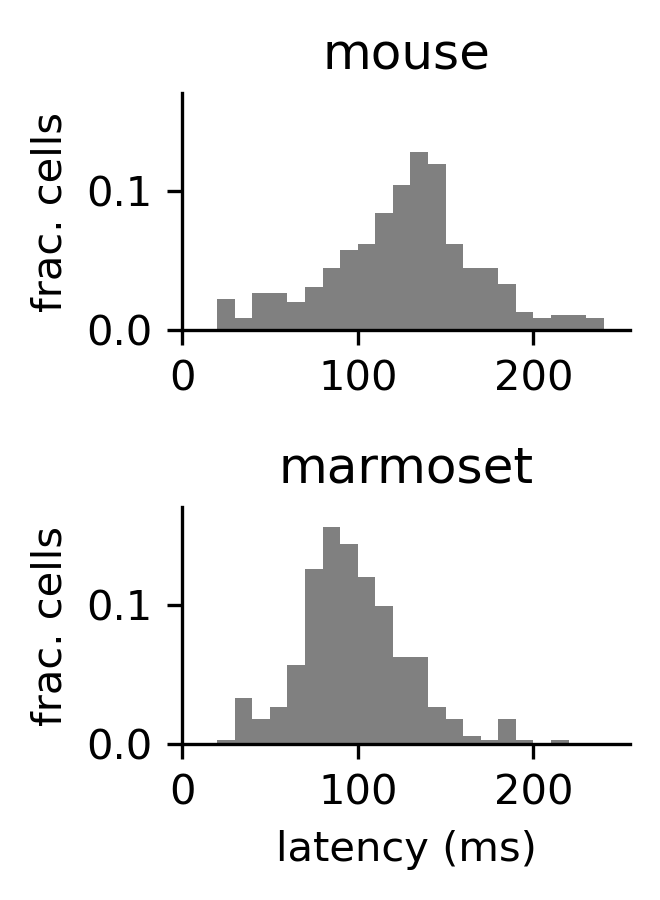

In [213]:
fig, [ax0, ax1] = plt.subplots(2,1, dpi=300, figsize=(2.3,3.1))
mouse_vals = mouse_peakT*1000
mouse_vals[(mouse_vals<25) | (mouse_vals>250)] = np.nan

weights0 = np.ones_like(mouse_vals) / float(len(mouse_vals))
weights1 = np.ones_like(monkey_peakT) / float(len(monkey_peakT))

ax0.hist(mouse_vals, bins=np.arange(0, 250, 10), color='grey', weights=weights0)
ax1.hist(monkey_peakT, bins=np.arange(0, 250, 10), color='grey', weights=weights1)

ax0.set_xlim([0, 255])
ax1.set_xlim([0, 255])

ax0.set_title('mouse')

ax1.set_title('marmoset')

ax1.set_xlabel('latency (ms)')
ax0.set_ylabel('frac. cells')
ax1.set_ylabel('frac. cells')

ax0.set_ylim([0, .17])
ax1.set_ylim([0, .17])

fig.tight_layout()
fig.savefig(os.path.join(figpath, 'hist_mouse_monkey_latency.pdf'))

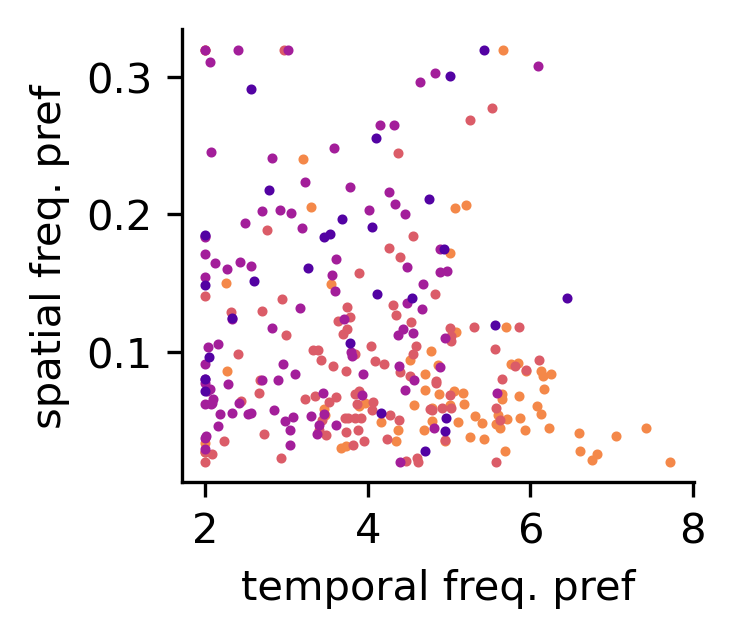

In [216]:
fig, ax = plt.subplots(1,1, dpi=300, figsize=(2.2,2))

names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    
    clusterTF = hffm['tf_pref_cps'][hffm['gazecluster']==name][hffm['Gt_responsive']==True].copy().to_numpy()
    clusterSF = hffm['sf_pref_cpd'][hffm['gazecluster']==name][hffm['Gt_responsive']==True].copy().to_numpy()

    ax.scatter(clusterTF, clusterSF, color=cat_cmap[name], s=2)
    
ax.set_ylabel('spatial freq. pref')
ax.set_xlabel('temporal freq. pref')
fig.savefig(os.path.join(figpath, 'SF_TF_scatter.pdf'))